# Simulation impot concubains avec enfants biologiques.

In [2]:
import datetime
start_time = datetime.datetime.now(); print(start_time)

2019-04-26 18:12:52.640000


In [3]:
year = 2013

In [4]:
%matplotlib inline

In [5]:
from IPython.display import display

In [6]:
import matplotlib.pyplot as plt

In [7]:
from __future__ import division
from collections import OrderedDict
import copy
import pandas as pd ; pd.set_option("display.max_columns",200)
import numpy as np
import pickle
from scipy.stats import chisquare
import statsmodels
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import statsmodels.formula.api as smf
import sys

In [8]:
import sys
sys.path.append(".\Income_tax_function")
import IRPP_from_scratch_2013 as ir


In [9]:
def load_fisc_i_by_year(year = None):
    df_fisci = pd.read_hdf(store_path, 'FISC_INDIVIDU_{}'.format(year))
    return df_fisci
def load_fisc_r_by_year(year = None):
    df_fiscr = pd.read_hdf(store_path, 'FISC_REVENU_{}'.format(year))
    return df_fiscr
def load_fisc_l_by_year(year = None):
    df_fiscr = pd.read_hdf(store_path, 'FISC_LOGEMENT_{}'.format(year))
    return df_fiscr

def load_df_fiscrevdet_by_year(year = None):
    df_fiscrevdet = pd.read_hdf(store_path, 'FISC_REVDET_{}'.format(year))
    return df_fiscrevdet
    

In [10]:
diploma_4_categories = ["No_education_femme", "Vocational_education_femme","Licence_education_femme", "Master_PhD_education_femme",
                       "No_education_homme", "Vocational_education_homme","Licence_education_homme", "Master_PhD_education_homme"]
diploma_4_categories_to_regress =  ["Vocational_education_femme","Licence_education_femme", "Master_PhD_education_femme",
                       "Vocational_education_homme","Licence_education_homme", "Master_PhD_education_homme"]

In [11]:
pd.set_option('precision', 4)
pd.set_option('display.float_format',lambda x: '%.3f' % x)

#LOAD DATASETS

In [12]:
hdf_for_exploitation_path = ("./Generated_hdf/data_to_exploit.h5")

In [13]:
%%time
for key in ["df2013_A","df2013_B", "df2013_C", "df2013_D",
            "df2014_A","df2014_B", "df2014_C","df2014_D", 
            "df_concat_A", "df_concat_B","df_concat_C","df_concat_D",
            "df_A", "df_B", "df_C", "df_D"]:
    globals()[key] = pd.read_hdf(hdf_for_exploitation_path, key)

Wall time: 2.47 s


In [14]:
irpp_decote_allocation_list = ["Irpp_decote_allocation_{}".format(alloc_nb) for alloc_nb in range(1,9)]

# Create diplomas datasets

In [15]:
diploma_4_categories_2013 = [a + "_2013" for a in diploma_4_categories]
for key in ["df2013_A","df2013_B", "df2013_C", "df2013_D",
            "df2014_A","df2014_B", "df2014_C","df2014_D", 
            "df_concat_A", "df_concat_B","df_concat_C","df_concat_D",
            "df_A", "df_B", "df_C", "df_D"]:
    

    
    
    
    df_temp = globals()[key]
    try:
        df_temp = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2] #Keep households for which we have parents diplomas for both years.
        globals()[key+"_diplomas"] = df_temp
    except KeyError: #Deal with diplomas variable having the year in the end of the name
        try: 
            df_temp = df_temp[df_temp[diploma_4_categories_2013].sum(axis = 1) == 2]
            globals()[key+"_diplomas"] = df_temp
        except: Boum

    

In [16]:
df2013_A.shape

(52336, 229)

In [17]:
df2013_A_diplomas.shape

(33044, 229)

#### Enfant dans l'année

In [18]:
new_child_2014_id_fisc_log = df_A[df_A.Family_child_gain].ID_FISC_LOG_DIFF
df_A_new_child = df_A[df_A.Family_child_gain]
df_temp = df_temp[df_temp.ID_FISC_LOG_DIFF.isin(new_child_2014_id_fisc_log)]

### Descriptive stats descriptive stat

In [19]:
df2013_A["Ecart_age_pere_mere"] = df2013_A.Age_pere - df2013_A.Age_mere
df2013_A["Ecart_income_pere_mere"] = np.abs(df2013_A.Rni_pere - df2013_A.Rni_mere)

In [20]:
df2013_A[["Rni","Ecart_income_pere_mere", "Age_moyen","Ecart_age_pere_mere", "Ecart_Age_en_valeur_absolue", "Nb_enfants"]].mean()

Rni                           35426.805
Ecart_income_pere_mere        10151.278
Age_moyen                        33.921
Ecart_age_pere_mere               2.263
Ecart_Age_en_valeur_absolue       3.478
Nb_enfants                        1.568
dtype: float64

In [21]:
df2013_A_diplomas.shape

(33044, 229)

In [22]:
for child in range(1,7):
    df2013_A["Children_number_is_{}".format(child)] = df2013_A.Nb_enfants == child ; df2013_A["Children_number_is_4_and_more"] = df2013_A.Nb_enfants >= 4
    df2013_B["Children_number_is_{}".format(child)] = df2013_A.Nb_enfants == child ; df2013_B["Children_number_is_4_and_more"] = df2013_B.Nb_enfants >= 4
children_number_list = ["Children_number_is_{}".format(child) for child in range(1,4)]+["Children_number_is_4_and_more"]

In [23]:
children_number_list


['Children_number_is_1',
 'Children_number_is_2',
 'Children_number_is_3',
 'Children_number_is_4_and_more']

In [24]:
df2013_A.query("Nb_enfants==1").Age_elder_child.mean()
df2013_A.query("Nb_enfants==1").Age_younger_child.mean()

3.0514450867052023

In [25]:
for df_temp in [df2013_A,df2013_B]:
    for child in range(1,7):
        condition_1 = (df_temp.Nb_enfants == child)
        condition_2 = (df_temp.Nb_enfants >= 4)
        df_temp.loc[condition_1,"Children_number_is_{}_Mean_Age_children".format(child)] = df_temp.Age_moyen_children
        df_temp.loc[condition_1,"Children_number_is_{}_Age_elder_child".format(child)] = df_temp.Age_elder_child
        df_temp.loc[condition_1,"Children_number_is_{}_Age_younger_child".format(child)] = df_temp.Age_younger_child
        df_temp.loc[condition_2,"Children_number_is_4_and_more_Mean_Age_children".format(child)] = df_temp.Age_moyen_children
        df_temp.loc[condition_2,"Children_number_is_4_and_more_Age_elder_child".format(child)] = df_temp.Age_elder_child
        df_temp.loc[condition_2,"Children_number_is_4_and_more_Age_younger_child".format(child)] = df_temp.Age_younger_child

children_var_list = ["Children_number_is_{}".format(child)+var for child in range(1,4)for var in ["","_Mean_Age_children", "_Age_elder_child", "_Age_younger_child"]]
children_var_list += ["Children_number_is_4_and_more"+var for var in ["","_Mean_Age_children", "_Age_elder_child", "_Age_younger_child"]]
children_var_list

['Children_number_is_1',
 'Children_number_is_1_Mean_Age_children',
 'Children_number_is_1_Age_elder_child',
 'Children_number_is_1_Age_younger_child',
 'Children_number_is_2',
 'Children_number_is_2_Mean_Age_children',
 'Children_number_is_2_Age_elder_child',
 'Children_number_is_2_Age_younger_child',
 'Children_number_is_3',
 'Children_number_is_3_Mean_Age_children',
 'Children_number_is_3_Age_elder_child',
 'Children_number_is_3_Age_younger_child',
 'Children_number_is_4_and_more',
 'Children_number_is_4_and_more_Mean_Age_children',
 'Children_number_is_4_and_more_Age_elder_child',
 'Children_number_is_4_and_more_Age_younger_child']

In [26]:
df2013_A.query("Nb_enfants==1").Children_number_is_1_Mean_Age_children.mean()

3.0514450867052023

In [27]:
var_list = ["Rni","Rni_mere", "Rni_pere","Diff_in_incompe_mere_pere", "Age_moyen_parents","Age_pere", "Age_mere", "Ecart_Age_en_valeur_absolue", "Nb_enfants","Age_moyen_children", "Age_elder_child", "Age_younger_child"
           ]+ children_var_list +["TC"]

#["Rni","Rni_pere", "Rni_mere" ,"Diff_in_incompe_mere_pere", "Age_moyen_parents","Age_pere", "Age_mere", "Age_moyen_children", "Age_elder_child", "Age_younger_child"]

In [28]:
var_list[-2]

'Children_number_is_4_and_more_Age_younger_child'

In [29]:
mean_age_by_child_number = [x + "_X_mean_age" for x in children_number_list]

In [30]:
"Children_number_is_1"[19]

'1'

In [31]:
children_var_list[13]

'Children_number_is_4_and_more_Mean_Age_children'

In [32]:
def make_descriptive_with_diplomas_table_two_years(df, var_list, cond_not_optm_str = None, diplomas = True, full = False): 
    df_std = pd.DataFrame()
    good_colomun_order = list()
    df_dict = dict()
    df_temp = df
    vars_list = copy.copy(var_list) #["Rni","Rni_mere", "Rni_pere","Diff_in_incompe_mere_pere", "Age_moyen", "Ecart_Age_en_valeur_absolue", "Nb_enfants", "Age_elder_child", "Age_younger_child"]


 
    cond_diploma = df_temp[diploma_4_categories].sum(axis = 1) == 2


#     do_not_optimize_list = list()
#     optimize_list = list()
    all_list = list()
    diploma_list = list()
    compare_means_list = list()
    cond_not_optm = df_temp[cond_not_optm_str]

    for var in vars_list:
        if var in [children_var_list[i] for i in [1,2,3,5,6,7,9,10,11,13,14,15]]:
            sub_value_child = float(var[19])
            try :
                    
                if sub_value_child ==4: 
                    all_list.append(df_temp.query("Nb_enfants>={}".format(sub_value_child))[var].mean())
                    df_std.loc[var, "All_std"] = df_temp.query("Nb_enfants>={}".format(sub_value_child))[var].std()
                else: 
                    all_list.append(df_temp.query("Nb_enfants=={}".format(sub_value_child))[var].mean())
                    df_std.loc[var, "All_std"] = df_temp.query("Nb_enfants=={}".format(sub_value_child))[var].std()
                    
            except KeyError:
                all_list.append(0)
                df_std.loc[var, "All_std"] = np.Nan
        else:
            try : 
                all_list.append(df_temp[var].mean())
                df_std.loc[var, "All_std"] = df_temp[var].std()
            except KeyError:
                all_list.append(0)
                df_std.loc[var, "All_std"] = np.Nan
    
                    
    for var in vars_list+diploma_4_categories:
        if var in [children_var_list[i] for i in [1,2,3,5,6,7,9,10,11,13,14,15]]:
            sub_value_child = float(var[19])
            try :
                    
                if sub_value_child ==4: 
                    diploma_list.append(df_temp[cond_diploma].query("Nb_enfants>={}".format(sub_value_child))[var].mean())
                    df_std.loc[var, "Diplomas_std"] = df_temp[cond_diploma].query("Nb_enfants>={}".format(sub_value_child))[var].std()
                else: 
                    diploma_list.append(df_temp[cond_diploma].query("Nb_enfants=={}".format(sub_value_child))[var].mean())
                    df_std.loc[var, "Diplomas_std"] = df_temp[cond_diploma].query("Nb_enfants=={}".format(sub_value_child))[var].std()
                    
            except KeyError:
                diploma_list.append(0)
                df_std.loc[var, "Diplomas_std"] = np.Nan
        else:
            try : 
                diploma_list.append(df_temp[cond_diploma][var].mean())
                df_std.loc[var, "Diplomas_std"] = df_temp[cond_diploma][var].std()
            except KeyError:
                diploma_list.append(0)
                df_std.loc[var, "Diplomas_std"] = np.Nan
            
    
    ## T-tests
    for var in vars_list:
        try :
            if var in [children_var_list[i] for i in [1,2,3,5,6,7,9,10,11,13,14,15]]:
                
                sub_value_child = var[19]
                if float(sub_value_child) < 4:
                    weight_stat_diploma =   statsmodels.stats.weightstats.DescrStatsW(df_temp[cond_diploma].query("Nb_enfants=={}".format(sub_value_child))[var])
                    weight_stat_des_all =   statsmodels.stats.weightstats.DescrStatsW(df_temp.query("Nb_enfants=={}".format(sub_value_child))[var])
                else:
                    weight_stat_diploma =   statsmodels.stats.weightstats.DescrStatsW(df_temp[cond_diploma].query("Nb_enfants>={}".format(sub_value_child))[var])
                    weight_stat_des_all =   statsmodels.stats.weightstats.DescrStatsW(df_temp.query("Nb_enfants>={}".format(sub_value_child))[var])
                    
                
                t_test = statsmodels.stats.weightstats.CompareMeans(weight_stat_des_all,weight_stat_diploma).ttest_ind()
                compare_means_list.append(t_test)
                #if var == "Children_number_is_1_Age_younger_child":BOUM
                
            
            else:
                weight_stat_diploma =   statsmodels.stats.weightstats.DescrStatsW(df_temp[cond_diploma][var])
                weight_stat_des_all =   statsmodels.stats.weightstats.DescrStatsW(df_temp[var])
                t_test = statsmodels.stats.weightstats.CompareMeans(weight_stat_des_all,weight_stat_diploma).ttest_ind()
                compare_means_list.append(t_test)
        except KeyError:
            compare_means_list.append(0)
    compare_means_list_transformed = [[a[i] for a in compare_means_list] for i in range(len(compare_means_list[0]))]
    #return len(diploma_list)
    df = pd.DataFrame({"All": all_list+[0]*8 ,"Diplomas_sample": diploma_list,
                      'Delta':pd.Series(all_list+[np.NAN]*8) -pd.Series(diploma_list) , "t-test":compare_means_list_transformed[0]+[np.NAN]*8,  "p-value":compare_means_list_transformed[1]+[np.NAN]*8,  })#"Not_opt_2014" :do_not_optimize_2014_list
    df.index = vars_list+diploma_4_categories
    df.loc["N_obs", "All"] = df_temp.shape[0]   
    df.loc["N_obs", "Diplomas_sample"] = df_temp[cond_diploma].shape[0]



    return df[["All", "Diplomas_sample","Delta",  "t-test" ,  "p-value" ]].fillna(""), df_std

In [33]:
df2013_A.query("Nb_enfants==1").Age_younger_child.mean()

3.0514450867052023

In [34]:
df2013_A.Rni.std()

26000.430291026849

In [35]:
### Add std

In [36]:
def make_descriptive_with_diplomas_table_two_years(df_concat, var_list, cond_not_optm_str = None, diplomas = True, full = False): 
    good_colomun_order = list()
    for year in [2013,2014]:
        for col in ["All_{}".format(year),  "opt_{}".format(year), "Not_opt_{}".format(year), "Delta_{}".format(year) ]:
            good_colomun_order.append(col)
    df_dict = dict()
    df_temp = df_concat
    vars_list = copy.copy(var_list) #["Rni","Rni_mere", "Rni_pere","Diff_in_incompe_mere_pere", "Age_moyen", "Ecart_Age_en_valeur_absolue", "Nb_enfants", "Age_elder_child", "Age_younger_child"]

    if diplomas == True:
        vars_list += diploma_4_categories 
        df_temp = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]



    do_not_optimize_list = list()
    optimize_list = list()
    all_list = list()
    compare_means_list = list()
    cond_not_optm = df_temp[cond_not_optm_str]

    for var in vars_list:
        try : 
            all_list.append(df_temp[var].mean())
        except KeyError:
            all_list.append(0)
        try : 
            do_not_optimize_list.append(df_temp[cond_not_optm][var].mean())
        except KeyError:
            do_not_optimize_list.append(0)
        try : 
            optimize_list.append(df_temp[~cond_not_optm][var].mean())
        except KeyError:
            optimize_list.append(0)
    
    
    for var in vars_list:
        try : 
            weight_stat_des_opt =   statsmodels.stats.weightstats.DescrStatsW(df_temp[~cond_not_optm][var])
            weight_stat_des_not_opt =   statsmodels.stats.weightstats.DescrStatsW(df_temp[cond_not_optm][var])
            t_test = statsmodels.stats.weightstats.CompareMeans(weight_stat_des_opt,weight_stat_des_not_opt).ttest_ind()
            compare_means_list.append(t_test)
        except KeyError:
            compare_means_list.append(0)
    compare_means_list_transformed = [[a[i] for a in compare_means_list] for i in range(len(compare_means_list[0]))]

    df = pd.DataFrame({"All": all_list ,"opt" :optimize_list,"Not_opt" :do_not_optimize_list ,
                      'Delta':pd.Series(optimize_list) -pd.Series(do_not_optimize_list) , "t-test":compare_means_list_transformed[0],  "p-value":compare_means_list_transformed[1],  })#"Not_opt_2014" :do_not_optimize_2014_list
    df.index = vars_list
    df.loc["N_obs", "All"] = df_temp.shape[0]   
    df.loc["N_obs", "opt".format(year)] = df_temp[~cond_not_optm].shape[0]
    df.loc["N_obs", "Not_opt".format(year)] = df_temp[cond_not_optm].shape[0]


    return df[["All","opt","Not_opt", "Delta",  "t-test" ,  "p-value" ]].fillna("")
    #return df[["All","opt","Not_opt", "Delta"  ]]#[[ "Share","N","Share_2014","N_2014"]]

In [37]:
var_list

['Rni',
 'Rni_mere',
 'Rni_pere',
 'Diff_in_incompe_mere_pere',
 'Age_moyen_parents',
 'Age_pere',
 'Age_mere',
 'Ecart_Age_en_valeur_absolue',
 'Nb_enfants',
 'Age_moyen_children',
 'Age_elder_child',
 'Age_younger_child',
 'Children_number_is_1',
 'Children_number_is_1_Mean_Age_children',
 'Children_number_is_1_Age_elder_child',
 'Children_number_is_1_Age_younger_child',
 'Children_number_is_2',
 'Children_number_is_2_Mean_Age_children',
 'Children_number_is_2_Age_elder_child',
 'Children_number_is_2_Age_younger_child',
 'Children_number_is_3',
 'Children_number_is_3_Mean_Age_children',
 'Children_number_is_3_Age_elder_child',
 'Children_number_is_3_Age_younger_child',
 'Children_number_is_4_and_more',
 'Children_number_is_4_and_more_Mean_Age_children',
 'Children_number_is_4_and_more_Age_elder_child',
 'Children_number_is_4_and_more_Age_younger_child',
 'TC']

## Optimize vs. Do not optimize

### With diplomas

In [38]:
make_descriptive_with_diplomas_table_two_years(df2013_A,var_list,
                       "Do_not_optimize",diplomas = True )

,All,opt,Not_opt,Delta,t-test,p-value
Rni,35440.076,34394.379,38509.909,-4115.530,-17.027,0.000
Rni_mere,14775.673,13894.866,17361.441,-3466.575,-25.104,0.000
Rni_pere,20664.403,20499.513,21148.468,-648.955,-3.958,0.000
Diff_in_incompe_mere_pere,9876.557,10785.452,7208.332,3577.120,23.433,0.000
Age_moyen_parents,34.203,33.980,34.856,-0.876,-11.175,0.000
Age_pere,35.316,35.115,35.907,-0.792,-9.179,0.000
Age_mere,33.090,32.846,33.806,-0.960,-12.182,0.000
Ecart_Age_en_valeur_absolue,3.405,3.425,3.345,0.080,1.960,0.050
Nb_enfants,1.587,1.577,1.617,-0.040,-4.544,0.000
Age_moyen_children,4.011,3.966,4.142,-0.176,-4.269,0.000


### Correlation Age Parents Age_enfants

In [39]:
df2013_A.corr()[["Age", "Age_mere", "Age_pere"]].loc[["Age_moyen_children", "Age_younger_child", "Age_elder_child"]]

,Age,Age_mere,Age_pere
Age_moyen_children,0.654,0.648,0.597
Age_younger_child,0.620,0.617,0.564
Age_elder_child,0.625,0.617,0.572


#### Optimize at 1%

In [40]:
make_descriptive_with_diplomas_table_two_years(df2013_A,var_list,
                       "Do_not_optimize_1_prct_income_share",diplomas = True )

,All,opt,Not_opt,Delta,t-test,p-value
Rni,35440.076,35462.036,35191.059,270.977,0.700,0.484
Rni_mere,14775.673,14818.470,14290.390,528.080,2.375,0.018
Rni_pere,20664.403,20643.566,20900.670,-257.103,-0.983,0.326
Diff_in_incompe_mere_pere,9876.557,9811.855,10610.226,-798.371,-3.252,0.001
Age_moyen_parents,34.203,34.187,34.387,-0.200,-1.599,0.110
Age_pere,35.316,35.296,35.541,-0.244,-1.774,0.076
Age_mere,33.090,33.077,33.233,-0.156,-1.239,0.215
Ecart_Age_en_valeur_absolue,3.405,3.399,3.465,-0.066,-1.010,0.313
Nb_enfants,1.587,1.568,1.808,-0.240,-17.179,0.000
Age_moyen_children,4.011,4.019,3.923,0.096,1.457,0.145


### Without diplomas

In [41]:
make_descriptive_with_diplomas_table_two_years(df2013_A,var_list,
                       "Do_not_optimize",diplomas = False )

,All,opt,Not_opt,Delta,t-test,p-value
Rni,35426.805,34398.967,38533.071,-4134.104,-15.759,0.000
Rni_mere,14814.984,14018.201,17222.966,-3204.765,-23.742,0.000
Rni_pere,20611.822,20380.765,21310.105,-929.339,-4.727,0.000
Diff_in_incompe_mere_pere,10151.278,10973.773,7665.590,3308.183,17.035,0.000
Age_moyen_parents,33.921,33.666,34.689,-1.023,-15.833,0.000
Age_pere,35.052,34.814,35.771,-0.957,-13.483,0.000
Age_mere,32.789,32.519,33.607,-1.089,-16.739,0.000
Ecart_Age_en_valeur_absolue,3.478,3.496,3.422,0.073,2.183,0.029
Nb_enfants,1.568,1.553,1.613,-0.060,-8.342,0.000
Age_moyen_children,3.778,3.727,3.931,-0.204,-6.153,0.000


In [42]:
make_descriptive_with_diplomas_table_two_years(df2013_A,var_list,
                       "Do_not_optimize_1_prct_income_share",diplomas = False )

,All,opt,Not_opt,Delta,t-test,p-value
Rni,35426.805,35443.817,35238.057,205.760,0.499,0.618
Rni_mere,14814.984,14895.226,13924.680,970.546,4.558,0.000
Rni_pere,20611.822,20548.591,21313.377,-764.786,-2.478,0.013
Diff_in_incompe_mere_pere,10151.278,10036.712,11422.412,-1385.699,-4.535,0.000
Age_moyen_parents,33.921,33.889,34.268,-0.378,-3.725,0.000
Age_pere,35.052,35.016,35.453,-0.437,-3.918,0.000
Age_mere,32.789,32.763,33.083,-0.320,-3.127,0.002
Ecart_Age_en_valeur_absolue,3.478,3.470,3.560,-0.090,-1.714,0.087
Nb_enfants,1.568,1.548,1.794,-0.247,-21.838,0.000
Age_moyen_children,3.778,3.778,3.776,0.001,0.026,0.979


##### Child birth in 2013

In [43]:
make_descriptive_with_diplomas_table_two_years(df2013_A[df2013_A.ID_FISC_LOG_DIFF.isin(new_child_2014_id_fisc_log)], var_list,
                       "Do_not_optimize_1_prct_income_share",diplomas = True )

,All,opt,Not_opt,Delta,t-test,p-value
Rni,33690.320,33798.934,32374.608,1424.326,0.902,0.367
Rni_mere,14283.468,14307.106,13997.125,309.981,0.427,0.669
Rni_pere,19406.852,19491.828,18377.483,1114.345,0.914,0.361
Diff_in_incompe_mere_pere,8734.010,8760.954,8407.631,353.323,0.319,0.750
Age_moyen_parents,31.528,31.516,31.670,-0.154,-0.425,0.671
Age_pere,32.669,32.661,32.767,-0.106,-0.255,0.798
Age_mere,30.387,30.371,30.574,-0.202,-0.556,0.578
Ecart_Age_en_valeur_absolue,3.179,3.165,3.352,-0.188,-0.816,0.415
Nb_enfants,1.256,1.243,1.403,-0.160,-3.924,0.000
Age_moyen_children,3.092,3.088,3.141,-0.053,-0.334,0.738


In [44]:
import statsmodels.stats.weightstats as lo

In [45]:
sm.stats.ttest_ind(df2013_D[df2013_D.Do_not_optimize].Age_moyen,df2013_D[~df2013_D.Do_not_optimize].Age_moyen )

(11.807741654282614, 3.9869958636110004e-32, 43416.0)

In [46]:
var_list = ["Rni","Rni_pere", "Rni_mere" ,"Diff_in_incompe_mere_pere", "Age_moyen_parents","Age_pere", "Age_mere", "Age_moyen_children", "Age_elder_child", "Age_younger_child"]

In [47]:
pd.options.display.float_format = '{:.2f}'.format

#### By number of children

In [48]:
df_temp = pd.DataFrame()

for var in var_list+diploma_4_categories:
        df_temp.loc[var, "All"] = df2013_A_diplomas[var].mean()
df_temp.loc["N_Obs", "All"] = len(df2013_A_diplomas)
df_temp.loc["Share", "All"] = len(df2013_A_diplomas) / len(df2013_A_diplomas)
for var in var_list+diploma_4_categories:
    for child in range(1,7):
        df_temp.loc[var, child] = df2013_A_diplomas.query("Nb_enfants == {}".format(child))[var].mean()
        df_temp.loc["N_Obs", child] = len(df2013_A_diplomas.query("Nb_enfants == {}".format(child)))
        df_temp.loc["Share", child] = len(df2013_A_diplomas.query("Nb_enfants == {}".format(child))) / len(df2013_A_diplomas)
df_mean_diplomas = df_temp

In [49]:
df_mean_diplomas

,All,1,2,3,4,5,6
Rni,35440.08,35902.00,35951.58,30184.29,26437.18,27883.45,18870.84
Rni_pere,20664.40,20205.89,21415.43,20317.77,17196.62,21343.25,14366.84
Rni_mere,14775.67,15696.11,14536.15,9866.52,9240.56,6540.20,4504.00
Diff_in_incompe_mere_pere,9876.56,8698.64,10718.02,13810.37,11779.94,16883.05,12196.48
Age_moyen_parents,34.20,33.48,34.94,35.37,33.97,35.90,33.32
Age_pere,35.32,34.57,36.04,36.69,35.44,37.30,34.59
Age_mere,33.09,32.39,33.83,34.06,32.51,34.50,32.05
Age_moyen_children,4.01,3.30,4.64,5.59,4.53,5.66,4.63
Age_elder_child,4.84,3.30,6.17,8.42,6.65,9.75,7.38
Age_younger_child,3.17,3.30,3.12,2.56,2.38,1.55,1.70


In [50]:
df_temp = pd.DataFrame()

for var in var_list:
        df_temp.loc[var, "All"] = df2013_A[var].mean()
df_temp.loc["N_Obs", "All"] = len(df2013_A)
df_temp.loc["Share", "All"] = len(df2013_A) / len(df2013_A)
for var in var_list:
    for child in range(1,7):
        df_temp.loc[var, child] = df2013_A.query("Nb_enfants == {}".format(child))[var].mean()
        df_temp.loc["N_Obs", child] = len(df2013_A.query("Nb_enfants == {}".format(child)))
        df_temp.loc["Share", child] = len(df2013_A.query("Nb_enfants == {}".format(child))) / len(df2013_A)
df_mean =df_temp; df_mean.index.name = "Nb_child"; df_mean

,All,1,2,3,4,5,6
Nb_child,,,,,,,
Rni,35426.81,35970.36,35934.93,29872.17,25851.92,22834.23,19195.03
Rni_pere,20611.82,20259.63,21354.98,20055.46,16904.41,16682.75,14807.47
Rni_mere,14814.98,15710.73,14579.95,9816.71,8947.51,6151.48,4387.56
Diff_in_incompe_mere_pere,10151.28,9138.74,10987.87,13610.27,11599.84,13325.06,12258.50
Age_moyen_parents,33.92,33.15,34.77,35.27,33.93,35.35,34.12
Age_pere,35.05,34.26,35.88,36.60,35.45,36.79,35.84
Age_mere,32.79,32.04,33.65,33.93,32.41,33.92,32.39
Age_moyen_children,3.78,3.05,4.49,5.47,4.42,6.05,4.84
Age_elder_child,4.54,3.05,5.94,8.24,6.53,9.90,7.64


In [51]:
###Stats 4 child or more

In [52]:
df2013_A.query("Nb_enfants >= 4")[["Age_moyen_children", "Age_elder_child", "Age_younger_child"]].mean()

Age_moyen_children   4.55
Age_elder_child      6.81
Age_younger_child    2.23
dtype: float64

In [53]:
 df2013_A_diplomas.query("Nb_enfants >= 4")[["Age_moyen_children", "Age_elder_child", "Age_younger_child"]].mean()

Age_moyen_children   4.57
Age_elder_child      6.81
Age_younger_child    2.29
dtype: float64

In [54]:
df_mean - df_mean_diplomas

,All,1,2,3,4,5,6
Age_elder_child,-0.30,-0.25,-0.23,-0.18,-0.12,0.15,0.27
Age_mere,-0.30,-0.35,-0.18,-0.12,-0.09,-0.58,0.34
Age_moyen_children,-0.23,-0.25,-0.15,-0.13,-0.11,0.39,0.21
Age_moyen_parents,-0.28,-0.33,-0.17,-0.11,-0.04,-0.55,0.80
Age_pere,-0.26,-0.31,-0.16,-0.09,0.01,-0.51,1.25
Age_younger_child,-0.16,-0.25,-0.08,-0.07,-0.08,0.22,0.14
Diff_in_incompe_mere_pere,274.72,440.10,269.85,-200.10,-180.10,-3557.99,62.01
Licence_education_femme,nan,nan,nan,nan,nan,nan,nan
Licence_education_homme,nan,nan,nan,nan,nan,nan,nan
Master_PhD_education_femme,nan,nan,nan,nan,nan,nan,nan


# Repartition between man and woman

### Effective repartition

In [55]:
assert np.all((df2013_A.Allocation_mere + df2013_A.Allocation_pere) == df2013_A.Nb_enfants)

In [56]:
df2013_A["All_on_man"] = df2013_A.Allocation_pere == df2013_A.Nb_enfants
df2013_A["All_on_woman"] = df2013_A.Allocation_mere == df2013_A.Nb_enfants

In [57]:
df2013_A["Equal_split"] = df2013_A.Allocation_pere == df2013_A.Allocation_mere

In [58]:
df2013_A["Most_on_man"] = (~df2013_A.All_on_man)& (df2013_A.Allocation_pere > df2013_A.Allocation_mere)
df2013_A["Most_on_woman"] = (~df2013_A.All_on_woman)& (df2013_A.Allocation_pere < df2013_A.Allocation_mere)

In [59]:
df2013_A[["All_on_man","All_on_woman","Equal_split", "Most_on_man",  "Most_on_woman" ]].mean()

All_on_man      0.52
All_on_woman    0.29
Equal_split     0.17
Most_on_man     0.01
Most_on_woman   0.01
dtype: float64

In [60]:
df_child_repartition = pd.DataFrame()
for child in range(1,7):
    df_temp = df2013_A.query("Nb_enfants == {}".format(child))[["All_on_man","All_on_woman","Equal_split", "Most_on_man",  "Most_on_woman" ]]
    df_child_repartition["child_{}".format(child)] = df_temp.mean()

In [61]:
n_obs_by_child_rank_array =[len( df2013_A.query("Nb_enfants == {}".format(child))) for child in range(1,7)]

In [62]:
#Effective repartition
df_child_repartition["Total_average"] = df2013_A[["All_on_man","All_on_woman","Equal_split", "Most_on_man",  "Most_on_woman" ]].mean()
df_child_repartition.loc["N_obs", :] = n_obs_by_child_rank_array + [""]
df_child_repartition

,child_1,child_2,child_3,child_4,child_5,child_6,Total_average
All_on_man,0.59,0.44,0.58,0.14,0.54,0.05,0.52
All_on_woman,0.41,0.18,0.13,0.03,0.08,0.01,0.29
Equal_split,0.00,0.39,0.00,0.79,0.00,0.91,0.17
Most_on_man,0.00,0.00,0.18,0.03,0.23,0.03,0.01
Most_on_woman,0.00,0.00,0.11,0.01,0.15,0.01,0.01
N_obs,27680.00,21020.00,2500.00,969.00,48.00,109.00,


In [63]:
#Effective repartition
df_child_repartition["Total_average"] = df2013_A[["All_on_man","All_on_woman","Equal_split", "Most_on_man",  "Most_on_woman" ]].mean()
df_child_repartition.loc["N_obs", :] = n_obs_by_child_rank_array + [""]
df_child_repartition

,child_1,child_2,child_3,child_4,child_5,child_6,Total_average
All_on_man,0.59,0.44,0.58,0.14,0.54,0.05,0.52
All_on_woman,0.41,0.18,0.13,0.03,0.08,0.01,0.29
Equal_split,0.00,0.39,0.00,0.79,0.00,0.91,0.17
Most_on_man,0.00,0.00,0.18,0.03,0.23,0.03,0.01
Most_on_woman,0.00,0.00,0.11,0.01,0.15,0.01,0.01
N_obs,27680.00,21020.00,2500.00,969.00,48.00,109.00,


In [64]:
cm = statsmodels.stats.weightstats.CompareMeans(statsmodels.stats.weightstats.DescrStatsW(df2013_A[["Age_pere", "Age_mere"]]),statsmodels.stats.weightstats.DescrStatsW(df2013_A[["Age_pere", "Age_mere"]]+0.1))

In [65]:
statsmodels.stats.weightstats.DescrStatsW([1,2,3])

In [66]:
cm.std_meandiff_separatevar

array([ 0.04344186,  0.03985517])

In [67]:
a = df2013_A.Optimal_allocations.str.split("allocation_").apply(set)

In [68]:
df2013_A["Optimal_allocation_number"] = df2013_A.Optimal_allocations.str.split("allocation_").apply(lambda x: x[1:])


### Optimal repartition

In [69]:
def list_string_to_int(liste):
    return [int(b) for b in liste ]

df2013_A["Optimal_allocation_number"] = df2013_A.Optimal_allocation_number.apply(lambda x: list_string_to_int(x))

In [70]:
df2013_A["Optimal_allocation_number_minus_one"] = df2013_A.Optimal_allocation_number.apply(lambda x: [a-1 for a in x])

In [71]:
( df2013_A.apply(lambda x: x["Nb_enfants"]+1 in x["Optimal_allocation_number"], 1)).value_counts()

True     34354
False    17982
dtype: int64

In [72]:
print(df2013_A["Most_on_man"].value_counts())

False    51844
True       492
dtype: int64


In [73]:
print(df2013_A["Optimal_allocation_number_minus_one"].reset_index().head(3))

   index Optimal_allocation_number_minus_one
0      0                                 [1]
1      1                                 [1]
2      2                                 [0]


In [74]:
print(df2013_A["Optimal_allocation_number"].reset_index())

       index                          Optimal_allocation_number
0          0                                                [2]
1          1                                                [2]
2          2                                                [1]
3          3                                                [1]
4          4                                                [1]
5          5                                                [1]
6          6                                                [2]
7          7                                                [2]
8          8                                                [2]
9          9                                                [2]
10        10                                                [2]
11        11                                                [1]
12        12                                                [1]
13        13                                                [2]
14        14                            

In [75]:
df2013_A["All_on_man_optimal"] = ( df2013_A.apply(lambda x: x["Nb_enfants"]+1 in x["Optimal_allocation_number"], 1)) #Since the last allocation (nb_enf+1) is the allocation where all children are on the father
df2013_A["All_on_woman_optimal"] = ( df2013_A.apply(lambda x: 1 in x["Optimal_allocation_number"], 1)) #Since the first allocation is the allocation where all children are on the father

df2013_A["Equal_split_optimal"] =   (df2013_A.apply(lambda x: (x["Nb_enfants"]/2) 
                                                    in x["Optimal_allocation_number_minus_one"], 1)
                                    ) #Since the middle allocation is the equalt split allocation.
df2013_A["Most_on_man_optimal"] =  ((df2013_A.apply(
            lambda x: [a> ((x["Nb_enfants"]/2)) for a in  x["Optimal_allocation_number_minus_one"]], 1)).apply(any)  #Since the allocations greater than the middle allocations are those of the father
                                    & (~df2013_A["All_on_man_optimal"]) )
df2013_A["Most_on_woman_optimal"] =  ((df2013_A.apply(
            lambda x: [a< ((x["Nb_enfants"]/2)) for a in  x["Optimal_allocation_number_minus_one"]], 1)).apply(any)  #Since the allocations greater than the middle allocations are those of the mother
                                      & (~ df2013_A["All_on_woman_optimal"]))

In [76]:
print(df2013_A["Equal_split_optimal"].sum())

10778


In [77]:
df_child_repartition = pd.DataFrame()
for child in range(1,7):
    df_temp = df2013_A.query("Nb_enfants == {}".format(child))[["All_on_man_optimal","All_on_woman_optimal","Equal_split_optimal", "Most_on_man_optimal",  "Most_on_woman_optimal" ]]
    df_child_repartition["child_{}".format(child)] = df_temp.mean()
    

In [78]:
df_child_repartition.loc["Total"] = df_child_repartition.sum(axis = 0)
df_child_repartition.loc["N_obs"] = n_obs_by_child_rank_array ; df_child_repartition

,child_1,child_2,child_3,child_4,child_5,child_6
All_on_man_optimal,0.70,0.59,0.74,0.69,0.81,0.85
All_on_woman_optimal,0.41,0.22,0.22,0.32,0.40,0.38
Equal_split_optimal,0.00,0.48,0.00,0.60,0.00,0.88
Most_on_man_optimal,0.00,0.00,0.13,0.16,0.08,0.11
Most_on_woman_optimal,0.00,0.00,0.16,0.15,0.17,0.31
Total,1.11,1.29,1.26,1.92,1.46,2.53
N_obs,27680.00,21020.00,2500.00,969.00,48.00,109.00


In [79]:
pd.DataFrame(df2013_A.pivot_table(values = "All_on_woman_optimal", columns = ['All_on_man_optimal','All_on_woman'], aggfunc=np.mean))

0
All_on_man_optimal All_on_woman     
False              False        0.40
                   True         0.86
True               False        0.13
                   True         0.34

In [80]:
df2013_A["Not_all_on_man_optimal"] = ~df2013_A.All_on_man_optimal
df2013_A["Not_all_on_woman_optimal"] = ~df2013_A.All_on_woman_optimal
df2013_A["Not_equal_split_optimal"] = ~df2013_A.Equal_split_optimal
df2013_A["Not_most_on_man_optimal"] =  ~df2013_A.Most_on_man_optimal
df2013_A["Not_most_on_woman_optimal"] = ~df2013_A.Most_on_woman_optimal

df2013_A["Not_all_on_man"] = ~df2013_A.All_on_man
df2013_A["Not_all_on_woman"] = ~df2013_A.All_on_woman
df2013_A["Not_equal_split"] = ~df2013_A.Equal_split
df2013_A["Not_most_on_man"] =  ~df2013_A.Most_on_man
df2013_A["Not_most_on_woman"] = ~df2013_A.Most_on_woman

In [81]:

tuples = [("Not_all_on_man_optimal", u'Not_all_on_man'),("Not_all_on_man_optimal", u'All_on_man'),
           ("Not_all_on_woman_optimal", u'Not_all_on_woman'),("Not_all_on_woman_optimal", u'All_on_woman'),
          ("Not_equal_split_optimal", u'Not_equal_split'),("Not_equal_split_optimal", u'Equal_split'),
          ("Not_most_on_man_optimal", u'Not_most_on_man'),("Not_most_on_man_optimal", u'Most_on_man'),
          ("Not_most_on_woman_optimal", u'Not_most_on_woman'),("Not_most_on_woman_optimal", u'Most_on_woman'),
         ]

index = pd.MultiIndex.from_tuples(tuples)
df_temp = pd.DataFrame(columns=range(1,5),index = index)
for child in range(1,7):
    df_child_temp = df2013_A.query("Nb_enfants == {}".format(child))
    for a,b in tuples:
        df_temp.loc[(a,b), child] = (df_child_temp[a] *  df_child_temp[b] ).sum()
    df_temp.loc[("N_obs", ""), child] =  len(df_child_temp)
for a,b in tuples:        
    df_child_temp = df2013_A
    df_temp.loc[(a,b), "All"] = (df_child_temp[a] *  df_child_temp[b] ).sum()
df_temp.loc[("N_obs", ""), "All"] =  len(df_child_temp)
df_temp


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\pandas\computation\expressions.py:190: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


1      2     3    4     5  \
Not_all_on_man_optimal    Not_all_on_man      5893   7268   566  302  8.00   
                          All_on_man          2408   1445    74    1  1.00   
Not_all_on_woman_optimal  Not_all_on_woman   12423  14644  1837  650 28.00   
                          All_on_woman        3824   1656   106    8  1.00   
Not_equal_split_optimal   Not_equal_split    27680   8054  2500   88 48.00   
                          Equal_split            0   2861     0  304  0.00   
Not_most_on_man_optimal   Not_most_on_man    27680  21020  1888  790 34.00   
                          Most_on_man            0      0   275   22 10.00   
Not_most_on_woman_optimal Not_most_on_woman  27680  21020  1927  813 34.00   
                          Most_on_woman          0      0   176    9  6.00   
N_obs                                        27680  21020  2500  969 48.00   

                                                 6      All  
Not_all_on_man_optimal    Not_all_on_man     16.00 14053.00  
                          All_on_man          0.00  3929.00  
Not_all_on_woman_optimal  Not_all_on_woman   68.00 29658.00  
                          All_on_woman        0.00  5595.00  
Not_equal_split_optimal   Not_equal_split     0.00 38380.00  
                          Equal_split        13.00  3178.00  
Not_most_on_man_optimal   Not_most_on_man    94.00 51510.00  
                          Most_on_man         3.00   316.00  
Not_most_on_woman_optimal Not_most_on_woman  75.00 51549.00  
                          Most_on_woman       0.00   193.00  
N_obs                                       109.00 52336.00

In [82]:

tuples = [("Not_all_on_man_optimal", u'All_on_man'),
          ("Not_all_on_woman_optimal", u'All_on_woman'),
          ("Not_equal_split_optimal", u'Equal_split'),
          ("Not_most_on_man_optimal", u'Most_on_man'),
          ("Not_most_on_woman_optimal", u'Most_on_woman'),
         ]
index = pd.MultiIndex.from_tuples(tuples)
df_temp = pd.DataFrame(columns=range(1,5),index = index)
for child in range(1,7):
    df_child_temp = df2013_A.query("Nb_enfants == {}".format(child))
    for a,b in tuples:
        df_temp.loc[(a,b), child] = (df_child_temp[a] *  df_child_temp[b] ).sum()/len(df_child_temp[df_child_temp[a]])
    df_temp.loc[("N_obs", ""), child] =  len(df_child_temp)
for a,b in tuples:        
    df_child_temp = df2013_A
    df_temp.loc[(a,b), "All"] = (df_child_temp[a] *  df_child_temp[b] ).sum()/len(df_child_temp[df_child_temp[a]])
df_temp.loc[("N_obs", ""), "All"] =  len(df_child_temp)
df_temp

,,1,2,3,4,5,6,All
Not_all_on_man_optimal,All_on_man,0.29,0.17,0.12,0.00,0.11,0.00,0.22
Not_all_on_woman_optimal,All_on_woman,0.24,0.10,0.05,0.01,0.03,0.00,0.16
Not_equal_split_optimal,Equal_split,0.00,0.26,0.00,0.78,0.00,1.00,0.08
Not_most_on_man_optimal,Most_on_man,0.00,0.00,0.13,0.03,0.23,0.03,0.01
Not_most_on_woman_optimal,Most_on_woman,0.00,0.00,0.08,0.01,0.15,0.00,0.00
N_obs,,27680,21020,2500,969,48.00,109.00,52336.00


In [83]:
df2013_B.query("Nb_enfants==1").Do_not_optimize.value_counts(normalize=True)

False   0.75
True    0.25
dtype: float64

In [84]:
df_temp

,,1,2,3,4,5,6,All
Not_all_on_man_optimal,All_on_man,0.29,0.17,0.12,0.00,0.11,0.00,0.22
Not_all_on_woman_optimal,All_on_woman,0.24,0.10,0.05,0.01,0.03,0.00,0.16
Not_equal_split_optimal,Equal_split,0.00,0.26,0.00,0.78,0.00,1.00,0.08
Not_most_on_man_optimal,Most_on_man,0.00,0.00,0.13,0.03,0.23,0.03,0.01
Not_most_on_woman_optimal,Most_on_woman,0.00,0.00,0.08,0.01,0.15,0.00,0.00
N_obs,,27680,21020,2500,969,48.00,109.00,52336.00


In [85]:
tuples = [("Not_all_on_man_optimal", u'Not_all_on_man'),("Not_all_on_man_optimal", u'All_on_man'),
           ("Not_all_on_woman_optimal", u'Not_all_on_woman'),("Not_all_on_woman_optimal", u'All_on_woman'),
          ("Not_equal_split_optimal", u'Not_equal_split'),("Not_equal_split_optimal", u'Equal_split'),
          ("Not_most_on_man_optimal", u'Not_most_on_men'),("Not_most_on_man_optimal", u'Most_on_men'),
          ("Not_most_on_woman_optimal", u'Not_most_on_women'),("Not_most_on_woman_optimal", u'Most_on_women'),
         ]
index = pd.MultiIndex.from_tuples(tuples)
df_temp = pd.DataFrame(columns=range(1,5),index = index)
for child in range(1,7):
    df_child_temp = df2013_A.query("Nb_enfants == {}".format(child))
    df_temp.loc[("Not_all_on_man_optimal", u'Not_all_on_man'), child] = (df_child_temp["Not_all_on_man_optimal"] *  df_child_temp["Not_all_on_man"] ).mean()
    df_temp.loc[("Not_all_on_man_optimal", u'All_on_man'), child] = (df_child_temp["Not_all_on_man_optimal"] *  df_child_temp["All_on_man"] ).mean()
    df_temp.loc[("Not_all_on_woman_optimal", u'Not_all_on_woman'), child] = (df_child_temp["Not_all_on_woman_optimal"] *  df_child_temp["Not_all_on_woman"] ).mean()
    df_temp.loc[("Not_all_on_woman_optimal", u'All_on_woman'), child] = (df_child_temp["Not_all_on_woman_optimal"] *  df_child_temp["All_on_woman"] ).mean()

    df_temp.loc[("Not_equal_split_optimal", u'Not_equal_split'), child] = (df_child_temp["Not_equal_split_optimal"] *  df_child_temp["Not_equal_split"] ).mean()
    df_temp.loc[("Not_equal_split_optimal", u'Equal_split'), child] = (df_child_temp["Not_equal_split_optimal"] *  df_child_temp["Equal_split"] ).mean()
    
    df_temp.loc[("Not_equal_split_optimal", u'Not_equal_split'), child] = (df_child_temp["Not_equal_split_optimal"] *  df_child_temp["Not_equal_split"] ).mean()
    df_temp.loc[("Not_equal_split_optimal", u'Equal_split'), child] = (df_child_temp["Not_equal_split_optimal"] *  df_child_temp["Equal_split"] ).mean()
    
    df_temp.loc[("Not_most_on_man_optimal", u'Not_most_on_men'), child] = (df_child_temp["Not_most_on_man_optimal"] *  df_child_temp["Not_most_on_man"] ).mean()
    df_temp.loc[("Not_most_on_man_optimal", u'Most_on_men'), child] = (df_child_temp["Not_most_on_man_optimal"] *  df_child_temp["Most_on_man"] ).mean()
    df_temp.loc[("Not_most_on_woman_optimal", u'Not_most_on_women'), child] = (df_child_temp["Not_most_on_woman_optimal"] *  df_child_temp["Not_most_on_woman"] ).mean()
    df_temp.loc[("Not_most_on_woman_optimal", u'Most_on_women'), child] = (df_child_temp["Not_most_on_woman_optimal"] *  df_child_temp["Most_on_woman"] ).mean()
    df_temp.loc[("N_obs", ""), child] =  len(df_child_temp)
df_temp_all = df2013_A

df_child_temp_all = df2013_A

df_temp.loc[("Not_all_on_man_optimal", u'Not_all_on_man'), "All"] = (df_child_temp_all["Not_all_on_man_optimal"] *  df_child_temp_all["Not_all_on_man"] ).mean()
df_temp.loc[("Not_all_on_man_optimal", u'All_on_man'), "All"] = (df_child_temp_all["Not_all_on_man_optimal"] *  df_child_temp_all["All_on_man"] ).mean()
df_temp.loc[("Not_all_on_woman_optimal", u'Not_all_on_woman'), "All"] = (df_child_temp_all["Not_all_on_woman_optimal"] *  df_child_temp_all["Not_all_on_woman"] ).mean()
df_temp.loc[("Not_all_on_woman_optimal", u'All_on_woman'), "All"] = (df_child_temp_all["Not_all_on_woman_optimal"] *  df_child_temp_all["All_on_woman"] ).mean()

df_temp.loc[("Not_equal_split_optimal", u'Not_equal_split'), "All"] = (df_child_temp_all["Not_equal_split_optimal"] *  df_child_temp_all["Not_equal_split"] ).mean()
df_temp.loc[("Not_equal_split_optimal", u'Equal_split'), "All"] = (df_child_temp_all["Not_equal_split_optimal"] *  df_child_temp_all["Equal_split"] ).mean()

df_temp.loc[("Not_equal_split_optimal", u'Not_equal_split'), "All"] = (df_child_temp_all["Not_equal_split_optimal"] *  df_child_temp_all["Not_equal_split"] ).mean()
df_temp.loc[("Not_equal_split_optimal", u'Equal_split'), "All"] = (df_child_temp_all["Not_equal_split_optimal"] *  df_child_temp_all["Equal_split"] ).mean()

df_temp.loc[("Not_most_on_men_optimal", u'Not_most_on_men'), "All"] = (df_child_temp_all["Not_most_on_man_optimal"] *  df_child_temp_all["Not_most_on_man"] ).mean()
df_temp.loc[("Not_most_on_man_optimal", u'Most_on_men'), "All"] = (df_child_temp_all["Not_most_on_man_optimal"] *  df_child_temp_all["Most_on_man"] ).mean()
df_temp.loc[("Not_most_on_woman_optimal", u'Not_most_on_women'), "All"] = (df_child_temp_all["Not_most_on_woman_optimal"] *  df_child_temp_all["Not_most_on_woman"] ).mean()
df_temp.loc[("Not_most_on_woman_optimal", u'Most_on_women'), "All"] = (df_child_temp_all["Not_most_on_woman_optimal"] *  df_child_temp_all["Most_on_woman"] ).mean()
df_temp.loc[("N_obs", ""), "All"] =  len(df_child_temp_all)

df_temp

1      2     3    4     5  \
Not_all_on_man_optimal    Not_all_on_man      0.21   0.35  0.23 0.31  0.17   
                          All_on_man          0.09   0.07  0.03 0.00  0.02   
Not_all_on_woman_optimal  Not_all_on_woman    0.45   0.70  0.73 0.67  0.58   
                          All_on_woman        0.14   0.08  0.04 0.01  0.02   
Not_equal_split_optimal   Not_equal_split     1.00   0.38  1.00 0.09  1.00   
                          Equal_split         0.00   0.14  0.00 0.31  0.00   
Not_most_on_man_optimal   Not_most_on_men     1.00   1.00  0.76 0.82  0.71   
                          Most_on_men         0.00   0.00  0.11 0.02  0.21   
Not_most_on_woman_optimal Not_most_on_women   1.00   1.00  0.77 0.84  0.71   
                          Most_on_women       0.00   0.00  0.07 0.01  0.12   
N_obs                                        27680  21020  2500  969 48.00   
Not_most_on_men_optimal   Not_most_on_men      NaN    NaN   NaN  NaN   nan   

                                                 6      All  
Not_all_on_man_optimal    Not_all_on_man      0.15     0.27  
                          All_on_man          0.00     0.08  
Not_all_on_woman_optimal  Not_all_on_woman    0.62     0.57  
                          All_on_woman        0.00     0.11  
Not_equal_split_optimal   Not_equal_split     0.00     0.73  
                          Equal_split         0.12     0.06  
Not_most_on_man_optimal   Not_most_on_men     0.86      nan  
                          Most_on_men         0.03     0.01  
Not_most_on_woman_optimal Not_most_on_women   0.69     0.98  
                          Most_on_women       0.00     0.00  
N_obs                                       109.00 52336.00  
Not_most_on_men_optimal   Not_most_on_men      nan     0.98

In [86]:
#TODO: mean on the whole children ranks, not correct. Hint :  voir n_obs_by_child_rank_array 

#df_temp.loc[("Not_all_on_man_optimal", "Not_all_on_man"), "Total"] =  len(df_child_temp)
# for tupl in tuples:
#     df_temp.loc[tupl, "Total"] =  (df_temp.loc[tupl][:-1] * df_temp.loc[("N_obs", "")][:-1])

In [87]:
df_temp

1      2     3    4     5  \
Not_all_on_man_optimal    Not_all_on_man      0.21   0.35  0.23 0.31  0.17   
                          All_on_man          0.09   0.07  0.03 0.00  0.02   
Not_all_on_woman_optimal  Not_all_on_woman    0.45   0.70  0.73 0.67  0.58   
                          All_on_woman        0.14   0.08  0.04 0.01  0.02   
Not_equal_split_optimal   Not_equal_split     1.00   0.38  1.00 0.09  1.00   
                          Equal_split         0.00   0.14  0.00 0.31  0.00   
Not_most_on_man_optimal   Not_most_on_men     1.00   1.00  0.76 0.82  0.71   
                          Most_on_men         0.00   0.00  0.11 0.02  0.21   
Not_most_on_woman_optimal Not_most_on_women   1.00   1.00  0.77 0.84  0.71   
                          Most_on_women       0.00   0.00  0.07 0.01  0.12   
N_obs                                        27680  21020  2500  969 48.00   
Not_most_on_men_optimal   Not_most_on_men      NaN    NaN   NaN  NaN   nan   

                                                 6      All  
Not_all_on_man_optimal    Not_all_on_man      0.15     0.27  
                          All_on_man          0.00     0.08  
Not_all_on_woman_optimal  Not_all_on_woman    0.62     0.57  
                          All_on_woman        0.00     0.11  
Not_equal_split_optimal   Not_equal_split     0.00     0.73  
                          Equal_split         0.12     0.06  
Not_most_on_man_optimal   Not_most_on_men     0.86      nan  
                          Most_on_men         0.03     0.01  
Not_most_on_woman_optimal Not_most_on_women   0.69     0.98  
                          Most_on_women       0.00     0.00  
N_obs                                       109.00 52336.00  
Not_most_on_men_optimal   Not_most_on_men      nan     0.98

### Chi square tests

We are going to test wether the effective repartition and the optimal allocation deviate from the random allocation.

In [88]:
df_child_repartition = pd.DataFrame()
for child in range(1,7):
    df_temp = df2013_A.query("Nb_enfants == {}".format(child))[["All_on_man_optimal",
                                                                "All_on_woman_optimal",
                                                                "Equal_split_optimal", 
                                                                "Most_on_man_optimal", 
                                                                "Most_on_woman_optimal" ]]
    df_child_repartition["child_{}".format(child)] = df_temp.sum()
    print(df_temp.sum())
    

All_on_man_optimal       19379
All_on_woman_optimal     11433
Equal_split_optimal          0
Most_on_man_optimal          0
Most_on_woman_optimal        0
dtype: int64
All_on_man_optimal       12307
All_on_woman_optimal      4720
Equal_split_optimal      10105
Most_on_man_optimal          0
Most_on_woman_optimal        0
dtype: int64
All_on_man_optimal       1860
All_on_woman_optimal      557
Equal_split_optimal         0
Most_on_man_optimal       337
Most_on_woman_optimal     397
dtype: int64
All_on_man_optimal       666
All_on_woman_optimal     311
Equal_split_optimal      577
Most_on_man_optimal      157
Most_on_woman_optimal    147
dtype: int64
All_on_man_optimal       39
All_on_woman_optimal     19
Equal_split_optimal       0
Most_on_man_optimal       4
Most_on_woman_optimal     8
dtype: int64
All_on_man_optimal       93
All_on_woman_optimal     41
Equal_split_optimal      96
Most_on_man_optimal      12
Most_on_woman_optimal    34
dtype: int64


In [89]:
df_child_repartition = df_child_repartition.replace(0, np.nan); df_child_repartition

,child_1,child_2,child_3,child_4,child_5,child_6
All_on_man_optimal,19379.00,12307.00,1860.00,666,39.00,93
All_on_woman_optimal,11433.00,4720.00,557.00,311,19.00,41
Equal_split_optimal,nan,10105.00,nan,577,nan,96
Most_on_man_optimal,nan,nan,337.00,157,4.00,12
Most_on_woman_optimal,nan,nan,397.00,147,8.00,34


In [90]:
df_child_random_repatition = pd.DataFrame()

df_temp = df2013_A.query("Nb_enfants == {}".format(child))[["All_on_man_optimal","All_on_woman_optimal","Equal_split_optimal", "Most_on_man_optimal",  "Most_on_woman_optimal" ]]
df_child_random_repatition["child_{}".format(1)] = pd.Series([0.5,0.5, np.nan, np.nan,np.nan]) *  len(df2013_A.query("Nb_enfants == {}".format(1)))
df_child_random_repatition["child_{}".format(2)] = pd.Series([1/3,1/3, 1/3, np.nan,np.nan]) *  len(df2013_A.query("Nb_enfants == {}".format(2)))
df_child_random_repatition["child_{}".format(3)] = pd.Series([1/4,1/4, np.nan, 1/4,1/4]) *  len(df2013_A.query("Nb_enfants == {}".format(3)))
df_child_random_repatition["child_{}".format(4)] = pd.Series([1/5]*5) *  len(df2013_A.query("Nb_enfants == {}".format(4)))
df_child_random_repatition["child_{}".format(5)] = pd.Series([1/6, 1/6, np.nan, 1/3, 1/3] ) *  len(df2013_A.query("Nb_enfants == {}".format(5)))
df_child_random_repatition["child_{}".format(6)] = pd.Series([1/7, 1/7,1/7, 2/7, 2/7]) * len(df2013_A.query("Nb_enfants == {}".format(6)))

In [91]:
df_child_random_repatition

,child_1,child_2,child_3,child_4,child_5,child_6
0,13840.00,7006.67,625.00,193.80,8.00,15.57
1,13840.00,7006.67,625.00,193.80,8.00,15.57
2,nan,7006.67,nan,193.80,nan,15.57
3,nan,nan,625.00,193.80,16.00,31.14
4,nan,nan,625.00,193.80,16.00,31.14


In [92]:
# df_child_random_repatition.loc[2, "child_1"] = 36
# df_child_random_repatition

In [93]:
assert pd.isnull(df_child_random_repatition.loc[2, "child_1"])

In [94]:
from scipy.stats import chisquare

In [95]:
print(df_child_repartition)

                       child_1  child_2  child_3  child_4  child_5  child_6
All_on_man_optimal    19379.00 12307.00  1860.00      666    39.00       93
All_on_woman_optimal  11433.00  4720.00   557.00      311    19.00       41
Equal_split_optimal        nan 10105.00      nan      577      nan       96
Most_on_man_optimal        nan      nan   337.00      157     4.00       12
Most_on_woman_optimal      nan      nan   397.00      147     8.00       34


In [96]:
assert pd.isnull(df_child_repartition.loc["Equal_split_optimal", "child_1"])

In [97]:
df2013_A["Equal_split_optimal"].sum()

10778

In [98]:

df_chi_square_vs_effective = pd.DataFrame()
for child in range(1,7):
    if child == 1 :
        assert pd.isnull(df_child_random_repatition["child_{}".format(child)].loc[2])
    df_chi_square_vs_effective.loc["Chi_2",child] = (
        chisquare(df_child_random_repatition["child_{}".format(child)].dropna(),
                  df_child_repartition["child_{}".format(child)].dropna())[0]
        )
    df_chi_square_vs_effective.loc["p-value",child] = chisquare(df_child_random_repatition["child_{}".format(child)].dropna(), df_child_repartition["child_{}".format(child)].dropna())[1]
df_chi_square_vs_effective.columns.name = "Children"; df_chi_square_vs_effective

Children,1,2,3,4,5,6
Chi_2,2089.93,4340.53,1205.38,656.98,75.01,178.40
p-value,0.00,0.00,0.00,0.00,0.00,0.00


In [99]:

df_chi_square_vs_effective = pd.DataFrame()
for child in range(1,2):
    
    df_chi_square_vs_effective.loc["Chi_2",child] = (
        chisquare(df_child_random_repatition["child_{}".format(child)].dropna(),
                  df_child_repartition["child_{}".format(child)].dropna())[0]
        )
    df_chi_square_vs_effective.loc["p-value",child] = chisquare(df_child_random_repatition["child_{}".format(child)].dropna(), df_child_repartition["child_{}".format(child)].dropna())[1]
df_chi_square_vs_effective.columns.name = "Children"; df_chi_square_vs_effective

Children,1
Chi_2,2089.93
p-value,0.00


In [100]:
df_child_random_repatition["child_{}".format(child)].dropna(),  df_child_repartition["child_{}".format(child)].dropna()

(0   13840.00
 1   13840.00
 Name: child_1, dtype: float64, All_on_man_optimal     19379.00
 All_on_woman_optimal   11433.00
 Name: child_1, dtype: float64)

In [101]:
df_child_random_repatition["child_{}".format(child)]

0   13840.00
1   13840.00
2        nan
3        nan
4        nan
Name: child_1, dtype: float64

In [102]:
df_child_random_repatition["child_{}".format(child)].dropna()

0   13840.00
1   13840.00
Name: child_1, dtype: float64

In [103]:
df_child_repartition["child_{}".format(child)].dropna()

All_on_man_optimal     19379.00
All_on_woman_optimal   11433.00
Name: child_1, dtype: float64

In [104]:
df_child_random_repatition.shape

(5, 6)

In [105]:
chisquare(df_child_random_repatition["child_{}".format(1)].values[:2], df_child_repartition["child_{}".format(1)].values[:2])

Power_divergenceResult(statistic=2089.9318330984556, pvalue=0.0)

## Set d'allocation

#### Ne Peuvent optimiser

In [106]:
print (df2013_A.result_min_allocation == df2013_A.result_max_allocation ).value_counts(normalize = True)
print (df2013_A.result_min_allocation == df2013_A.result_max_allocation ).value_counts()

False   0.89
True    0.11
dtype: float64
False    46446
True      5890
dtype: int64


In [107]:
#### Non imposable
print (df2013_A[irpp_decote_allocation_list].sum(axis = 1)==0).value_counts(normalize = False)
print (df2013_A[irpp_decote_allocation_list].sum(axis = 1)==0).value_counts(normalize = True)

False    47664
True      4672
dtype: int64
False   0.91
True    0.09
dtype: float64


9% de non imposable pour toute allocation

In [108]:
#sans les non imposables
print ((df2013_A.result_max_allocation>50)&(df2013_A.result_max_allocation == df2013_A.result_min_allocation)).value_counts(normalize = False)
print ((df2013_A.result_max_allocation>50)&(df2013_A.result_max_allocation == df2013_A.result_min_allocation)).value_counts(normalize = True)

False    51118
True      1218
dtype: int64
False   0.98
True    0.02
dtype: float64


#### Nombre d'allocatoins différentes

In [109]:

print ((df2013_A.result_max_allocation>50)&(df2013_A.result_max_allocation == df2013_A.result_min_allocation)).value_counts()
print ((df2013_A.result_max_allocation>500)&(df2013_A.result_max_allocation == df2013_A.result_min_allocation)).value_counts()
print ((df2013_A.result_max_allocation>100)&(df2013_A.result_max_allocation == df2013_A.result_min_allocation)).value_counts()

False    51118
True      1218
dtype: int64
False    51122
True      1214
dtype: int64
False    51118
True      1218
dtype: int64


In [110]:
## Les deux plus petites allocations sont les mêmes.
print (np.abs(df2013_B.Two_smallest_allocation_difference)<5).value_counts(normalize = True)
print (np.abs(df2013_B.Two_smallest_allocation_difference)<5).value_counts(normalize = False)

False   0.92
True    0.08
dtype: float64
False    42606
True      3840
dtype: int64


In [111]:
filter_pay_tax = (df2013_A.result_max_allocation - df2013_A.result_min_allocation)>0
(df2013_A[filter_pay_tax].result_max_allocation - df2013_A[filter_pay_tax].result_min_allocation).describe()

count   46446.00
mean      754.76
std       663.20
min         0.00
25%       259.30
50%       674.92
75%       962.99
max     15000.00
dtype: float64

In [112]:
maximum_fiscal_loss_in_share_of_RNI = ((df2013_A.result_max_allocation - df2013_A.result_min_allocation)/df2013_A.Rni)

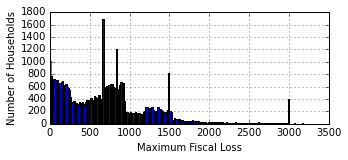

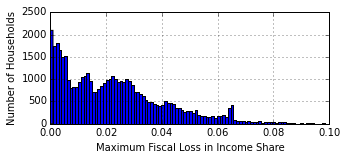

In [113]:
#Histogramme de la plus grosse perte fiscale possible
plt.figure(figsize=(5,2))
(df2013_A[filter_pay_tax].result_max_allocation - df2013_A[filter_pay_tax].result_min_allocation).hist(bins = 1000)
plt.xlim(0,3500); 
plt.ylabel("Number of Households", )
plt.xlabel("Maximum Fiscal Loss")

#Histogramme de la plus grosse perte fiscale possible
plt.figure(figsize=(5,2))


maximum_fiscal_loss_in_share_of_RNI[(maximum_fiscal_loss_in_share_of_RNI>0)& (maximum_fiscal_loss_in_share_of_RNI<0.1)].hist(bins = 100)
plt.ylabel("Number of Households",)
plt.xlabel("Maximum Fiscal Loss in Income Share",)
plt.xlim(0,0.1); 

In [114]:
(maximum_fiscal_loss_in_share_of_RNI[maximum_fiscal_loss_in_share_of_RNI>0.0]>0.01).mean()

0.7035042753451507

In [115]:
(maximum_fiscal_loss_in_share_of_RNI>0.0).mean()

0.88713313971262608

In [116]:
maximum_fiscal_loss_in_share_of_RNI.mean()

0.021397781230412666

In [117]:
maximum_fiscal_loss_in_share_of_RNI.median()

0.017226744961964507

In [118]:
print (maximum_fiscal_loss_in_share_of_RNI>0.005).value_counts(normalize = True)
print (maximum_fiscal_loss_in_share_of_RNI>0.01).value_counts(normalize = True)

True    0.72
False   0.28
dtype: float64
True    0.62
False   0.38
dtype: float64


### Number of optimal allocations

In [119]:
df_A.Number_of_optimal_allocations_2013.value_counts() #Errors for 36 and 12, checked the other situations seems ok.

1.00     32081
2.00      3845
3.00      1761
4.00       342
5.00       171
6.00        22
7.00        21
36.00        4
12.00        2
dtype: int64

In [120]:
df2013_A.Number_of_optimal_allocations.value_counts()

1.00     43406
2.00      5562
3.00      2546
4.00       488
5.00       251
7.00        38
6.00        35
12.00        4
18.00        2
16.00        2
14.00        2
dtype: int64

#### 2013

In [121]:
df_temp = df2013_A[df2013_A.Number_of_optimal_allocations<12]
df_child_number = pd.DataFrame()
for child in range(1,7):
    for number_of_alloc in range(1,8):
        df_child_number.loc[child, number_of_alloc] = (df_temp.query("Nb_enfants == {}".format(child)).Number_of_optimal_allocations == number_of_alloc).sum()
df_child_number      

,1,2,3,4,5,6,7
1,24540.00,3140.00,0.00,0.00,0.00,0.00,0.00
2,17021.00,1882.00,2113.00,2.00,0.00,2.00,0.00
3,1526.00,357.00,264.00,353.00,0.00,0.00,0.00
4,302.00,174.00,148.00,111.00,234.00,0.00,0.00
5,9.00,4.00,13.00,5.00,1.00,16.00,0.00
6,8.00,5.00,8.00,17.00,16.00,17.00,38.00


In [122]:
df_temp = df2013_A[df2013_A.Number_of_optimal_allocations<12]
df_child_number = pd.DataFrame()
for child in range(1,7):
    for number_of_alloc in range(1,8):
        df_child_number.loc[child, number_of_alloc] = (df_temp.query("Nb_enfants == {}".format(child)).Number_of_optimal_allocations == number_of_alloc).sum()/ len(df_temp.query("Nb_enfants == {}".format(child)))*100
        

In [123]:
df_child_number.index.name = 'Number of children'
df_child_number.axes[1].name = "Number of optimal allocations"
df_child_number.loc[2,4] = 0 # On vire les 4 ménages de deux enfants qui ont 4 ou 6 allocations optimales (do not know where it comes from)
df_child_number.loc[2,6] = 0 

df_child_number["Total"] = [ len(df_temp.query("Nb_enfants == {}".format(child))) for child in range(1,7)]
df_child_number.loc["Total" ] = [len(df_temp.query("Number_of_optimal_allocations == {}".format(number_of_alloc))) for number_of_alloc in range(1,8)] + [df_child_number["Total"].sum()]
df_child_number.loc["Share"] = df_child_number.loc["Total"]/df_child_number.loc["Total", "Total"]
df_child_number.replace(0, "")

Number of optimal allocations,1,2,3,4,5,6,7,Total
Number of children,,,,,,,,
1,88.66,11.34,,,,,,27680.00
2,80.98,8.95,10.05,,,,,21020.00
3,61.04,14.28,10.56,14.12,,,,2500.00
4,31.17,17.96,15.27,11.46,24.15,,,969.00
5,18.75,8.33,27.08,10.42,2.08,33.33,,48.00
6,7.34,4.59,7.34,15.60,14.68,15.60,34.86,109.00
Total,43406.00,5562.00,2546.00,488.00,251.00,35.00,38.00,52326.00
Share,0.83,0.11,0.05,0.01,0.00,0.00,0.00,1.00


In [124]:
df_temp = df2013_A[df2013_A.Number_of_optimal_allocations<12]

df_child_number = pd.DataFrame()
for child in range(1,7):
    for number_of_alloc in range(1,8):
        df_child_number.loc[child, number_of_alloc] = (df_temp.query("Nb_enfants == {}".format(child)).Number_of_optimal_allocations == number_of_alloc).sum()/ len(df_temp.query("Nb_enfants == {}".format(child)))*100
        
df_child_number.index.name = 'Number of children'
df_child_number.axes[1].name = "Number of optimal allocations"
df_child_number.loc[2,4] = 0 # On vire les 4 ménages de deux enfants qui ont 4 ou 6 allocations optimales (do not know where it comes from)
df_child_number.loc[2,6] = 0 




df_child_number["Total"] = [ len(df_temp.query("Nb_enfants == {}".format(child))) for child in range(1,7)]
df_child_number.loc["Total" ] = [len(df_temp.query("Number_of_optimal_allocations == {}".format(number_of_alloc))) for number_of_alloc in range(1,8)] + [df_child_number["Total"].sum()]
df_child_number.loc["Share"] = df_child_number.loc["Total"]/df_child_number.loc["Total", "Total"]
df_child_number.replace(0, "")

Number of optimal allocations,1,2,3,4,5,6,7,Total
Number of children,,,,,,,,
1,88.66,11.34,,,,,,27680.00
2,80.98,8.95,10.05,,,,,21020.00
3,61.04,14.28,10.56,14.12,,,,2500.00
4,31.17,17.96,15.27,11.46,24.15,,,969.00
5,18.75,8.33,27.08,10.42,2.08,33.33,,48.00
6,7.34,4.59,7.34,15.60,14.68,15.60,34.86,109.00
Total,43406.00,5562.00,2546.00,488.00,251.00,35.00,38.00,52326.00
Share,0.83,0.11,0.05,0.01,0.00,0.00,0.00,1.00


### PACS

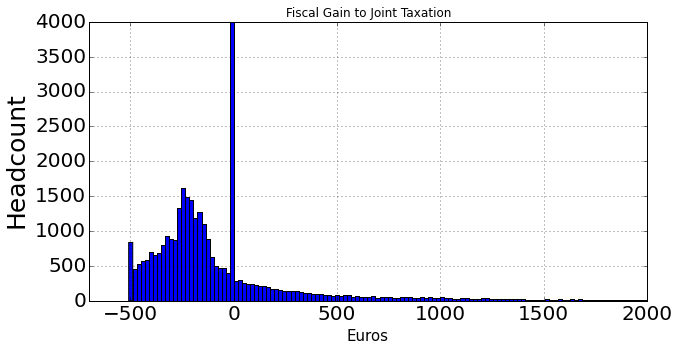

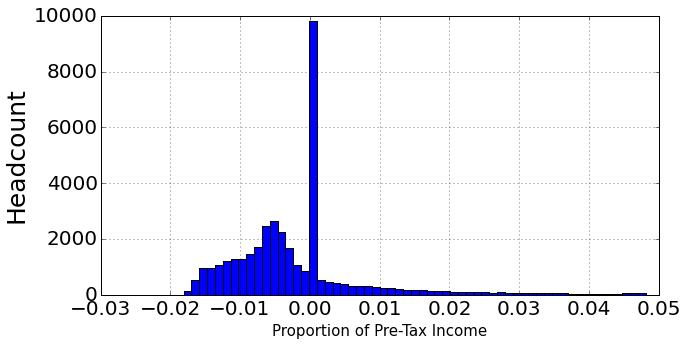

In [125]:
plt.figure(figsize=(10,5))
plt.rc("xtick", labelsize = 20)
plt.rc("ytick", labelsize = 20)
(df_A.result_min_allocation_2013 - df_A.Irpp_decote_pacs).hist(bins =900)
plt.xlim(-700,2000)
plt.ylim(0,4000)
plt.ylabel("Headcount", fontsize = 25); plt.xlabel("Euros", fontsize = 15)
plt.title("Fiscal Gain to Joint Taxation")
#In share of income
plt.figure(figsize=(10,5))
plt.rc("xtick", labelsize = 20)
plt.rc("ytick", labelsize = 20)
((df_A.result_min_allocation_2013 - df_A.Irpp_decote_pacs)/df_A.Rni_2013).hist(bins =10000)
plt.xlim(-0.03,0.05)
#plt.ylim(0,4000)
plt.ylabel("Headcount", fontsize = 25); plt.xlabel("Proportion of Pre-Tax Income", fontsize = 15)


In [126]:
print ((df2013_A.result_min_allocation- df2013_A.Irpp_decote_pacs)>20).value_counts(normalize = True)### gagnent au pacs
print ((df2013_A.result_min_allocation - df2013_A.Irpp_decote_pacs)<-20).value_counts(normalize = True)#perdent au pacs
print (np.abs((df2013_A.result_min_allocation - df2013_A.Irpp_decote_pacs))<20).value_counts(normalize = True)#neutre 

False   0.82
True    0.18
dtype: float64
True    0.55
False   0.45
dtype: float64
False   0.72
True    0.28
dtype: float64


Most households in the sample would loose to joint taxation.

In [127]:
%%time
i = 0
two_smallest_difference = np.array([])
for df_temp in [df2013_A]:
    for series in df_temp[["Irpp_decote_allocation_{}".format(alloc_nb) for alloc_nb in range(1,9)]].iterrows():
        two_smallest_allocations =  series[1].nsmallest(2)
        i+=1
        two_smallest_difference = np.append(two_smallest_difference,  two_smallest_allocations[0] - two_smallest_allocations[1]) 
    df_temp["Two_smallest_allocation_difference"] = -pd.Series(two_smallest_difference)


Wall time: 20.7 s


# Impôt (stat des)

In [128]:
df2013_A.Irpp_decote.describe()

count     52336.00
mean       2064.57
std        8584.58
min           0.00
25%          87.23
50%         891.90
75%        2177.49
max     1367912.93
Name: Irpp_decote, dtype: float64

In [129]:
print (df2013_A.Irpp_decote<1).value_counts(normalize = True)
print (df2013_A.Irpp_decote<1).value_counts(normalize = False)

False   0.79
True    0.21
dtype: float64
False    41427
True     10909
dtype: int64


In [130]:
df2013_A[df2013_A.Irpp_decote>0].Irpp_decote.describe()

count     41449.00
mean       2606.86
std        9572.80
min           0.05
25%         513.74
50%        1336.48
75%        2620.90
max     1367912.93
Name: Irpp_decote, dtype: float64

(0, 0.4)

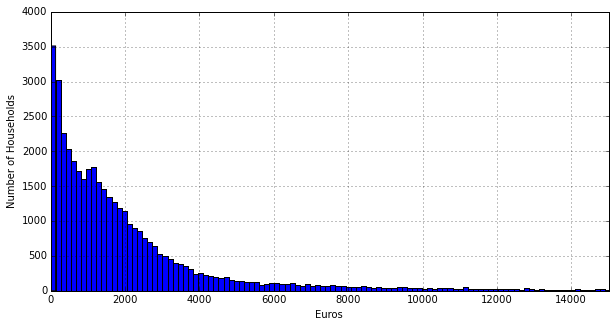

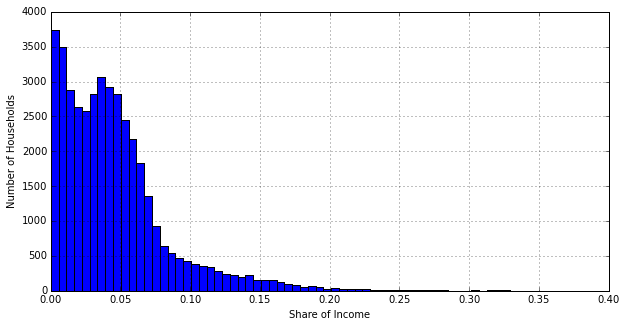

In [131]:
plt.figure(figsize = (10,5))
plt.rc("xtick", labelsize = 10)
plt.rc("ytick", labelsize = 10)
df2013_A[df2013_A.Irpp_decote>0].Irpp_decote.hist(bins = 10000)
plt.xlabel("Euros", fontsize = 10); plt.ylabel("Number of Households", fontsize = 10)
plt.xlim(1,15000)

plt.figure(figsize = (10,5))
plt.rc("xtick", labelsize = 10)
plt.rc("ytick", labelsize = 10)
(df2013_A[df2013_A.Irpp_decote>0].Irpp_decote/df2013_A[df2013_A.Irpp_decote>0].Rni).hist(bins = 5000)
plt.xlabel("Share of Income", fontsize = 10); plt.ylabel("Number of Households", fontsize = 10)
plt.xlim(0,0.4)

### Do not optimize stat des

#### 2013

In [132]:
for key, df_temp in {"All": df2013_A, "Can optimize": df2013_B, "Unique opt allocation": df2013_D, }.iteritems(): #[df2014_B.Two_smallest_allocation_difference !=0]
    print key + "\n"            
    print df_temp.Do_not_optimize.value_counts(normalize = True)[True]
    print df_temp.Do_not_optimize_1_prct_income_share.value_counts(normalize = True)[True]
    print df_temp.shape[0]

Unique opt allocation

0.291837486757
0.0956055092358
43418
All

0.248624273922
0.0826773158056
52336
Can optimize

0.280153296301
0.0931619515136
46446


In [133]:
df_temp.Do_not_optimize_1_prct_income_share.value_counts(normalize = True).loc[True]

0.093161951513585667

In [134]:
for number_of_optimal_allocation in range(1,5):
    filter_ = df2013_B.Number_of_optimal_allocations == number_of_optimal_allocation
    df_temp = df2013_B[filter_]
    print str(number_of_optimal_allocation) + "\n"            
    print 1-df_temp.Do_not_optimize.value_counts(normalize = True)[False]
    print 1-df_temp.Do_not_optimize_1_prct_income_share.value_counts(normalize = True)[False]
    print df_temp.shape[0]

1

0.291826014837
0.0955858637055
43406
2

0.131687242798
0.0670781893004
2430
3

0.0508083140878
0.0323325635104
433
4

0.0148148148148
0.0
135


In [135]:
#### 2014

In [136]:
for key, df_temp in {"All": df2014_A, "Can optimize": df2014_B, "Unique opt allocation": df2014_D}.iteritems(): #[df2014_B.Two_smallest_allocation_difference !=0]
    print key + "\n"            
    print df_temp.Do_not_optimize.value_counts(normalize = True)[True]
    print df_temp.Do_not_optimize_1_prct_income_share.value_counts(normalize = True)[True]
    print df_temp.shape[0]

Unique opt allocation

0.287732416631
0.126790956766
39853
All

0.218603280982
0.0983005910187
54313
Can optimize

0.258823272949
0.116386545462
45873


###### 2013 With diplomas

In [137]:
for key, df_temp in {"All": df2013_A, "Can optimize": df2013_B, "Unique opt allocation": df2013_D, }.iteritems(): #[df2014_B.Two_smallest_allocation_difference !=0]
    print key             
    df_temp = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2] 
    print df_temp.Do_not_optimize.value_counts(normalize = True)[True]
    print df_temp.Do_not_optimize_1_prct_income_share.value_counts(normalize = True)[True]
    print df_temp.shape[0]

Unique opt allocation
0.290016968326
0.0911340497738
28288
All
0.254085461808
0.0810434572086
33044
Can optimize
0.278909078829
0.0889612330997
30103


###### 2014 With diplomas

In [138]:
for key, df_temp in {"All": df2014_A, "Can optimize": df2014_B, "Unique opt allocation": df2014_D}.iteritems(): #[df2014_B.Two_smallest_allocation_difference !=0]
    print key
    df_temp = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2] 
    print df_temp.Do_not_optimize.value_counts(normalize = True)[True]
    print df_temp.Do_not_optimize_1_prct_income_share.value_counts(normalize = True)[True]
    print df_temp.shape[0]

Unique opt allocation
0.299881020123
0.12673943407
19331
All
0.239304333983
0.1034743503
25127
Can optimize
0.268521412942
0.116107712232
22393


In [139]:
df2013_A.Do_not_optimize.value_counts(normalize = True)

False   0.75
True    0.25
dtype: float64

In [140]:
df2013_B.Do_not_optimize.value_counts(normalize = True)

False   0.72
True    0.28
dtype: float64

#### Fiscal loss

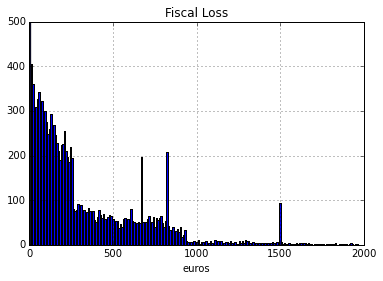

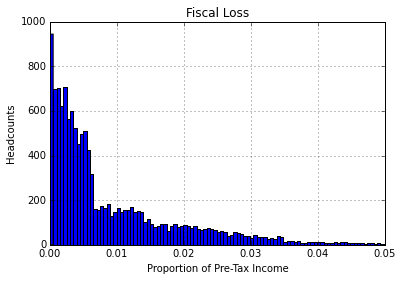

In [141]:
plt.figure()
df2013_B.Fiscal_loss.hist(bins = 1000)
plt.xlim(0,2000)
plt.ylim(0,500); plt.xlabel("euros")
plt.title("Fiscal Loss")
## In share of income

plt.figure()
df2013_B["Fiscal_loss_in_share_of_income"] = (df2013_B.Fiscal_loss/df2013_B.Rni)
df2013_B.query("0.05>Fiscal_loss_in_share_of_income>0").Fiscal_loss_in_share_of_income.hist(bins = 100)
plt.xlabel("Proportion of Pre-Tax Income"); plt.ylabel("Headcounts")
plt.title("Fiscal Loss")

### Potential Maximal Fiscal loss + actual fiscal loss in share of income (article graph)

In [142]:
def tex_font(string = None):
    string = "$"+string+"$"
    return string.replace(" ", "\,")
    

In [143]:
plt.rc("xtick", labelsize = 20)
plt.rc("ytick", labelsize = 20)

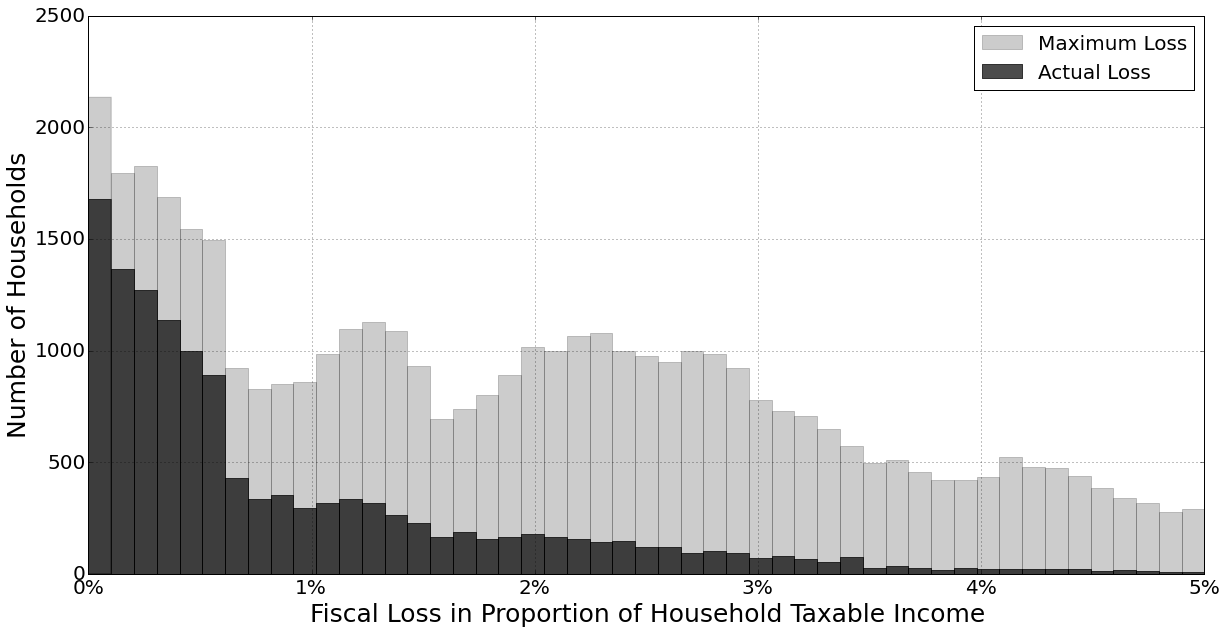

In [144]:
## To put in article

plt.figure(figsize=(20,10))
bins = np.linspace(0,0.05,50)

maximum_fiscal_loss_in_share_of_RNI = ((df2013_B.result_max_allocation - df2013_B.result_min_allocation)/df2013_B.Rni)
maximum_fiscal_loss_in_share_of_RNI[(maximum_fiscal_loss_in_share_of_RNI>0)& (maximum_fiscal_loss_in_share_of_RNI<0.1)].hist(bins = bins, color = 'k', alpha = 0.2, label = "Maximum Loss")
df2013_B.query("0.1>Fiscal_loss_in_share_of_income>0").Fiscal_loss_in_share_of_income.hist(bins = bins, color = "k", alpha = 0.7, label = "Actual Loss")
plt.ylabel("Number of Households", fontsize = 25)
plt.xlabel("Fiscal Loss in Proportion of Household Taxable Income", fontsize = 25)
plt.xlim(0,0.05) ; plt.legend( fontsize = 20)
plt.gca().set_xticklabels([u"{:.0f}%".format(x*100) for x in plt.gca().get_xticks()])

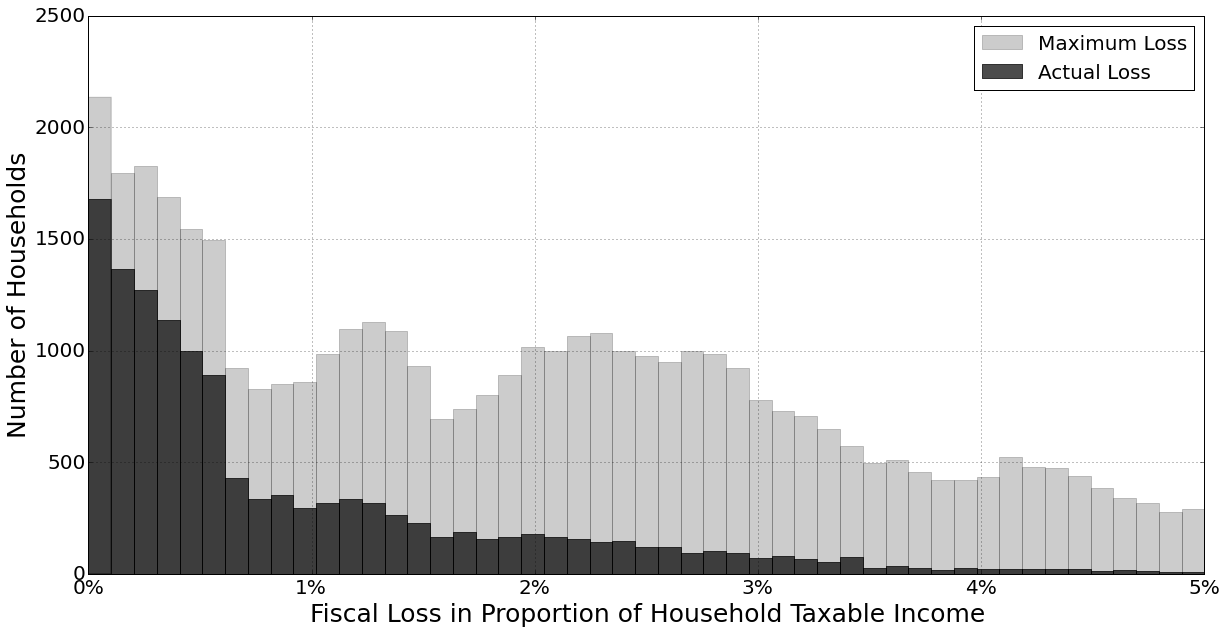

In [145]:
## To put in article

plt.figure(figsize=(20,10))
bins = np.linspace(0,0.05,50)

maximum_fiscal_loss_in_share_of_RNI = ((df2013_B.result_max_allocation - df2013_B.result_min_allocation)/df2013_B.Rni)
maximum_fiscal_loss_in_share_of_RNI[(maximum_fiscal_loss_in_share_of_RNI>0)& (maximum_fiscal_loss_in_share_of_RNI<0.1)].hist(bins = bins, color = 'k', alpha = 0.2, label = "Maximum Loss")
df2013_B.query("0.1>Fiscal_loss_in_share_of_income>0").Fiscal_loss_in_share_of_income.hist(bins = bins, color = "k", alpha = 0.7, label = "Actual Loss")
plt.ylabel("Number of Households", fontsize = 25)
plt.xlabel("Fiscal Loss in Proportion of Household Taxable Income", fontsize = 25)
plt.xlim(0,0.05) ; plt.legend( fontsize = 20)
plt.gca().set_xticklabels([u"{:.0f}%".format(x*100) for x in plt.gca().get_xticks()])

## Make other graphs

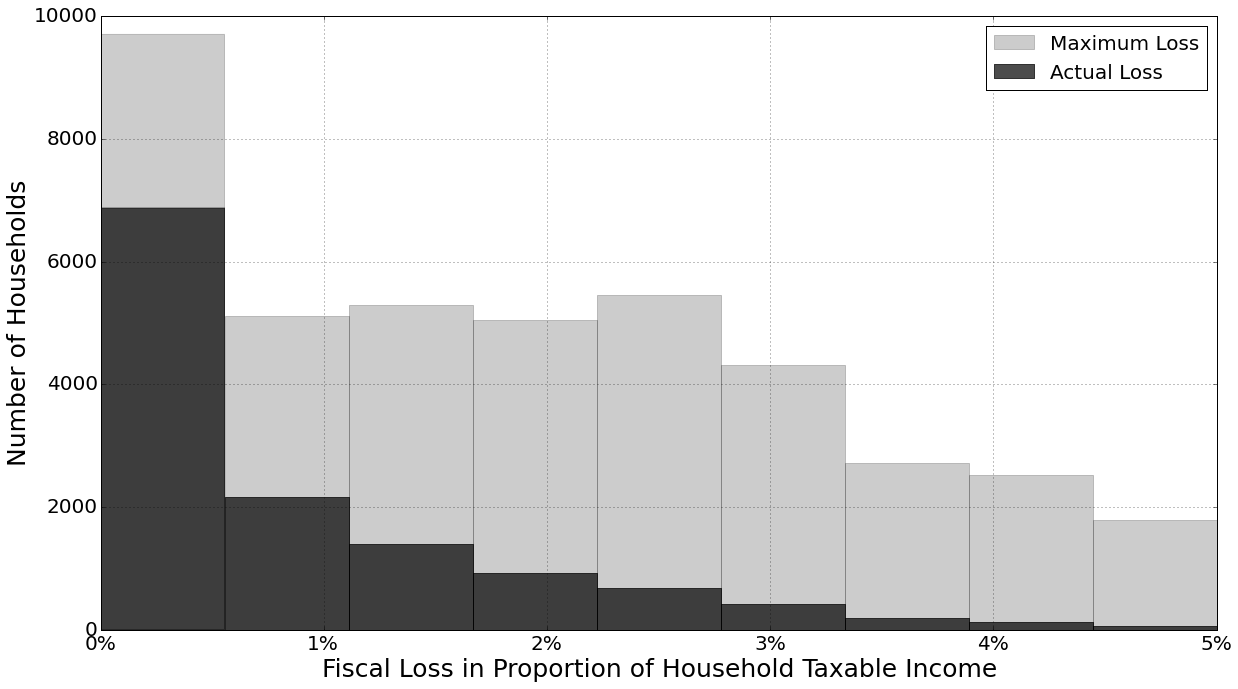

In [146]:
## To put in article

plt.figure(figsize=(20,11))
bins = np.linspace(0,0.05,10)
maximum_fiscal_loss_in_share_of_RNI = ((df2013_B.result_max_allocation - df2013_B.result_min_allocation)/df2013_B.Rni)
maximum_fiscal_loss_in_share_of_RNI[(maximum_fiscal_loss_in_share_of_RNI>0)& (maximum_fiscal_loss_in_share_of_RNI<0.1)].hist(bins = bins, color = 'k', alpha = 0.2, label = "Maximum Loss")
df2013_B.query("0.1>Fiscal_loss_in_share_of_income>0").Fiscal_loss_in_share_of_income.hist(bins = bins, color = "k", alpha = 0.7, label = "Actual Loss")
plt.ylabel("Number of Households", fontsize = 25)
plt.xlabel("Fiscal Loss in Proportion of Household Taxable Income", fontsize = 25)
plt.xlim(0,0.05) ; plt.legend( fontsize = 20)
plt.gca().set_xticklabels([u"{:.0f}%".format(x*100) for x in plt.gca().get_xticks()])

In [147]:
3

3

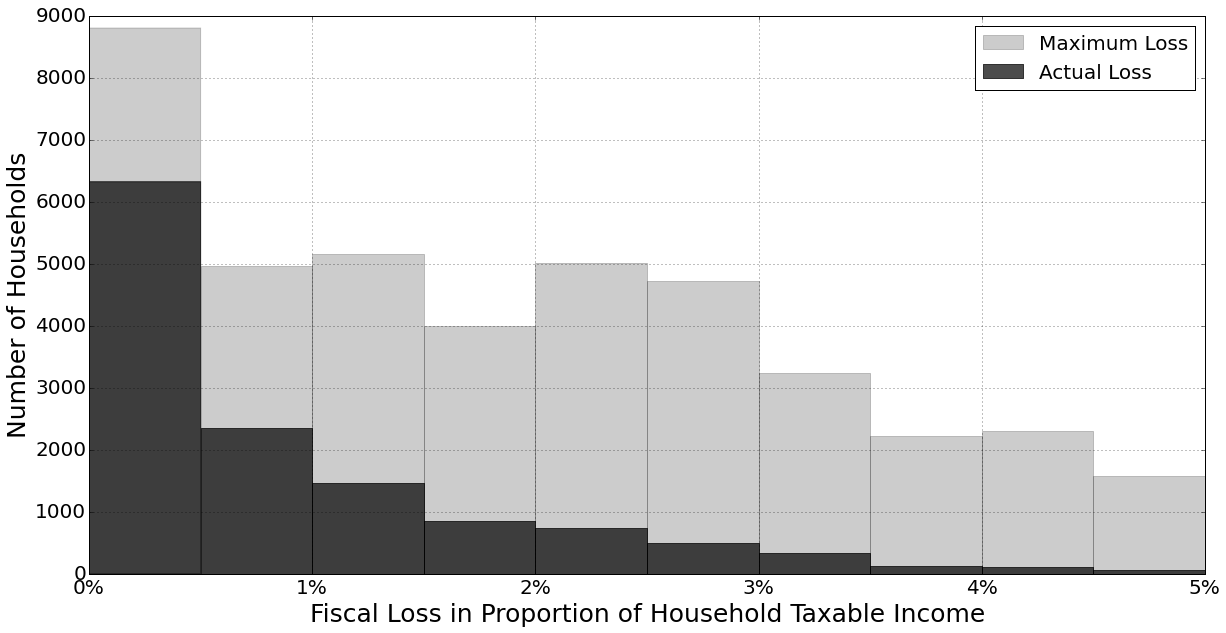

In [148]:
## To put in article

plt.figure(figsize=(20,10))
bins = np.linspace(0,0.05,11)
maximum_fiscal_loss_in_share_of_RNI = ((df2013_B.result_max_allocation - df2013_B.result_min_allocation)/df2013_B.Rni)
maximum_fiscal_loss_in_share_of_RNI[(maximum_fiscal_loss_in_share_of_RNI>0)& (maximum_fiscal_loss_in_share_of_RNI<0.1)].hist(bins = bins, color = 'k', alpha = 0.2, label = "Maximum Loss")
df2013_B.query("0.1>Fiscal_loss_in_share_of_income>0").Fiscal_loss_in_share_of_income.hist(bins = bins, color = "k", alpha = 0.7, label = "Actual Loss")
plt.ylabel("Number of Households", fontsize = 25)
plt.xlabel("Fiscal Loss in Proportion of Household Taxable Income", fontsize = 25)
plt.xlim(0,0.05) ; plt.legend( fontsize = 20)
plt.gca().set_xticklabels([u"{:.0f}%".format(x*100) for x in plt.gca().get_xticks()])

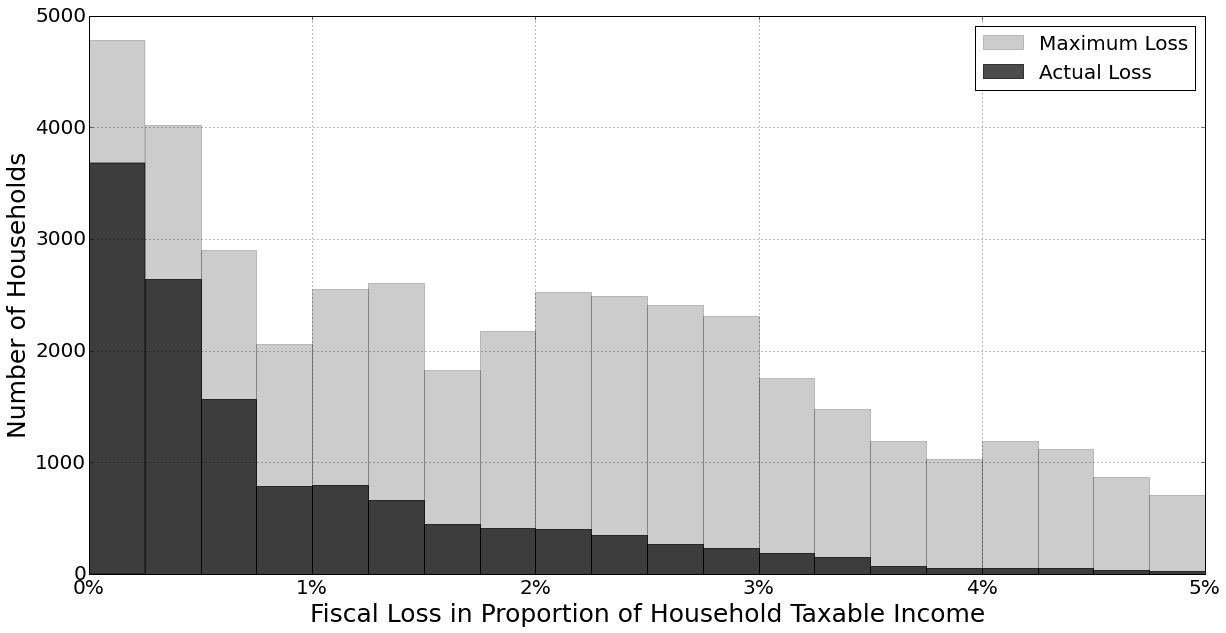

In [149]:
## To put in article

plt.figure(figsize=(20,10))
bins = np.linspace(0,0.05,21)
maximum_fiscal_loss_in_share_of_RNI = ((df2013_B.result_max_allocation - df2013_B.result_min_allocation)/df2013_B.Rni)
maximum_fiscal_loss_in_share_of_RNI[(maximum_fiscal_loss_in_share_of_RNI>0)& (maximum_fiscal_loss_in_share_of_RNI<0.1)].hist(bins = bins, color = 'k', alpha = 0.2, label = "Maximum Loss")
df2013_B.query("0.1>Fiscal_loss_in_share_of_income>0").Fiscal_loss_in_share_of_income.hist(bins = bins, color = "k", alpha = 0.7, label = "Actual Loss")
plt.ylabel("Number of Households", fontsize = 25)
plt.xlabel("Fiscal Loss in Proportion of Household Taxable Income", fontsize = 25)
plt.xlim(0,0.05) ; plt.legend( fontsize = 20)
plt.gca().set_xticklabels([u"{:.0f}%".format(x*100) for x in plt.gca().get_xticks()])

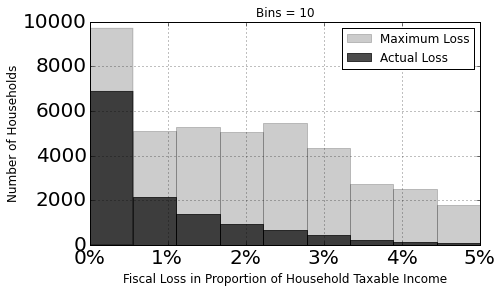

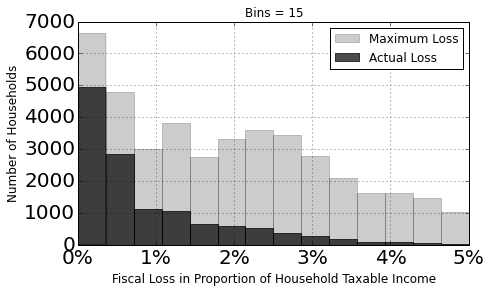

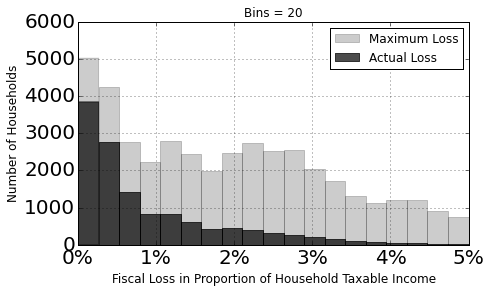

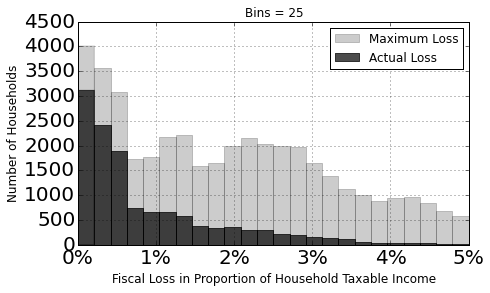

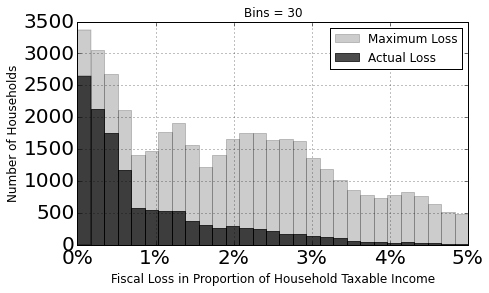

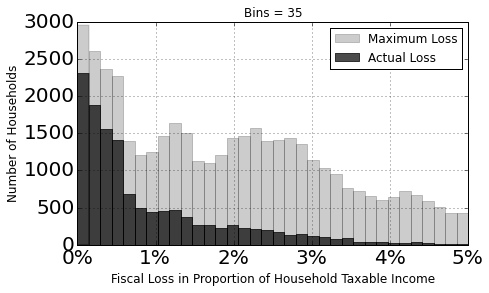

In [150]:

fontsize = 12

for bins_number in [10,15,20,25,30,35]:
    
    plt.figure(figsize=(7,4))
    bins = np.linspace(0,0.05,bins_number)
    maximum_fiscal_loss_in_share_of_RNI = ((df2013_B.result_max_allocation - df2013_B.result_min_allocation)/df2013_B.Rni)
    maximum_fiscal_loss_in_share_of_RNI[(maximum_fiscal_loss_in_share_of_RNI>0)& (maximum_fiscal_loss_in_share_of_RNI<0.1)].hist(bins = bins, color = 'k', alpha = 0.2, label = "Maximum Loss")
    df2013_B.query("0.1>Fiscal_loss_in_share_of_income>0").Fiscal_loss_in_share_of_income.hist(bins = bins, color = "k", alpha = 0.7, label = "Actual Loss")
    plt.ylabel("Number of Households", fontsize = fontsize)
    plt.xlabel("Fiscal Loss in Proportion of Household Taxable Income", fontsize =fontsize)
    plt.xlim(0,0.05) ; plt.legend( fontsize = fontsize)
    plt.gca().set_xticklabels([u"{:.0f}%".format(x*100) for x in plt.gca().get_xticks()])
    plt.title("Bins = {}".format(bins_number))

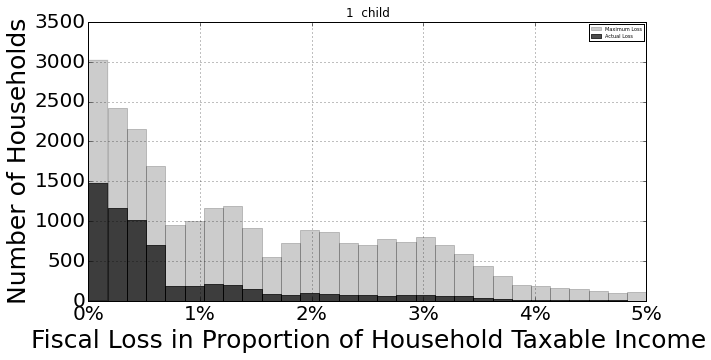

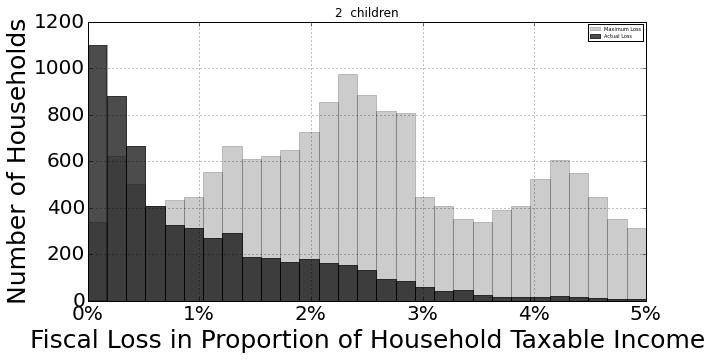

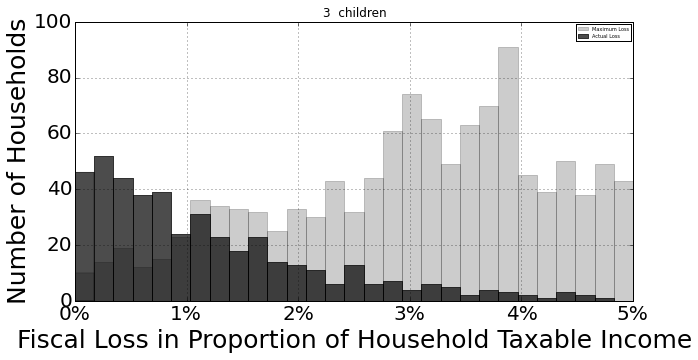

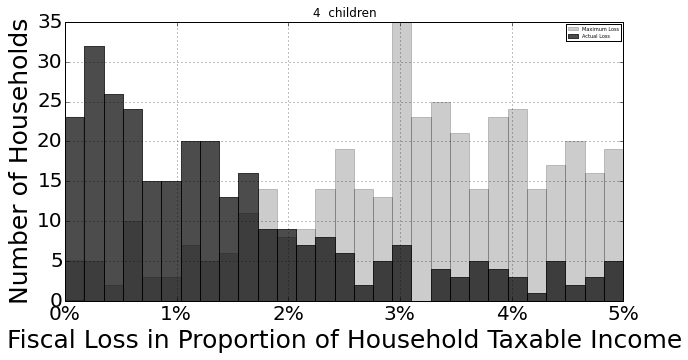

In [151]:
## To put in article
bins = np.linspace(0,0.05,30)
for nb_enfants in range(1,5):
    plt.figure(figsize=(10,5))
    maximum_fiscal_loss_in_share_of_RNI = ((df2013_B.query("(Nb_enfants == {})".format(nb_enfants)).result_max_allocation - df2013_B.query("(Nb_enfants == {})".format(nb_enfants)).result_min_allocation)/df2013_B.query("(Nb_enfants == {})".format(nb_enfants)).Rni)
    maximum_fiscal_loss_in_share_of_RNI[(maximum_fiscal_loss_in_share_of_RNI>0)& (maximum_fiscal_loss_in_share_of_RNI<0.1)].hist(bins = bins, color = 'k', alpha = 0.2, label = "Maximum Loss")
    df2013_B.query("0.1>Fiscal_loss_in_share_of_income>0 & (Nb_enfants == {})".format(nb_enfants)).Fiscal_loss_in_share_of_income.hist(bins = bins, color = "k", alpha = 0.7, label = "Actual Loss")
    plt.ylabel("Number of Households", fontsize = 25)
    plt.xlabel("Fiscal Loss in Proportion of Household Taxable Income", fontsize = 25)
    plt.xlim(0,0.05) ; plt.legend( fontsize = 5)
    plt.title(("{}  children".format(nb_enfants) *( nb_enfants>1)) +("{}  child".format(nb_enfants) *( nb_enfants==1)))
    plt.gca().set_xticklabels([u"{:.0f}%".format(x*100) for x in plt.gca().get_xticks()])

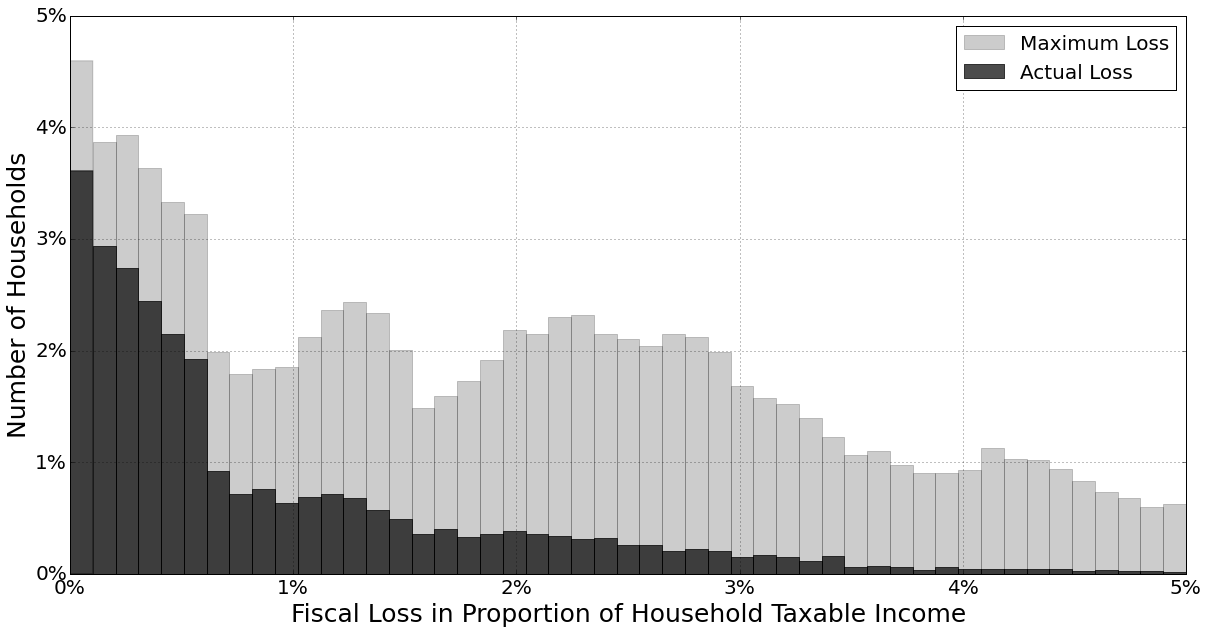

In [152]:
# ## To put in article

plt.figure(figsize=(20,10))
bins = np.linspace(0,0.05,50)






maximum_fiscal_loss_in_share_of_RNI = ((df2013_B.result_max_allocation - df2013_B.result_min_allocation)/df2013_B.Rni)


weights_1 = (np.ones(len( maximum_fiscal_loss_in_share_of_RNI[(maximum_fiscal_loss_in_share_of_RNI>0)
            & (maximum_fiscal_loss_in_share_of_RNI<0.1)]))
             /len( df2013_B))
maximum_fiscal_loss_in_share_of_RNI[(maximum_fiscal_loss_in_share_of_RNI>0)& (maximum_fiscal_loss_in_share_of_RNI<0.1)
                                   ].hist(bins = bins, weights = weights_1,
                                          color = 'k', alpha = 0.2, label = "Maximum Loss")
weights_2 = np.ones(len(df2013_B.query("0.1>Fiscal_loss_in_share_of_income>0")))/ len( df2013_B)
df2013_B.query("0.1>Fiscal_loss_in_share_of_income>0").Fiscal_loss_in_share_of_income.hist(
    bins = bins, weights = weights_2,
    color = "k", alpha = 0.7, label = "Actual Loss")
plt.ylabel("Number of Households", fontsize = 25)
plt.xlabel("Fiscal Loss in Proportion of Household Taxable Income", fontsize = 25)
plt.xlim(0,0.05) ; plt.legend( fontsize = 20)
plt.gca().set_xticklabels([u"{:.0f}%".format(x*100) for x in plt.gca().get_xticks()])
plt.gca().set_yticklabels([u"{:.0f}%".format(y*100) for y in plt.gca().get_yticks()])

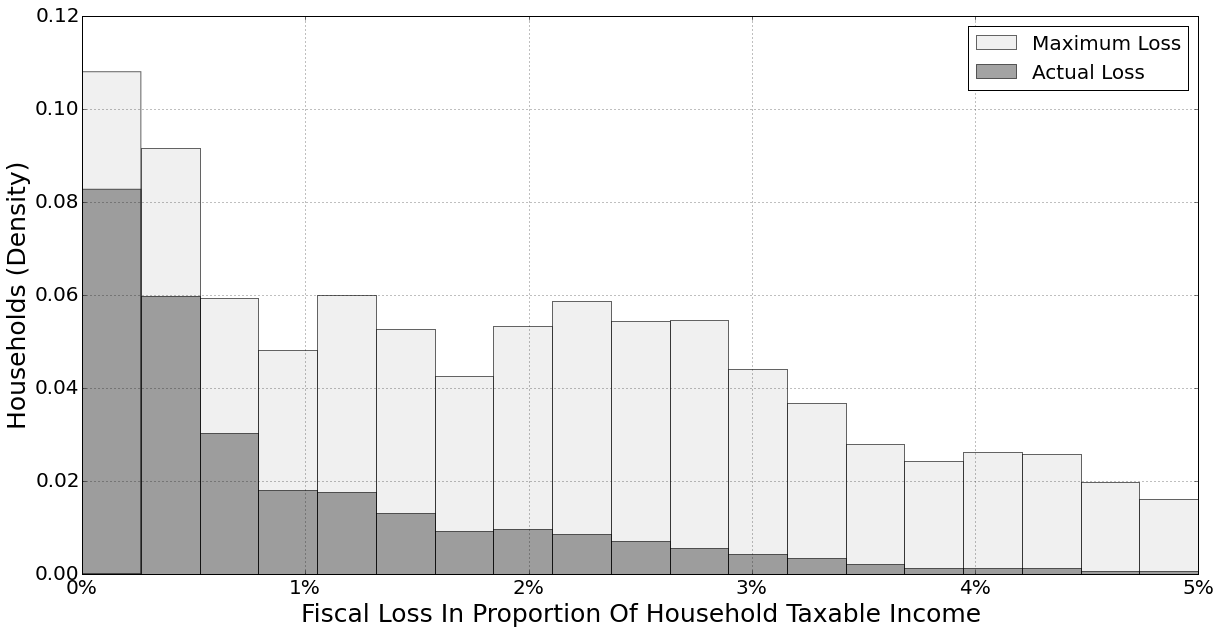

In [153]:
## To put in article
try : 
    plt.figure(figsize=(20,10))
    bins = np.linspace(0,0.05,20)


    




    maximum_fiscal_loss_in_share_of_RNI = ((df2013_B.result_max_allocation - df2013_B.result_min_allocation)/df2013_B.Rni)
    
    weights_1 = (np.ones(len( maximum_fiscal_loss_in_share_of_RNI[(maximum_fiscal_loss_in_share_of_RNI>0)
                & (maximum_fiscal_loss_in_share_of_RNI<0.1)]))
                 /len( df2013_B))
    maximum_fiscal_loss_in_share_of_RNI[(maximum_fiscal_loss_in_share_of_RNI>0)& (maximum_fiscal_loss_in_share_of_RNI<0.1)
                                       ].hist(bins = bins, weights = weights_1,
                                              color = "0.9", alpha = 0.6, label = "Maximum Loss")
    weights_2 = np.ones(len(df2013_B.query("0.1>Fiscal_loss_in_share_of_income>0")))/ len( df2013_B)
    df2013_B.query("0.1>Fiscal_loss_in_share_of_income>0").Fiscal_loss_in_share_of_income.hist(
        bins = bins, weights = weights_2,
        color = "0.4", alpha = 0.6, label = "Actual Loss")
    plt.ylabel("Households (Density)", fontsize = 25)
    plt.xlabel("Fiscal Loss In Proportion Of Household Taxable Income", fontsize = 25)
    plt.xlim(0,0.05) ; plt.legend( fontsize = 20)
    plt.gca().set_xticklabels([u"{:.0f}%".format(x*100) for x in plt.gca().get_xticks()])
except:
    plt.figure(figsize=(20,10))
    bins = np.linspace(0,0.05,20)


    weights_1 = (np.ones(len( maximum_fiscal_loss_in_share_of_RNI[(maximum_fiscal_loss_in_share_of_RNI>0)
                & (maximum_fiscal_loss_in_share_of_RNI<0.1)]))
                 /len( df2013_B))
    weights_2 = np.ones(len(df2013_B.query("0.1>Fiscal_loss_in_share_of_income>0")))/ len( df2013_B)




    maximum_fiscal_loss_in_share_of_RNI = ((df2013_B.result_max_allocation - df2013_B.result_min_allocation)/df2013_B.Rni)
    maximum_fiscal_loss_in_share_of_RNI[(maximum_fiscal_loss_in_share_of_RNI>0)& (maximum_fiscal_loss_in_share_of_RNI<0.1)
                                       ].hist(bins = bins, weights = weights_1,
                                              color = "0.9", alpha = 0.6, label = "Maximum Loss")
    df2013_B.query("0.1>Fiscal_loss_in_share_of_income>0").Fiscal_loss_in_share_of_income.hist(
        bins = bins, weights = weights_2,
        color = "0.4", alpha = 0.6, label = "Actual Loss")
    plt.ylabel("Households (Density)", fontsize = 25)
    plt.xlabel("Fiscal Loss In Proportion Of Household Taxable Income", fontsize = 25)
    plt.xlim(0,0.05) ; plt.legend( fontsize = 20)
    plt.gca().set_xticklabels([u"{:.0f}%".format(x*100) for x in plt.gca().get_xticks()])
    #plt.gca().set_yticklabels([u"{:.0f}%".format(y*100) for y in plt.gca().get_yticks()])

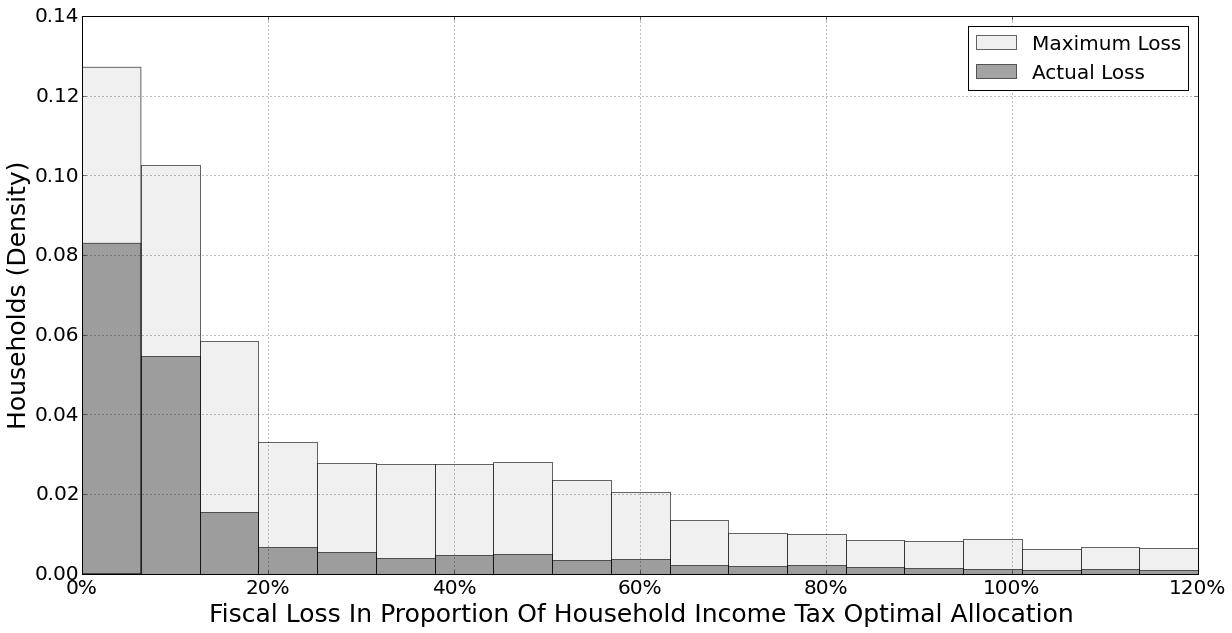

In [154]:
#In proportion of best allocation

df2013_B["Fiscal_loss_in_share_of_income_tax"] = df2013_B["Fiscal_loss"]/df2013_B["Irpp_decote"]
df2013_B["Fiscal_loss_in_share_of_best_allocation"] = df2013_B["Fiscal_loss"]/df2013_B["result_min_allocation"]
maximum_fiscal_loss_in_share_of_best_allocation = ((df2013_B.result_max_allocation - df2013_B.result_min_allocation)/df2013_B.result_min_allocation)


bins = np.linspace(0,1.2,20)


plt.figure(figsize=(20,10))
#bins = np.linspace(0,0.05,50)



weights_2 = np.ones(len(df2013_B.query("Fiscal_loss_in_share_of_best_allocation>0")))/ len( df2013_B)
weights_1 = (np.ones(len( maximum_fiscal_loss_in_share_of_best_allocation[(maximum_fiscal_loss_in_share_of_best_allocation>0)& 
                                                                          (maximum_fiscal_loss_in_share_of_best_allocation<1.5)]))
             /len( df2013_B))
hist_plt = maximum_fiscal_loss_in_share_of_best_allocation[(maximum_fiscal_loss_in_share_of_best_allocation>0)& (maximum_fiscal_loss_in_share_of_best_allocation<1.5)
                                                      ].hist(bins = bins, color = '0.9',weights = weights_1, alpha = 0.6, label = "Maximum Loss")
df2013_B.query("Fiscal_loss_in_share_of_best_allocation>0").Fiscal_loss_in_share_of_best_allocation.hist(bins = bins, color = "0.4", alpha = 0.6,
                                                                                                    weights = weights_2, label = "Actual Loss")
plt.ylabel("Households (Density)", fontsize = 25)
plt.xlabel("Fiscal Loss In Proportion Of Household Income Tax Optimal Allocation", fontsize = 25)
plt.gca().set_xticklabels([u"{:.0f}%".format(x*100) for x in plt.gca().get_xticks()])

#plt.gca().set_yticklabels([u"{:.0f}%".format(y*100) for y in plt.gca().get_yticks()])


plt.legend(fontsize=20)
percent = [i/len(df2013_B)]

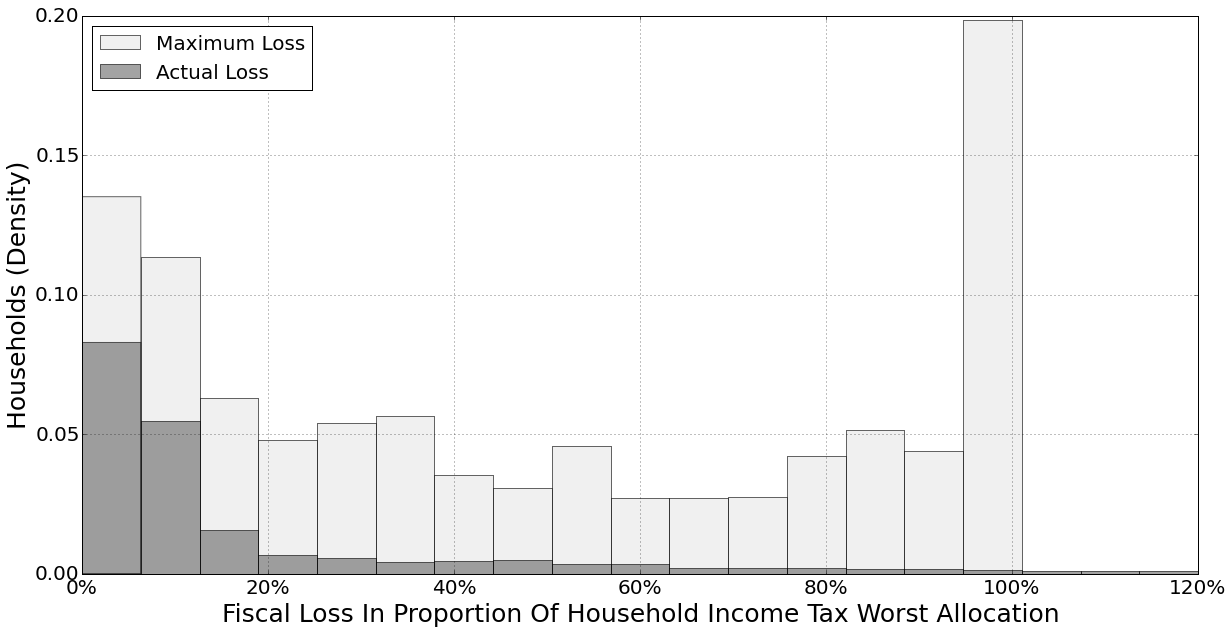

In [155]:
#In proportion of worst allocation

df2013_B["Fiscal_loss_in_share_of_worst_allocation"] = df2013_B["Fiscal_loss"]/df2013_B["result_min_allocation"]
maximum_fiscal_loss_in_share_of_worst_allocation = ((df2013_B.result_max_allocation - df2013_B.result_min_allocation)/df2013_B.result_max_allocation)


bins = np.linspace(0,1.2,20)


plt.figure(figsize=(20,10))
#bins = np.linspace(0,0.05,50)

weights_1 = (np.ones(len( maximum_fiscal_loss_in_share_of_worst_allocation[(maximum_fiscal_loss_in_share_of_worst_allocation>0)& 
                                                                          (maximum_fiscal_loss_in_share_of_worst_allocation<1.5)]))
             /len( df2013_B))

weights_2 = np.ones(len(df2013_B.query("Fiscal_loss_in_share_of_worst_allocation>0")))/ len( df2013_B)

hist_plt = maximum_fiscal_loss_in_share_of_worst_allocation[(maximum_fiscal_loss_in_share_of_worst_allocation>0)& (maximum_fiscal_loss_in_share_of_worst_allocation<1.5)
                                                      ].hist(bins = bins, color = '0.9',weights = weights_1, alpha = 0.6, label = "Maximum Loss")
df2013_B.query("Fiscal_loss_in_share_of_worst_allocation>0").Fiscal_loss_in_share_of_worst_allocation.hist(bins = bins, color = "0.4", alpha = 0.6,
                                                                                                    weights = weights_2, label = "Actual Loss")
plt.ylabel("Households (Density)", fontsize = 25)
plt.xlabel("Fiscal Loss In Proportion Of Household Income Tax Worst Allocation", fontsize = 25)
plt.gca().set_xticklabels([u"{:.0f}%".format(x*100) for x in plt.gca().get_xticks()])

#plt.gca().set_yticklabels([u"{:.0f}%".format(y*100) for y in plt.gca().get_yticks()])


plt.legend(fontsize=20, loc = 2)
percent = [i/len(df2013_B)]

In [156]:
weights_1.shape

(46446L,)

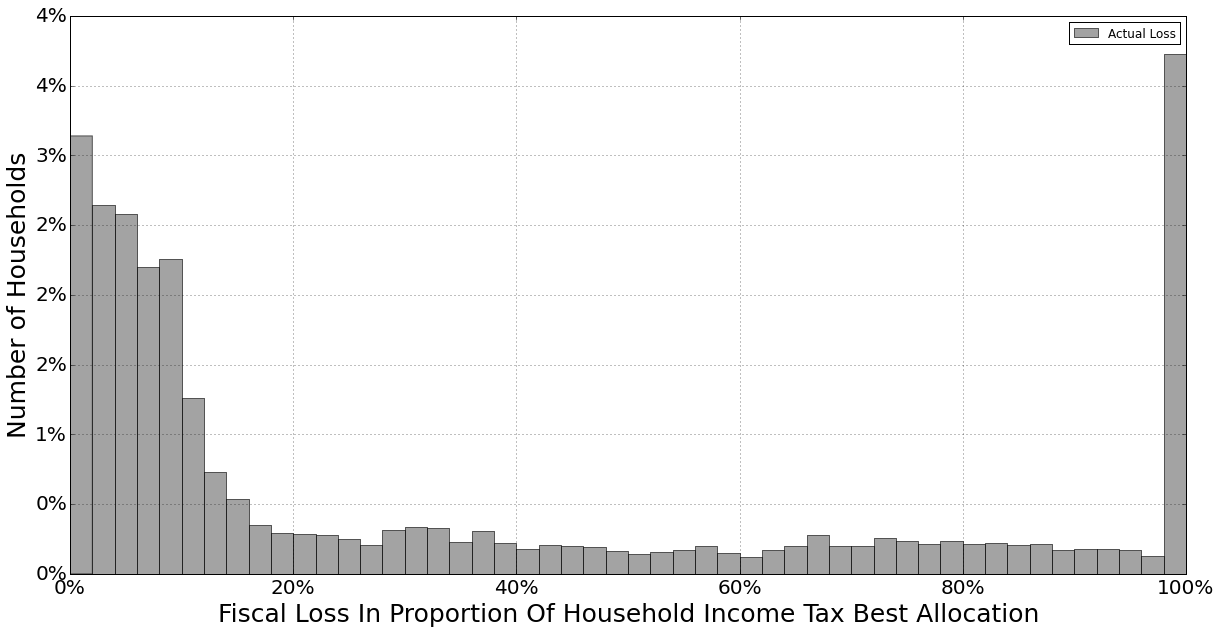

In [157]:
df2013_B["Fiscal_loss_in_share_of_income_tax"] = df2013_B["Fiscal_loss"]/df2013_B["Irpp_decote"]
df2013_B["Fiscal_loss_in_share_of_best_allocation"] = df2013_B["Fiscal_loss"]/df2013_B["result_min_allocation"]
maximum_fiscal_loss_in_share_of_best_allocation = ((df2013_B.result_max_allocation - df2013_B.result_min_allocation)/df2013_B.result_min_allocation)

bins = np.linspace(0,1.1,20)

plt.figure(figsize=(20,10))
#bins = np.linspace(0,0.05,50)

weights_1 = (np.ones(len( maximum_fiscal_loss_in_share_of_best_allocation[(maximum_fiscal_loss_in_share_of_best_allocation>0)& (maximum_fiscal_loss_in_share_of_best_allocation<1.1)]))
             /len( df2013_B))
weights_2 = np.ones(len(df2013_B.query("Fiscal_loss_in_share_of_best_allocation>0")))/ len( df2013_B)


df2013_B.query("Fiscal_loss_in_share_of_best_allocation>0").Fiscal_loss_in_share_of_income_tax.hist(bins = 50, color = "0.4", alpha = 0.6,weights = weights_2, label = "Actual Loss")
plt.ylabel("Number of Households", fontsize = 25)
plt.xlabel("Fiscal Loss In Proportion Of Household Income Tax Best Allocation", fontsize = 25)
plt.gca().set_xticklabels([u"{:.0f}%".format(x*100) for x in plt.gca().get_xticks()])

plt.gca().set_yticklabels([u"{:.0f}%".format(y*100) for y in plt.gca().get_yticks()])
# hist_plt = maximum_fiscal_loss_in_share_of_income_tax[(maximum_fiscal_loss_in_share_of_income_tax>0)& (maximum_fiscal_loss_in_share_of_income_tax<1.1)
#                                                      ].hist(bins = 50, color = '0.9',weights = weights_1, alpha = 0.6, label = "Maximum Loss")

plt.legend()
percent = [i/len(df2013_B)]

### Stat des de la partie cooperation

In [158]:
ID_FISC_LOG_DIFF_2014 = df2014_A.ID_FISC_LOG_DIFF

In [159]:
df2013_A["Still_cohabitants"] = ((df2013_A[["Separation","Pacs", "Mariage"]].sum(axis = 1)==0)
                                 & df2013_A.ID_FISC_LOG_DIFF.isin(ID_FISC_LOG_DIFF_2014))


df2013_B["Still_cohabitants"] = ((df2013_B[["Separation","Pacs", "Mariage"]].sum(axis = 1)==0)
                                 & df2013_B.ID_FISC_LOG_DIFF.isin(ID_FISC_LOG_DIFF_2014))

In [160]:
print df2013_A[df2013_A.Separation].Fiscal_loss.mean()
print df2013_A[df2013_A.Mariage].Fiscal_loss.mean()
print df2013_A[df2013_A.Pacs].Fiscal_loss.mean()
print df2013_A[df2013_A.Still_cohabitants].Fiscal_loss.mean()

97.9986039251
89.3912050624
105.282339392
82.9300713856


In [161]:
pd.options.display.float_format = '{:.3f}'.format

In [162]:
def t_test_still_cohab(df_temp_all, df_temp, var):
    weight_stat_des_stil_cohab =   statsmodels.stats.weightstats.DescrStatsW(df_temp_all[df_temp_all["Still_cohabitants"]][var])
    weight_stat_des_other_status =   statsmodels.stats.weightstats.DescrStatsW(df_temp[var])
    t_test = statsmodels.stats.weightstats.CompareMeans(weight_stat_des_stil_cohab,weight_stat_des_other_status).ttest_ind()
    return t_test
def summary_still_cohab(df_temp_all, df_temp, var):
    weight_stat_des_stil_cohab =   statsmodels.stats.weightstats.DescrStatsW(df_temp_all[df_temp_all["Still_cohabitants"]][var])
    weight_stat_des_other_status =   statsmodels.stats.weightstats.DescrStatsW(df_temp[var])
    hello = statsmodels.stats.weightstats.CompareMeans(weight_stat_des_stil_cohab,weight_stat_des_other_status)
    return hello

####All

In [163]:
df_desc = pd.DataFrame()
for status in ["Still_cohabitants", "Separation", "Mariage","Pacs"]:
    df_temp_ref = df2013_A[(df2013_A.ID_FISC_LOG_DIFF.isin(ID_FISC_LOG_DIFF_2014))| (df2013_A[["Separation","Pacs", "Mariage"]].sum(axis = 1)>0)]

    
    
    df_temp_still_cohab = df_temp_ref[df_temp_ref["Still_cohabitants"]]
    df_temp= df_temp_ref[df_temp_ref[status]]

    
    for var in ["Fiscal_loss", "Do_not_optimize", "Do_not_optimize_1_prct_income_share"]+var_list+["Nb_enfants"]:
        df_desc.loc["Mean {}".format(var), status] = df_temp[var].mean()
        df_desc.loc["Mean {}".format(var), status[:3]+"_t-stat"]  =   t_test_still_cohab(df_temp_still_cohab, df_temp, var)[0]
        df_desc.loc["Mean {}".format(var), status[:3]+"_p-value"]  =   t_test_still_cohab(df_temp_still_cohab, df_temp, var)[1]
        df_desc.loc["Mean {}".format(var), status] = df_temp[var].mean()#.astype("str")[:4]
    
    for child in range(1,5):
        # Var == Nb_enfants
        if child<4:         
            df_desc.loc["N_obs_{}_child".format(child), status] = len(df_temp.query("Nb_enfants == {}".format(child)))
            df_desc.loc["Share_{}_child".format(child), status] = len(df_temp.query("Nb_enfants == {}".format(child)))/len(df_temp)
            df_desc.loc["Share_{}_child".format(child), status[:3]+"_t-stat"]  =    sm.stats.ttest_ind(df_temp_still_cohab.Nb_enfants == child, df_temp.Nb_enfants ==child)[0]
            df_desc.loc["Share_{}_child".format(child), status[:3]+"_p-value"]  =  sm.stats.ttest_ind(df_temp_still_cohab.Nb_enfants == child, df_temp.Nb_enfants ==child)[1]
            for var_2 in ['Age_moyen_children', 'Age_elder_child','Age_younger_child']:
                df_desc.loc["Mean {} {}_child".format(var_2, child), status] = df_temp.query("Nb_enfants == {}".format(child))[var_2].mean()
                df_desc.loc["Mean {} {}_child".format(var_2, child),  status[:3]+"_t-stat"] = t_test_still_cohab(df_temp_still_cohab.query("Nb_enfants == {}".format(child)),df_temp.query("Nb_enfants == {}".format(child)), var_2)[0]
                df_desc.loc["Mean {} {}_child".format(var_2, child),  status[:3]+"_p-value"] = t_test_still_cohab(df_temp_still_cohab.query("Nb_enfants == {}".format(child)),df_temp.query("Nb_enfants == {}".format(child)), var_2)[1]
            
        else: 
            df_desc.loc["N_obs_{}_child_and_more".format(child), status] = len(df_temp.query("Nb_enfants >= {}".format(child)))
            df_desc.loc["Share_{}_child_and_more".format(child), status] = len(df_temp.query("Nb_enfants >= {}".format(child)))/len(df_temp)
            df_desc.loc["Share_{}_child_and_more".format(child), status[:3]+"_t-stat"]  =    sm.stats.ttest_ind(df_temp_still_cohab.Nb_enfants >= child, df_temp.Nb_enfants >=child)[0]
            df_desc.loc["Share_{}_child_and_more".format(child), status[:3]+"_p-value"]  =  sm.stats.ttest_ind(df_temp_still_cohab.Nb_enfants >= child, df_temp.Nb_enfants >=child)[1]
            for var_2 in ['Age_moyen_children', 'Age_elder_child','Age_younger_child']:
                df_desc.loc["Mean {} {}_child_and_more".format(var_2, child), status] = df_temp.query("Nb_enfants >= {}".format(child))[var_2].mean()
                df_desc.loc["Mean {} {}_child_and_more".format(var_2, child), status] = df_temp.query("Nb_enfants == {}".format(child))[var_2].mean()
                df_desc.loc["Mean {} {}_child_and_more".format(var_2, child), status[:3]+"_t-stat"] = t_test_still_cohab(df_temp_still_cohab.query("Nb_enfants >= {}".format(child)),df_temp.query("Nb_enfants >= {}".format(child)), var_2)[0]
                df_desc.loc["Mean {} {}_child_and_more".format(var_2, child), status[:3]+"_p-value"] = t_test_still_cohab(df_temp_still_cohab.query("Nb_enfants >= {}".format(child)),df_temp.query("Nb_enfants >= {}".format(child)), var_2)[1]
                
    df_desc.loc["Share", status] = len(df_temp)/len(df_temp_ref)
    df_desc.loc["N_obs", status] = len(df_temp)
    
    

for status in ["Still_cohabitants", "Separation", "Mariage","Pacs"]:
    df_desc.loc[df_desc["{}_p-value".format(status[:3])]<0.1, status] = df_desc[status].astype("str").str[:5] + "*"
    df_desc.loc[df_desc["{}_p-value".format(status[:3])]<0.05, status] = df_desc[status].astype("str").str[:5] + "**"
    df_desc.loc[df_desc["{}_p-value".format(status[:3])]<0.01, status] = df_desc[status].astype("str").str[:5] + "***"
df_desc.drop(labels = ["Sti_t-stat","Sti_p-value"], axis = 1).fillna("")

,Still_cohabitants,Separation,Sep_t-stat,Sep_p-value,Mariage,Mar_t-stat,Mar_p-value,Pacs,Pac_t-stat,Pac_p-value
Mean Fiscal_loss,82.930,97.99*,-1.958,0.050,89.391,-0.921,0.357,105.2***,-2.730,0.006
Mean Do_not_optimize,0.252,0.242,0.791,0.429,0.256,-0.326,0.744,0.275,-1.637,0.102
Mean Do_not_optimize_1_prct_income_share,0.080,0.112***,-3.927,0.000,0.079,0.195,0.845,0.088,-0.885,0.376
Mean Rni,36088.076,30481***,6.800,0.000,36602.929,-0.683,0.494,43520***,-8.485,0.000
Mean Rni_pere,20893.190,17960***,4.671,0.000,22357**,-2.551,0.011,26053***,-7.729,0.000
Mean Rni_mere,15194.887,12520***,6.300,0.000,14245**,2.463,0.014,17466***,-5.026,0.000
Mean Diff_in_incompe_mere_pere,10152.081,10011.305,0.221,0.825,11463**,-2.263,0.024,13792***,-5.370,0.000
Mean Age_moyen_parents,34.480,32.75***,9.027,0.000,32.45***,11.738,0.000,32.55***,9.612,0.000
Mean Age_pere,35.602,33.90***,8.066,0.000,33.53***,10.869,0.000,33.42***,9.888,0.000
Mean Age_mere,33.357,31.60***,9.101,0.000,31.36***,11.414,0.000,31.68***,8.271,0.000


In the above table, tstats are means comparison against Still_cohabitants as reference.


In [164]:
#Taux separation global
print(df2013_A.Separation.mean())
#Taux separation optimiseurs
print(df2013_A[~df2013_A.Do_not_optimize].Separation.mean())
#Taux separation non optimiseurs
print(df2013_A[df2013_A.Do_not_optimize].Separation.mean())
#Taux separation non optimiseurs 1 %
print(df2013_A[df2013_A.Do_not_optimize_1_prct_income_share].Separation.mean())


0.0214192907368
0.0216152985454
0.0208269289886
0.0291194823203


In [165]:
df_A["Optimize_2014"] = ~df_A.Do_not_optimize_2014

In [166]:
df2013_A_df_A = pd.merge(df2013_A, df_A, on = "ID_FISC_LOG_DIFF", how = "left")

In [167]:
df_desc = pd.DataFrame()
for var in ["Still_cohabitants","Separation", "Mariage", "Pacs"]:
    df_desc.loc[var, "All"] = df2013_B[var].mean()*100
    df_desc.loc[var, "Opt"] = df2013_B[~df2013_B.Do_not_optimize][var].mean()*100
    df_desc.loc[var, "DNO"] = df2013_B[df2013_B.Do_not_optimize][var].mean()*100
    df_desc.loc[var, "Opt_1_prct"] = df2013_B[~df2013_B.Do_not_optimize_1_prct_income_share][var].mean()*100
    df_desc.loc[var, "DNO_1_prct"] = df2013_B[df2013_B.Do_not_optimize_1_prct_income_share][var].mean()*100

    

In [168]:
df_desc = pd.DataFrame()
for var in ["Still_cohabitants","Separation", "Mariage", "Pacs"]:
    df_desc.loc[var, "All"] = df2013_B[var].sum()
    df_desc.loc[var, "Opt"] = df2013_B[~df2013_B.Do_not_optimize][var].sum()
    df_desc.loc[var, "DNO"] = df2013_B[df2013_B.Do_not_optimize][var].sum()
    df_desc.loc[var, "Opt_1_prct"] = df2013_B[~df2013_B.Do_not_optimize_1_prct_income_share][var].sum()
    df_desc.loc[var, "DNO_1_prct"] = df2013_B[df2013_B.Do_not_optimize_1_prct_income_share][var].sum()

    

In [169]:
df2014_A[df2014_A.ID_FISC_LOG_DIFF == 1893]

,level_0,ID_FISC_LOG_DIFF,ANAIS,AN_FISC_x,AN_FISC_y,Age,Age_mere,Age_pere,Allocation_mere,Allocation_pere,CNE1,COM_NSCAT,COM_SCAT1,COM_SCAT2,DACOED,DACOEP,Decote,Fiscal_loss,Gain_fiscal_max,ID_DIFF,ID_FISC_FOY_DIFF,I_FISC_LOGEMENT,I_FISC_REVENU,Irpp_ac_plaf_qf,Irpp_ac_qf,Irpp_decote,Irpp_decote_allocation_1,Irpp_decote_allocation_2,Irpp_decote_allocation_3,Irpp_decote_allocation_4,Irpp_decote_allocation_5,Irpp_decote_allocation_6,Irpp_decote_allocation_7,Irpp_decote_allocation_8,Irpp_decote_allocation_9,Irpp_decote_mere,Irpp_decote_pere,Irpp_decote_seuil_prel_allocation_1,Irpp_decote_seuil_prel_allocation_2,Irpp_decote_seuil_prel_allocation_3,Irpp_decote_seuil_prel_allocation_4,Irpp_decote_seuil_prel_allocation_5,Irpp_decote_seuil_prel_allocation_6,Irpp_decote_seuil_prel_allocation_7,Irpp_decote_seuil_prel_allocation_8,Irpp_decote_seuil_prel_allocation_9,Irpp_reduction_impot_etudes,Irpp_reduction_impot_etudes_seuil,Irpp_seuil_prelevement,Irpp_ss_qf,JNAIS,MNAIS,Nb_enf_allocation_1,Nb_enf_allocation_2,Nb_enf_allocation_3,Nb_enf_allocation_4,Nb_enf_allocation_5,Nb_enf_allocation_6,Nb_enf_allocation_7,Nb_enf_allocation_8,Nb_enf_allocation_9,Nb_enfants,Not_touched_by_decote,POIDS_FIDELI,Parts_fiscales_enfants,Ppe,REV_PRINC,Reduction_impot_pour_etudes,Rni,Rni_mere,Rni_pere,SEXE,Salaire_mere,Salaire_pere,TYPE_DECL,TYPE_PRES,T_CHARGE,YALRI,YBICI,YBNCI,YCHOI,YRAGI,YRSTI,YSALI,nb_enfant_total,result_max_allocation,result_min_allocation,Gain_fiscal_max_1,Gain_fiscal_max_50,Gain_fiscal_max_100,Gain_fiscal_max_200,Gain_fiscal_max_300,Gain_fiscal_max_over_300,Do_not_optimize,Do_not_optimize_5_euros,Do_not_optimize_10_euros,Do_not_optimize_20_euros,Do_not_optimize_50_euros,Do_not_optimize_100_euros,Do_not_optimize_0_1_prct_income_share,Do_not_optimize_0_5_prct_income_share,Do_not_optimize_1_prct_income_share,Do_not_optimize_2_prct_income_share,Do_not_optimize_5_prct_income_share,Do_not_optimize_95_prct_tax_amount,Do_not_optimize_90_prct_tax_amount,Do_not_optimize_50_prct_tax_amount,Do_not_optimize_5_prct_tax_amount,Optimize_10_prct_tax_amount,Two_smallest_allocation_difference,index,Categorie_sociale_femme,Categorie_sociale_homme,Diplome_femme,Diplome_homme,Immigre_IMMI_femme,Immigre_IMMI_homme,Position_professionnelle_femme,Position_professionnelle_homme,Region_femme,Region_homme,Temps_partiel_femme,Temps_partiel_homme,Temps_recherche_emploi_femme,Temps_recherche_emploi_homme,Travaille_dans_commune_ILTD_femme,Travaille_dans_commune_ILTD_homme,Type_contrat_travail_EMPL_femme,Type_contrat_travail_EMPL_homme,TC,No_decote,deux_enfants,trois_enfants_et_plus,trois_enfants,quatre_enfants_et_plus,Age_moyen,Age_moyen_parents,Age_moyen_squared,Ecart_Age_en_valeur_absolue,Prct_rev_perte_fiscale,Diff_in_incompe_mere_pere,Age_elder_child,Age_younger_child,Age_moyen_children,Annee,year_2014,No_school_man,primary_middle_school_man,CEP_man,BEPC_man,CAP_man,BEP_man,BAC_man,Bac_pro_man,Bac_plus_3_man,Master_PhD_man,19.0,No_school_wo,primary_middle_school_wo,CEP_wo,BEPC_wo,CAP_wo,BEP_wo,BAC_wo,Bac_pro_wo,Bac_plus_3_wo,Master_PhD_wo,No_education_femme,No_education_homme,Vocational_education_femme,Vocational_education_homme,Licence_education_femme,Licence_education_homme,Master_PhD_education_femme,Master_PhD_education_homme,Same_diploma,Same_diploma_No_educ,Same_diploma_Vocational,Same_diploma_licence,Same_diploma_Master


In [170]:
df_desc

,All,Opt,DNO,Opt_1_prct,DNO_1_prct
Still_cohabitants,34240.000,24597.000,9643.000,31182.000,3058.000
Separation,939.000,668.000,271.000,813.000,126.000
Mariage,1260.000,911.000,349.000,1153.000,107.000
Pacs,950.000,674.000,276.000,862.000,88.000


In [171]:
print df_A[df_A.Do_not_optimize_2013].Do_not_optimize_2014.mean()
print df_A[df_A.Do_not_optimize_2013].Separation.mean()*100

0.585087628331
0.0


In [172]:
df_desc = pd.DataFrame()
shape = df2013_A_df_A[df2013_A_df_A.Do_not_optimize].shape[0]
print df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Do_not_optimize_2014.sum()/shape
print df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Optimize_2014.sum()/shape
print df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Separation_x.sum()/shape
print df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Mariage_x.sum()/shape
print df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Pacs_x.sum()/shape

0.433599754073
0.307485398094
0.0208269289886
0.0268213956348
0.0212111896711


In [173]:
df_desc = pd.DataFrame()
shape = df2013_A_df_A[df2013_A_df_A.Do_not_optimize].shape[0]
df_desc.loc["DNO", " "] = df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Do_not_optimize_2014.sum()/shape
df_desc.loc["Optimize", " "] = df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Optimize_2014.sum()/shape
df_desc.loc["Separate", " "] = df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Separation_x.sum()/shape
df_desc.loc["Married", " "] = df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Mariage_x.sum()/shape
df_desc.loc["Pacs", " "] = df2013_A_df_A[df2013_A_df_A.Do_not_optimize].Pacs_x.sum()/shape
somme = df_desc.sum()
df_desc.loc["Total", " "] = float(somme)

In [174]:
df_desc

,
DNO,0.434
Optimize,0.307
Separate,0.021
Married,0.027
Pacs,0.021
Total,0.810


In [175]:
df_desc.sum()

    1.620
dtype: float64

In [176]:
df2013_A.shape

(52336, 282)

In [177]:
df_A.shape

(38249, 423)

### Groupe B

In [178]:
df_desc = pd.DataFrame()
for status in ["Still_cohabitants", "Separation", "Mariage","Pacs"]:
    df_temp_ref = df2013_B[(df2013_B.ID_FISC_LOG_DIFF.isin(ID_FISC_LOG_DIFF_2014))| (df2013_B[["Separation","Pacs", "Mariage"]].sum(axis = 1)>0)]

    
    
    df_temp_still_cohab = df_temp_ref[df_temp_ref["Still_cohabitants"]]
    df_temp= df_temp_ref[df_temp_ref[status]]

    
    for var in ["Fiscal_loss", "Do_not_optimize", "Do_not_optimize_1_prct_income_share"]+var_list+["Nb_enfants"]:
        df_desc.loc["Mean {}".format(var), status] = df_temp[var].mean()
        df_desc.loc["Mean {}".format(var), status[:3]+"_t-stat"]  =   t_test_still_cohab(df_temp_still_cohab, df_temp, var)[0]
        df_desc.loc["Mean {}".format(var), status[:3]+"_p-value"]  =   t_test_still_cohab(df_temp_still_cohab, df_temp, var)[1]
        df_desc.loc["Mean {}".format(var), status] = df_temp[var].mean()#.astype("str")[:4]
    
    for child in range(1,5):
        # Var == Nb_enfants
        if child<4:         
            df_desc.loc["N_obs_{}_child".format(child), status] = len(df_temp.query("Nb_enfants == {}".format(child)))
            df_desc.loc["Share_{}_child".format(child), status] = len(df_temp.query("Nb_enfants == {}".format(child)))/len(df_temp)
            df_desc.loc["Share_{}_child".format(child), status[:3]+"_t-stat"]  =    sm.stats.ttest_ind(df_temp_still_cohab.Nb_enfants == child, df_temp.Nb_enfants ==child)[0]
            df_desc.loc["Share_{}_child".format(child), status[:3]+"_p-value"]  =  sm.stats.ttest_ind(df_temp_still_cohab.Nb_enfants == child, df_temp.Nb_enfants ==child)[1]
            for var_2 in ['Age_moyen_children', 'Age_elder_child','Age_younger_child']:
                df_desc.loc["Mean {} {}_child".format(var_2, child), status] = df_temp.query("Nb_enfants == {}".format(child))[var_2].mean()
                df_desc.loc["Mean {} {}_child".format(var_2, child),  status[:3]+"_t-stat"] = t_test_still_cohab(df_temp_still_cohab.query("Nb_enfants == {}".format(child)),df_temp.query("Nb_enfants == {}".format(child)), var_2)[0]
                df_desc.loc["Mean {} {}_child".format(var_2, child),  status[:3]+"_p-value"] = t_test_still_cohab(df_temp_still_cohab.query("Nb_enfants == {}".format(child)),df_temp.query("Nb_enfants == {}".format(child)), var_2)[1]
            
        else: 
            df_desc.loc["N_obs_{}_child_and_more".format(child), status] = len(df_temp.query("Nb_enfants >= {}".format(child)))
            df_desc.loc["Share_{}_child_and_more".format(child), status] = len(df_temp.query("Nb_enfants >= {}".format(child)))/len(df_temp)
            df_desc.loc["Share_{}_child_and_more".format(child), status[:3]+"_t-stat"]  =    sm.stats.ttest_ind(df_temp_still_cohab.Nb_enfants >= child, df_temp.Nb_enfants >=child)[0]
            df_desc.loc["Share_{}_child_and_more".format(child), status[:3]+"_p-value"]  =  sm.stats.ttest_ind(df_temp_still_cohab.Nb_enfants >= child, df_temp.Nb_enfants >=child)[1]
            for var_2 in ['Age_moyen_children', 'Age_elder_child','Age_younger_child']:
                df_desc.loc["Mean {} {}_child_and_more".format(var_2, child), status] = df_temp.query("Nb_enfants >= {}".format(child))[var_2].mean()
                df_desc.loc["Mean {} {}_child_and_more".format(var_2, child), status] = df_temp.query("Nb_enfants == {}".format(child))[var_2].mean()
                df_desc.loc["Mean {} {}_child_and_more".format(var_2, child), status[:3]+"_t-stat"] = t_test_still_cohab(df_temp_still_cohab.query("Nb_enfants >= {}".format(child)),df_temp.query("Nb_enfants >= {}".format(child)), var_2)[0]
                df_desc.loc["Mean {} {}_child_and_more".format(var_2, child), status[:3]+"_p-value"] = t_test_still_cohab(df_temp_still_cohab.query("Nb_enfants >= {}".format(child)),df_temp.query("Nb_enfants >= {}".format(child)), var_2)[1]
                
    df_desc.loc["Share", status] = len(df_temp)/len(df_temp_ref)
    df_desc.loc["N_obs", status] = len(df_temp)
    
    

for status in ["Still_cohabitants", "Separation", "Mariage","Pacs"]:
    df_desc.loc[df_desc["{}_p-value".format(status[:3])]<0.1, status] = df_desc[status].astype("str").str[:5] + "*"
    df_desc.loc[df_desc["{}_p-value".format(status[:3])]<0.05, status] = df_desc[status].astype("str").str[:5] + "**"
    df_desc.loc[df_desc["{}_p-value".format(status[:3])]<0.01, status] = df_desc[status].astype("str").str[:5] + "***"
df_desc.drop(labels = ["Sti_t-stat","Sti_p-value"], axis = 1).fillna("")

,Still_cohabitants,Separation,Sep_t-stat,Sep_p-value,Mariage,Mar_t-stat,Mar_p-value,Pacs,Pac_t-stat,Pac_p-value
Mean Fiscal_loss,92.625,116.9***,-2.760,0.006,96.699,-0.531,0.595,111.2**,-2.109,0.035
Mean Do_not_optimize,0.282,0.289,-0.469,0.639,0.277,0.360,0.719,0.291,-0.601,0.548
Mean Do_not_optimize_1_prct_income_share,0.089,0.134***,-4.730,0.000,0.085,0.537,0.591,0.093,-0.354,0.723
Mean Rni,36766.753,33415***,6.520,0.000,37387.942,-1.369,0.171,42460***,-11.011,0.000
Mean Rni_pere,21434.627,19835***,4.114,0.000,22971***,-4.465,0.000,25847***,-11.172,0.000
Mean Rni_mere,15332.125,13579***,5.854,0.000,14416***,3.524,0.000,16612***,-4.299,0.000
Mean Diff_in_incompe_mere_pere,10406.987,11020*,-1.645,0.100,11771***,-4.161,0.000,13448***,-8.003,0.000
Mean Age_moyen_parents,34.586,33.24***,6.610,0.000,32.58***,11.400,0.000,32.50***,10.355,0.000
Mean Age_pere,35.681,34.32***,6.029,0.000,33.64***,10.519,0.000,33.35***,10.467,0.000
Mean Age_mere,33.492,32.15***,6.516,0.000,31.52***,11.103,0.000,31.64***,9.086,0.000


### Diplomas only

In [179]:
df_desc = pd.DataFrame()
for status in ["Still_cohabitants", "Separation", "Mariage","Pacs"]:
    df_temp = df2013_A[(df2013_A.ID_FISC_LOG_DIFF.isin(ID_FISC_LOG_DIFF_2014))| (df2013_A[["Separation","Pacs", "Mariage"]].sum(axis = 1)>0)]
    df_temp_diplomas_all = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
    df_temp_diplomas = df_temp_diplomas_all[df_temp_diplomas_all[status]]
    df_temp_diplomas_still_cohab = df_temp_diplomas_all[df_temp_diplomas_all["Still_cohabitants"]]
    
    for var in ["Fiscal_loss", "Do_not_optimize", "Do_not_optimize_1_prct_income_share"]+var_list+diploma_4_categories:
        df_desc.loc["Mean {}".format(var), status] = df_temp_diplomas[var].mean()
        df_desc.loc["Mean {}".format(var), status[:3]+"_t-stat"]  =   t_test_still_cohab(df_temp_still_cohab, df_temp_diplomas, var)[0]
        df_desc.loc["Mean {}".format(var), status[:3]+"_p-value"]  =   t_test_still_cohab(df_temp_still_cohab, df_temp_diplomas, var)[1]
        df_desc.loc["Mean {}".format(var), status] = df_temp_diplomas[var].mean()#.astype("str")[:4]
    df_desc.loc["Share", status] = len(df_temp_diplomas)/len(df_temp_still_cohab)
    df_desc.loc["N_obs", status] = len(df_temp_diplomas)
    
    for child in range(1,5):
            if child<4: 
                df_desc.loc["N_obs_{}_child".format(child), status] = len(df_temp_diplomas.query("Nb_enfants == {}".format(child)))
                df_desc.loc["Share_{}_child".format(child), status] = len(df_temp_diplomas.query("Nb_enfants == {}".format(child)))/len(df_temp_diplomas)
                df_desc.loc["Share_{}_child".format(child), status[:3]+"_t-stat"]  =   t_test_still_cohab(df_temp_diplomas_still_cohab.query("Nb_enfants == {}".format(child)), df_temp_diplomas.query("Nb_enfants == {}".format(child)), var)[0]
                df_desc.loc["Share_{}_child".format(child), status[:3]+"_p-value"]  =   t_test_still_cohab(df_temp_diplomas_still_cohab.query("Nb_enfants == {}".format(child)), df_temp_diplomas.query("Nb_enfants == {}".format(child)), var)[1]
            else: 
                df_desc.loc["N_obs_{}_child_and_more".format(child), status] = len(df_temp_diplomas.query("Nb_enfants >= {}".format(child)))
                df_desc.loc["Share_{}_child_and_more".format(child), status] = len(df_temp_diplomas.query("Nb_enfants >= {}".format(child)))/len(df_temp_diplomas)
                df_desc.loc["Share_{}_child_and_more".format(child), status[:3]+"_t-stat"]  =   t_test_still_cohab(df_temp_diplomas_still_cohab.query("Nb_enfants >= {}".format(child)), df_temp_diplomas.query("Nb_enfants >= {}".format(child)), var)[0]
                df_desc.loc["Share_{}_child_and_more".format(child), status[:3]+"_p-value"]  =   t_test_still_cohab(df_temp_diplomas_still_cohab.query("Nb_enfants >= {}".format(child)), df_temp_diplomas.query("Nb_enfants >= {}".format(child)), var)[1]
            



    

for status in ["Still_cohabitants", "Separation", "Mariage","Pacs"]:
    df_desc.loc[df_desc["{}_p-value".format(status[:3])]<0.1, status] = df_desc[status].astype("str").str[:4] + "*"
    df_desc.loc[df_desc["{}_p-value".format(status[:3])]<0.05, status] = df_desc[status].astype("str").str[:4] + "**"
    df_desc.loc[df_desc["{}_p-value".format(status[:3])]<0.01, status] = df_desc[status].astype("str").str[:4] + "***"
df_desc.drop(labels = ["Sti_t-stat","Sti_p-value"], axis = 1).fillna("")

,Still_cohabitants,Separation,Sep_t-stat,Sep_p-value,Mariage,Mar_t-stat,Mar_p-value,Pacs,Pac_t-stat,Pac_p-value
Mean Fiscal_loss,82.6***,95.645,-0.263,0.792,93.496,-0.098,0.922,88.860,0.350,0.726
Mean Do_not_optimize,0.25***,0.257,1.257,0.209,0.263,1.211,0.226,0.265,0.899,0.369
Mean Do_not_optimize_1_prct_income_share,0.07***,0.108,-1.492,0.136,0.079,1.105,0.269,0.087,0.216,0.829
Mean Rni,3598***,3135***,8.071,0.000,36051.755,1.352,0.176,4187***,-8.017,0.000
Mean Rni_pere,2087***,1854***,5.699,0.000,2224**,-2.016,0.044,2519***,-7.792,0.000
Mean Rni_mere,1511**,1281***,6.478,0.000,1380***,5.051,0.000,1667***,-3.635,0.000
Mean Diff_in_incompe_mere_pere,9854***,10026.208,0.783,0.433,1152***,-2.942,0.003,1280***,-5.160,0.000
Mean Age_moyen_parents,34.6**,33.3***,4.685,0.000,32.5***,9.881,0.000,32.6***,7.825,0.000
Mean Age_pere,35.8**,34.4***,4.194,0.000,33.6***,8.962,0.000,33.4***,8.027,0.000
Mean Age_mere,33.576,32.2***,4.703,0.000,31.4***,9.791,0.000,31.8***,6.738,0.000


In [180]:
df_desc.drop(labels = ["Sti_t-stat","Sti_p-value"], axis = 1).fillna("")

,Still_cohabitants,Separation,Sep_t-stat,Sep_p-value,Mariage,Mar_t-stat,Mar_p-value,Pacs,Pac_t-stat,Pac_p-value
Mean Fiscal_loss,82.6***,95.645,-0.263,0.792,93.496,-0.098,0.922,88.860,0.350,0.726
Mean Do_not_optimize,0.25***,0.257,1.257,0.209,0.263,1.211,0.226,0.265,0.899,0.369
Mean Do_not_optimize_1_prct_income_share,0.07***,0.108,-1.492,0.136,0.079,1.105,0.269,0.087,0.216,0.829
Mean Rni,3598***,3135***,8.071,0.000,36051.755,1.352,0.176,4187***,-8.017,0.000
Mean Rni_pere,2087***,1854***,5.699,0.000,2224**,-2.016,0.044,2519***,-7.792,0.000
Mean Rni_mere,1511**,1281***,6.478,0.000,1380***,5.051,0.000,1667***,-3.635,0.000
Mean Diff_in_incompe_mere_pere,9854***,10026.208,0.783,0.433,1152***,-2.942,0.003,1280***,-5.160,0.000
Mean Age_moyen_parents,34.6**,33.3***,4.685,0.000,32.5***,9.881,0.000,32.6***,7.825,0.000
Mean Age_pere,35.8**,34.4***,4.194,0.000,33.6***,8.962,0.000,33.4***,8.027,0.000
Mean Age_mere,33.576,32.2***,4.703,0.000,31.4***,9.791,0.000,31.8***,6.738,0.000


In [181]:
print df2013_B.Separation.value_counts()
print df2013_B.Mariage.value_counts()
print df2013_B.Pacs.value_counts()
print df2013_B.Still_cohabitants.value_counts()

False    45507
True       939
dtype: int64
False    45186
True      1260
dtype: int64
False    45496
True       950
dtype: int64
True     34240
False    12206
dtype: int64


In [182]:
32872+934+1243+908

35957

In [183]:
print df2013_B[df2013_B.Separation].Fiscal_loss.mean()
print df2013_B[df2013_B.Mariage].Fiscal_loss.mean()
print df2013_B[df2013_B.Pacs].Fiscal_loss.mean()
print df2013_B[df2013_B.Still_cohabitants].Fiscal_loss.mean()

116.99300852
96.6985813492
111.266809211
92.6254299065


In [184]:
print df2013_B[df2013_B.Separation].Do_not_optimize.mean()
print df2013_B[df2013_B.Mariage].Do_not_optimize.mean()
print df2013_B[df2013_B.Pacs].Do_not_optimize.mean()
print df2013_B[df2013_B.Still_cohabitants].Do_not_optimize.mean()


0.288604898829
0.276984126984
0.290526315789
0.281629672897


In [185]:
print df2013_B[df2013_B.Separation].Do_not_optimize_1_prct_income_share.mean()
print df2013_B[df2013_B.Mariage].Do_not_optimize_1_prct_income_share.mean()
print df2013_B[df2013_B.Pacs].Do_not_optimize_1_prct_income_share.mean()
print df2013_B[df2013_B.Still_cohabitants].Do_not_optimize_1_prct_income_share.mean()

0.134185303514
0.0849206349206
0.0926315789474
0.0893107476636


#### Do not optimize by children rank

In [186]:
for child in range(1,7):
    print df2013_B.query("Nb_enfants == {}".format(child)).Do_not_optimize.value_counts(normalize = True)[True]

0.25386996904
0.31536630521
0.219841639497
0.440816326531
0.28125
0.183098591549


In [187]:
# df2013_D = df2013_B[df2013_B.Two_smallest_allocation_difference<-1]
# df2014_D = df2014_B[df2014_B.Two_smallest_allocation_difference<-1]

In [188]:
# index = pd.MultiIndex.from_product([["All", "Can optimize", "Unique opt allocation"], ["N","DNO", "Prct", "DNO 1%", "Prct 1%"]])
# df_desc = pd.DataFrame(columns= index)
# for key, df_temp in {"All":df2013_A, "Can optimize":df2013_B, "Unique opt allocation":df2013_D }.iteritems():
#     for child in range(1,7):
#         df_desc.loc[child, (key,"DNO")] = df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize.value_counts(normalize = False)[True]
#         df_desc.loc[child, (key,"Prct")] = df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize.value_counts(normalize = True)[True]
#         df_desc.loc[child, (key, "DNO 1%")] = df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize_1_prct_income_share.value_counts(normalize = False)[True]
#         df_desc.loc[child, (key, "Prct 1%")] = df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize_1_prct_income_share.value_counts(normalize = True)[True]
#         df_desc.loc[child, (key,"N")] = df_temp.query("Nb_enfants == {}".format(child)).shape[0]
#     df_desc.loc["Total", (key,"N")] = df_temp.shape[0]
#     df_desc.loc["Total", (key,"DNO")] = df_temp.Do_not_optimize.value_counts()[True]
#     df_desc.loc["Total", (key,"DNO 1%")] = df_temp.Do_not_optimize_1_prct_income_share.value_counts()[True]
#     df_desc.loc["Total", (key,"Prct")] = df_temp.Do_not_optimize.value_counts(normalize=True)[True]
#     df_desc.loc["Total", (key,"Prct 1%")] = df_temp.Do_not_optimize_1_prct_income_share.value_counts(normalize=True)[True]
# df_desc.index.name = "Children"
# df_desc

In [189]:
df2013_B.query("Nb_enfants == 1").shape

(24548, 262)

In [190]:
df2013_D.query("Nb_enfants == 1").shape

(24548, 229)

In [191]:
index = pd.MultiIndex.from_product([["All", "Can optimize", "Unique opt allocation"], ["N","DNO", "Prct", "DNO 1%", "Prct 1%"]])
df_desc = pd.DataFrame(columns= index)
year_dict = { 2013: {"All":df2013_A, "Can optimize":df2013_B, "Unique opt allocation":df2013_D }, 
             2014 :  {"All":df2014_A, "Can optimize":df2014_B, "Unique opt allocation":df2014_D }}
print "Sample each year"
for  year, dico in year_dict.iteritems():
    for key, df_temp in dico.iteritems():
        for child in range(1,6):
            df_desc.loc[child, (key,"DNO")] = (df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize).sum()
            df_desc.loc[child, (key,"Prct")] = df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize.value_counts(normalize = True)[True]
            df_desc.loc[child, (key, "DNO 1%")] = df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize_1_prct_income_share.value_counts(normalize = False)[True]
            df_desc.loc[child, (key, "Prct 1%")] = df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize_1_prct_income_share.value_counts(normalize = True)[True]
            df_desc.loc[child, (key,"N")] = df_temp.query("Nb_enfants == {}".format(child)).shape[0]
        df_desc.loc["Total", (key,"N")] = df_temp.shape[0]
        df_desc.loc["Total", (key,"DNO")] = df_temp.Do_not_optimize.value_counts()[True]
        df_desc.loc["Total", (key,"DNO 1%")] = df_temp.Do_not_optimize_1_prct_income_share.value_counts()[True]
        df_desc.loc["Total", (key,"Prct")] = df_temp.Do_not_optimize.value_counts(normalize=True)[True]
        df_desc.loc["Total", (key,"Prct 1%")] = df_temp.Do_not_optimize_1_prct_income_share.value_counts(normalize=True)[True]
    df_desc.index.name = "Children"

    print "*"*30 + str(year)+ "*"*30
    display(df_desc)

Sample each year
******************************2013******************************


All                             Can optimize                      \
              N    DNO  Prct DNO 1% Prct 1%            N    DNO  Prct DNO 1%   
Children                                                                       
1         27680   6232 0.225   1553   0.056        24548   6232 0.254   1553   
2         21020   5962 0.284   2337   0.111        18905   5962 0.315   2337   
3          2500    472 0.189    232   0.093         2147    472 0.220    232   
4           969    324 0.334    193   0.199          735    324 0.441    193   
5            48      9 0.188      4   0.083           32      9 0.281      4   
Total     52336  13012 0.249   4327   0.083        46446  13012 0.280   4327   

                 Unique opt allocation                              
         Prct 1%                     N    DNO  Prct DNO 1% Prct 1%  
Children                                                            
1          0.063                 24548   6232 0.254   1553   0.063  
2          0.124                 17023   5787 0.340   2236   0.131  
3          0.108                  1528    422 0.276    205   0.134  
4          0.263                   302    218 0.722    150   0.497  
5          0.125                     9      6 0.667      3   0.333  
Total      0.093                 43418  12671 0.292   4151   0.096

******************************2014******************************


All                             Can optimize                      \
              N    DNO  Prct DNO 1% Prct 1%            N    DNO  Prct DNO 1%   
Children                                                                       
1         27880   5730 0.206   2246   0.081        23616   5730 0.243   2246   
2         22307   5515 0.247   2641   0.118        19138   5515 0.288   2641   
3          2803    404 0.144    269   0.096         2233    404 0.181    269   
4          1133    215 0.190    174   0.154          774    215 0.278    174   
5            50      3 0.060      3   0.060           31      3 0.097      3   
Total     54313  11873 0.219   5339   0.098        45873  11873 0.259   5339   

                 Unique opt allocation                              
         Prct 1%                     N    DNO  Prct DNO 1% Prct 1%  
Children                                                            
1          0.095                 23616   5730 0.243   2246   0.095  
2          0.138                 14947   5263 0.352   2475   0.166  
3          0.120                  1091    320 0.293    203   0.186  
4          0.225                   195    151 0.774    126   0.646  
5          0.097                     3      2 0.667      2   0.667  
Total      0.116                 39853  11467 0.288   5053   0.127

In [192]:
df_D = df_B[(df_B.Two_smallest_allocation_difference_2013<-1)
           &(df_B.Two_smallest_allocation_difference_2014<-1)]


In [193]:
index = pd.MultiIndex.from_product([["All", "Can optimize", "Unique opt allocation"], ["N","DNO", "Prct", "DNO 1%", "Prct 1%"]])
df_desc = pd.DataFrame(columns= index)


print 'Sample and conditions on both year'
for key, df_temp in {"All":df_A, "Can optimize":df_B, "Unique opt allocation":df_D }.iteritems():
    for child in range(1,8):
        df_desc.loc[child, (key,"DNO")] = (df_temp.query("Nb_enfants_2013 == {}".format(child)).Do_not_optimize_2013==True).sum()
        df_desc.loc[child, (key,"Prct")] = np.array((df_temp.query("Nb_enfants_2013 == {}".format(child)).Do_not_optimize_2013==True).sum())/len(df_temp.query("Nb_enfants_2014 == {}".format(child)))
        df_desc.loc[child, (key, "DNO 1%")] = (df_temp.query("Nb_enfants_2013 == {}".format(child)).Do_not_optimize_1_prct_income_share_2013 == True).sum()
        df_desc.loc[child, (key, "Prct 1%")] = np.array((df_temp.query("Nb_enfants_2013 == {}".format(child)).Do_not_optimize_1_prct_income_share_2013==True).sum())/len(df_temp.query("Nb_enfants_2014 == {}".format(child)))
        df_desc.loc[child, (key,"N")] = df_temp.query("Nb_enfants_2013 == {}".format(child)).shape[0]
    df_desc.loc["Total", (key,"N")] = df_temp.shape[0]
    df_desc.loc["Total", (key,"DNO")] = df_temp.Do_not_optimize_2013.value_counts()[True]
    df_desc.loc["Total", (key,"DNO 1%")] = df_temp.Do_not_optimize_1_prct_income_share_2013.value_counts()[True]
    df_desc.loc["Total", (key,"Prct")] = df_temp.Do_not_optimize_2013.value_counts(normalize=True)[True]
    df_desc.loc["Total", (key,"Prct 1%")] = df_temp.Do_not_optimize_1_prct_income_share_2013.value_counts(normalize=True)[True]
df_desc.index.name = "Children"
print "*"*30 + str(2013)+ "*"*30
display(df_desc)

print 'Sample and conditions on both year'
for key, df_temp in {"All":df_A, "Can optimize":df_B, "Unique opt allocation":df_D }.iteritems():
    for child in range(1,8):
        df_desc.loc[child, (key,"DNO")] = (df_temp.query("Nb_enfants_2014 == {}".format(child)).Do_not_optimize_2014==True).sum()
        df_desc.loc[child, (key,"Prct")] = np.array((df_temp.query("Nb_enfants_2014 == {}".format(child)).Do_not_optimize_2014==True).sum())/len(df_temp.query("Nb_enfants_2014 == {}".format(child)))
        df_desc.loc[child, (key, "DNO 1%")] = (df_temp.query("Nb_enfants_2014 == {}".format(child)).Do_not_optimize_1_prct_income_share_2014 == True).sum()
        df_desc.loc[child, (key, "Prct 1%")] = np.array((df_temp.query("Nb_enfants_2014 == {}".format(child)).Do_not_optimize_1_prct_income_share_2014==True).sum())/len(df_temp.query("Nb_enfants_2014 == {}".format(child)))
        df_desc.loc[child, (key,"N")] = df_temp.query("Nb_enfants_2014 == {}".format(child)).shape[0]
    df_desc.loc["Total", (key,"N")] = df_temp.shape[0]
    df_desc.loc["Total", (key,"DNO")] = df_temp.Do_not_optimize_2014.value_counts()[True]
    df_desc.loc["Total", (key,"DNO 1%")] = df_temp.Do_not_optimize_1_prct_income_share_2014.value_counts()[True]
    df_desc.loc["Total", (key,"Prct")] = df_temp.Do_not_optimize_2014.value_counts(normalize=True)[True]
    df_desc.loc["Total", (key,"Prct 1%")] = df_temp.Do_not_optimize_1_prct_income_share_2014.value_counts(normalize=True)[True]
df_desc.index.name = "Children"
print "*"*30 + str(2014)+ "*"*30
display(df_desc)

Sample and conditions on both year
******************************2013******************************


All                            Can optimize                     \
              N   DNO  Prct DNO 1% Prct 1%            N   DNO  Prct DNO 1%   
Children                                                                     
1         19740  4556 0.265   1063   0.062        16597  4313 0.298    936   
2         15845  4496 0.253   1681   0.095        13672  4348 0.283   1614   
3          1920   374 0.161    180   0.078         1525   359 0.195    173   
4           638   203 0.245    126   0.152          419   193 0.352    118   
5            27     3 0.083      1   0.028           17     3 0.130      1   
6            73    11 0.113      7   0.072           40    11 0.220      7   
7             6     0 0.000      0   0.000            2     0   NaN      0   
Total     38249  9643 0.252   3058   0.080        32272  9227 0.286   2849   

                 Unique opt allocation                             
         Prct 1%                     N   DNO  Prct DNO 1% Prct 1%  
Children                                                           
1          0.065                 15801  4106 0.288    880   0.062  
2          0.105                 10524  3504 0.294   1291   0.108  
3          0.094                   782   226 0.244    107   0.115  
4          0.215                   109    82 0.626     65   0.496  
5          0.043                     3     2 1.000      1   0.500  
6          0.140                     1     1 1.000      1   1.000  
7            NaN                     0     0   NaN      0     NaN  
Total      0.088                 27220  7921 0.291   2345   0.086

Sample and conditions on both year
******************************2014******************************


All                            Can optimize                     \
              N   DNO  Prct DNO 1% Prct 1%            N   DNO  Prct DNO 1%   
Children                                                                     
1         17200  3767 0.219   1445   0.084        14459  3624 0.251   1393   
2         17762  4511 0.254   2044   0.115        15352  4434 0.289   2006   
3          2320   352 0.152    225   0.097         1839   339 0.184    217   
4           830   162 0.195    132   0.159          549   153 0.279    123   
5            36     2 0.056      2   0.056           23     2 0.087      2   
6            97     5 0.052      5   0.052           50     5 0.100      5   
7             4     0 0.000      0   0.000            0     0   NaN      0   
Total     38249  8799 0.230   3853   0.101        32272  8557 0.265   3746   

                 Unique opt allocation                             
         Prct 1%                     N   DNO  Prct DNO 1% Prct 1%  
Children                                                           
1          0.096                 14241  3518 0.247   1377   0.097  
2          0.131                 11918  3973 0.333   1826   0.153  
3          0.118                   927   266 0.287    162   0.175  
4          0.224                   131    99 0.756     84   0.641  
5          0.087                     2     1 0.500      1   0.500  
6          0.100                     1     1 1.000      1   1.000  
7            NaN                     0     0   NaN      0     NaN  
Total      0.116                 27220  7858 0.289   3451   0.127

# Had a child in 2014.

In [194]:
new_child_2014_id_fisc_log = df_A[df_A.Family_child_gain].ID_FISC_LOG_DIFF
df_temp = df_temp[df_temp.ID_FISC_LOG_DIFF.isin(new_child_2014_id_fisc_log)]

In [195]:
index = pd.MultiIndex.from_product([["All", "Can optimize", "Unique opt allocation"], ["N","DNO", "Prct", "DNO 1%", "Prct 1%"]])
df_desc = pd.DataFrame(columns= index)
year_dict = { 2013: {"All":df2013_A, "Can optimize":df2013_B, "Unique opt allocation":df2013_D }, 
             2014 :  {"All":df2014_A, "Can optimize":df2014_B, "Unique opt allocation":df2014_D }}
print "Sample each year enfant dans l'année"
for  year, dico in year_dict.iteritems():
    df_desc = pd.DataFrame(columns= index)
    for key, df_temp in dico.iteritems():
        df_temp = df_temp[df_temp.ID_FISC_LOG_DIFF.isin(new_child_2014_id_fisc_log)]
        print df_temp.shape[0]
        for child in range(1,6)*(year == 2013)+range(2,7)*(year == 2014):
            df_desc.loc[child, (key,"DNO")] = (df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize).sum()
            df_desc.loc[child, (key,"Prct")] = np.array(df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize.sum())/df_temp.query("Nb_enfants == {}".format(child)).shape[0]
            df_desc.loc[child, (key, "DNO 1%")] = df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize_1_prct_income_share.sum()
            df_desc.loc[child, (key, "Prct 1%")] = np.array(df_temp.query("Nb_enfants == {}".format(child)).Do_not_optimize_1_prct_income_share.sum())/len(df_temp.query("Nb_enfants == {}".format(child)))
            df_desc.loc[child, (key,"N")] = df_temp.query("Nb_enfants == {}".format(child)).shape[0]
        df_desc.loc["Total", (key,"N")] = df_temp.shape[0]
        df_desc.loc["Total", (key,"DNO")] = df_temp.Do_not_optimize.value_counts()[True]
        df_desc.loc["Total", (key,"DNO 1%")] = df_temp.Do_not_optimize_1_prct_income_share.value_counts()[True]
        df_desc.loc["Total", (key,"Prct")] = df_temp.Do_not_optimize.value_counts(normalize=True)[True]
        df_desc.loc["Total", (key,"Prct 1%")] = df_temp.Do_not_optimize_1_prct_income_share.value_counts(normalize=True)[True]
    df_desc.index.name = "Children"

    print "*"*30 + str(year)+ "*"*30
    display(df_desc)

Sample each year enfant dans l'année
3056
3645
3182
******************************2013******************************


All                           Can optimize                    \
             N  DNO  Prct DNO 1% Prct 1%            N  DNO  Prct DNO 1%   
Children                                                                  
1         2809  650 0.231    166   0.059         2505  650 0.259    166   
2          713  201 0.282    100   0.140          588  201 0.342    100   
3           91   17 0.187     11   0.121           70   17 0.243     11   
4           28    6 0.214      3   0.107           17    6 0.353      3   
5            4    1 0.250      1   0.250            2    1 0.500      1   
Total     3645  875 0.240    281   0.077         3182  875 0.275    281   

                 Unique opt allocation                            
         Prct 1%                     N  DNO  Prct DNO 1% Prct 1%  
Children                                                          
1          0.066                  2505  650 0.259    166   0.066  
2          0.170                   497  189 0.380     92   0.185  
3          0.157                    45   14 0.311      9   0.200  
4          0.176                     8    4 0.500      3   0.375  
5          0.500                     1    1 1.000      1   1.000  
Total      0.088                  3056  858 0.281    271   0.089

2053
3645
3068
******************************2014******************************


All                           Can optimize                    \
             N  DNO  Prct DNO 1% Prct 1%            N  DNO  Prct DNO 1%   
Children                                                                  
2         2767  653 0.236    320   0.116         2397  653 0.272    320   
3          512   86 0.168     49   0.096          414   86 0.208     49   
4          314   56 0.178     44   0.140          228   56 0.246     44   
5           14    1 0.071      1   0.071            8    1 0.125      1   
6           38    2 0.053      2   0.053           21    2 0.095      2   
Total     3645  798 0.219    416   0.114         3068  798 0.260    416   

                 Unique opt allocation                            
         Prct 1%                     N  DNO  Prct DNO 1% Prct 1%  
Children                                                          
2          0.134                  1811  624 0.345    302   0.167  
3          0.118                   188   64 0.340     34   0.181  
4          0.193                    53   39 0.736     32   0.604  
5          0.125                     0    0   NaN      0     NaN  
6          0.095                     1    1 1.000      1   1.000  
Total      0.136                  2053  728 0.355    369   0.180

### Regression stat des

In [196]:
df2013_A["Intersect"] = 1

df2013_A["Can_optimize"] = (df2013_A.result_min_allocation < df2013_A.result_max_allocation )
df2013_A["Can_optimize_to_1_prct"] = ( ((df2013_A.result_max_allocation - df2013_A.result_min_allocation)/df2013_A.Rni) >0.01 )
df2013_A["Can_optimize_to_0_5_prct"] = ( ((df2013_A.result_max_allocation - df2013_A.result_min_allocation)/df2013_A.Rni) >0.005 )


df2013_A["Reg_No_Decote_X_Gain_fisca_au_pacs"] = (df2013_A.No_decote & df2013_A.Gain_fiscal_au_pacs)
df2013_A["Reg_Children_number_is_1_X_Age_elder_child"] = (df2013_A.Children_number_is_1 & df2013_A.Age_elder_child)

In [197]:
df2013_A["Children_number_is_4_or_more"] = df2013_A.Nb_enfants>= 4

In [198]:
#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
var_reg_household = ("Age_pere + Age_mere +I(Rni/100000)+  \
                     Children_number_is_1:Age_younger_child +\
                     Children_number_is_2 + Children_number_is_2 * Age_elder_child + Children_number_is_2*Age_younger_child +\
                     Children_number_is_3 + Children_number_is_3 * Age_elder_child + Children_number_is_3*Age_younger_child +\
                     Children_number_is_4_or_more + Children_number_is_4_or_more * Age_elder_child + Children_number_is_4_or_more*Age_younger_child " )
            

var_reg_income_tax_1 = ("Age_pere + Age_mere +I(Rni/100000)+  \
                     Children_number_is_1:Age_younger_child +\
                     Children_number_is_2 + Children_number_is_2 * Age_elder_child + Children_number_is_2*Age_younger_child +\
                     Children_number_is_3 + Children_number_is_3 * Age_elder_child + Children_number_is_3*Age_younger_child +\
                     Children_number_is_4_or_more + Children_number_is_4_or_more * Age_elder_child + Children_number_is_4_or_more*Age_younger_child + No_decote " )
var_reg_income_tax_2 = ("Age_pere + Age_mere +I(Rni/100000)+  \
                     Children_number_is_1:Age_younger_child +\
                     Children_number_is_2 + Children_number_is_2 * Age_elder_child + Children_number_is_2*Age_younger_child +\
                     Children_number_is_3 + Children_number_is_3 * Age_elder_child + Children_number_is_3*Age_younger_child +\
                     Children_number_is_4_or_more + Children_number_is_4_or_more * Age_elder_child + Children_number_is_4_or_more*Age_younger_child +No_decote+ Gain_fiscal_au_pacs " )
var_reg_income_tax_3 = ("Age_pere + Age_mere +I(Rni/100000)+  \
                     Children_number_is_1:Age_younger_child +\
                     Children_number_is_2 + Children_number_is_2 * Age_elder_child + Children_number_is_2*Age_younger_child +\
                     Children_number_is_3 + Children_number_is_3 * Age_elder_child + Children_number_is_3*Age_younger_child +\
                     Children_number_is_4_or_more + Children_number_is_4_or_more * Age_elder_child + Children_number_is_4_or_more*Age_younger_child +No_decote* Gain_fiscal_au_pacs " )
var_reg_income_tax_4 = ("Age_pere + Age_mere +I(Rni/100000)+  \
                     Children_number_is_1:Age_younger_child +\
                     Children_number_is_2 + Children_number_is_2 * Age_elder_child + Children_number_is_2*Age_younger_child +\
                     Children_number_is_3 + Children_number_is_3 * Age_elder_child + Children_number_is_3*Age_younger_child +\
                     Children_number_is_4_or_more + Children_number_is_4_or_more * Age_elder_child + Children_number_is_4_or_more*Age_younger_child +No_decote* Gain_fiscal_au_pacs + Can_optimize_to_1_prct " ) #Can_optimize +
    
var_reg_0 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus"
        )
var_reg_01 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus+Gain_fiscal_au_pacs+No_decote+ Can_optimize + Can_optimize_to_1_prct"
        )

var_reg_1 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus+"
            "+Same_diploma_No_educ+Same_diploma_Vocational+Same_diploma_licence+Same_diploma_Master"
        )
var_reg_2 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus"+"+"+"+".join(diploma_4_categories_to_regress))
var_reg_02 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus+Gain_fiscal_au_pacs+No_decote+"+"+"+"+".join(diploma_4_categories_to_regress))

### Groupe A 2013 

In [199]:
df2013_A[["No_decote", "Gain_fiscal_au_pacs"]].corr()

,No_decote,Gain_fiscal_au_pacs
No_decote,1.000,0.133
Gain_fiscal_au_pacs,0.133,1.000


In [200]:
df2013_A.query("Can_optimize")[["No_decote", "Gain_fiscal_au_pacs"]].corr()

,No_decote,Gain_fiscal_au_pacs
No_decote,1.000,0.229
Gain_fiscal_au_pacs,0.229,1.000


In [201]:
df2013_A.query("Can_optimize_to_1_prct")[["No_decote", "Gain_fiscal_au_pacs"]].corr()

,No_decote,Gain_fiscal_au_pacs
No_decote,1.000,0.325
Gain_fiscal_au_pacs,0.325,1.000


In [202]:
df2013_A.Children_number_is_4_or_more.value_counts(dropna = False)

False    51200
True      1136
dtype: int64

In [203]:
df2013_A.query("Can_optimize")[["Children_number_is_3", "Gain_fiscal_au_pacs"]].corr()

,Children_number_is_3,Gain_fiscal_au_pacs
Children_number_is_3,1.000,0.027
Gain_fiscal_au_pacs,0.027,1.000


In [204]:
from statsmodels.api import OLS as Ols

In [205]:
OLS = smf.OLS(df2013_A.query("Can_optimize")["No_decote"], df2013_A.query("Can_optimize")[["Gain_fiscal_au_pacs", "Intersect"]].astype("float")).fit()

In [206]:
OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              No_decote   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     2580.
Date:                Fri, 26 Apr 2019   Prob (F-statistic):               0.00
Time:                        18:15:55   Log-Likelihood:                -21632.
No. Observations:               46446   AIC:                         4.327e+04
Df Residuals:                   46444   BIC:                         4.329e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Gain_fiscal_au_pacs     0.1994      0.004     50.791      0.000         0.192     0.207
Intersect               0.1362      0.002     63.984      0.000         0.132     0.140
==============================================================================
Omnibus:                     9327.500   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16187.341
Skew:                           1.431   Prob(JB):                         0.00
Kurtosis:                       3.416   Cond. No.                         2.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [207]:
regressor_order=["Age_moyen","Ecart_Age_en_valeur_absolue","I(Rni / 100000)" ,
                 "Age_elder_child",
                 "deux_enfants[T.True]", "trois_enfants[T.True]", "quatre_enfants_et_plus[T.True]",
                "Same_diploma_Master[T.True]","Same_diploma_licence[T.True]", "Same_diploma_No_educ[T.True]","Same_diploma_Vocational[T.True]",
                 "Licence_education_femme[T.True]","Licence_education_homme[T.True]",
                 "Vocational_education_femme[T.True]","Vocational_education_homme[T.True]",
                 "Master_PhD_education_femme[T.True]", "Master_PhD_education_homme[T.True]",
                 "TC",
                 "Intercept"
                 
                ]

In [208]:
# df2013_A_diplomas["Rni_sqr_over_10_pwer_10"] = 

In [209]:
#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
var_reg_household = "I(Age_moyen_parents/100) +I(Rni/100000) + I(Rni**2/(10**10))" \
                    +"+deux_enfants+ trois_enfants + quatre_enfants_et_plus" \
                    + "+Age_elder_child + Gain_fiscal_au_pacs"
            

#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
var_reg_household_diplomas = "I(Age_moyen_parents/100) +I(Rni/100000) + I(Rni**2/(10**10))" \
                    + "+Master_just_woman+ Master_just_man+Master_both_parents" \
                    +"+deux_enfants+ trois_enfants + quatre_enfants_et_plus" \
                    + "+Age_elder_child +Gain_fiscal_au_pacs"
            



In [210]:
df2013_A_diplomas["Master_just_woman"] = (df2013_A_diplomas.Master_PhD_education_femme) & (~df2013_A_diplomas.Master_PhD_education_homme )
df2013_A_diplomas["Master_just_man"] = (~df2013_A_diplomas.Master_PhD_education_femme) & (df2013_A_diplomas.Master_PhD_education_homme )
df2013_A_diplomas["Master_both_parents"] = df2013_A_diplomas.Master_PhD_education_femme & df2013_A_diplomas.Master_PhD_education_homme 

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPy

In [211]:
df2013_A_diplomas.shape

(33044, 232)

In [212]:
seuil_1 = 42

#### Income and income squared

In [213]:
threshold_DNO_dict = OrderedDict([("DNO", 10**-25), ("DNO_1prct", 10**-2)])
print "Do not optimize"
res_list = list()
for thrshld_name, thrshld_value in threshold_DNO_dict.iteritems():
    for var_reg in [var_reg_household]:
        for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
            
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
            df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg,
                             data = df_temp2).fit(missing = 'drop', cov_type = "HC1") #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
for thrshld_name, thrshld_value in threshold_DNO_dict.iteritems():
    for var_reg in [var_reg_household_diplomas]:
        for df_temp in [df2013_A_diplomas]:# [df_concat_A, df_concat_C]:
            
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
            df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg,
                             data = df_temp2).fit(missing = 'drop', cov_type = "HC1") #Ordre olivier, virer "No_decote"
            res_list.append(OLS)

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\pandas\core\indexin

Do not optimize


In [214]:
# regressor_order=["Age_moyen","Ecart_Age_en_valeur_absolue","I(Rni / 100000)" ,
#                  "Age_elder_child",
#                  "deux_enfants[T.True]", "trois_enfants[T.True]", "quatre_enfants_et_plus[T.True]",
#                 "Same_diploma_Master[T.True]","Same_diploma_licence[T.True]", "Same_diploma_No_educ[T.True]","Same_diploma_Vocational[T.True]",
#                  "Licence_education_femme[T.True]","Licence_education_homme[T.True]",
#                  "Vocational_education_femme[T.True]","Vocational_education_homme[T.True]",
#                  "Master_PhD_education_femme[T.True]", "Master_PhD_education_homme[T.True]",
#                  "TC",
#                  "Intercept"
                 
#                 ]

In [215]:
regressor_order=["I(Rni / 100000)", "I(Rni ** 2 / (10 ** 10))","I(Age_moyen_parents/100)","Age_younger_child","Age_elder_child", 
                "deux_enfants[T.True]", "trois_enfants[T.True]", "quatre_enfants_et_plus[T.True]",
                 "Master_both_parents[T.True]","Master_just_man[T.True]", "Master_just_woman[T.True]",
                 "Gain_fiscal_au_pacs[T.True]",
                 "Intercept"
                 
                ]

In [216]:
info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars = True, info_dict = info_dict)

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\statsmodels\iolib\summary2.py:372: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\statsmodels\iolib\summary2.py:374: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'



                                 DNO I    DNO_1prct I   DNO II   DNO_1prct II
-----------------------------------------------------------------------------
Age_elder_child                -0.0052*** -0.0036***  -0.0054*** -0.0043***  
                               (0.0007)   (0.0004)    (0.0009)   (0.0005)    
Gain_fiscal_au_pacs[T.True]    0.2152***  0.2915***   0.1983***  0.2930***   
                               (0.0048)   (0.0040)    (0.0061)   (0.0051)    
I(Age_moyen_parents / 100)     0.3376***  0.0134      0.2725***  0.0388      
                               (0.0389)   (0.0239)    (0.0514)   (0.0307)    
I(Rni ** 2 / (10 ** 10))       -0.0041*** 0.0035***   -0.0919*** 0.0036      
                               (0.0010)   (0.0003)    (0.0198)   (0.0033)    
I(Rni / 100000)                0.0865***  -0.1150***  0.3379***  -0.1047***  
                               (0.0111)   (0.0060)    (0.0293)   (0.0109)    
Intercept                      0.0464***  0.0324***   0.0164   

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\statsmodels\iolib\summary2.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'


In [217]:
summary_col(res_list, stars = True, info_dict = info_dict)

,DNO I,DNO_1prct I,DNO II,DNO_1prct II
Age_elder_child,-0.0052***,-0.0036***,-0.0054***,-0.0043***
,(0.0007),(0.0004),(0.0009),(0.0005)
Gain_fiscal_au_pacs[T.True],0.2152***,0.2915***,0.1983***,0.2930***
,(0.0048),(0.0040),(0.0061),(0.0051)
I(Age_moyen_parents / 100),0.3376***,0.0134,0.2725***,0.0388
,(0.0389),(0.0239),(0.0514),(0.0307)
I(Rni ** 2 / (10 ** 10)),-0.0041***,0.0035***,-0.0919***,0.0036
,(0.0010),(0.0003),(0.0198),(0.0033)
I(Rni / 100000),0.0865***,-0.1150***,0.3379***,-0.1047***
,(0.0111),(0.0060),(0.0293),(0.0109)


In [218]:
res_list[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    DNO   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     389.1
Date:                Fri, 26 Apr 2019   Prob (F-statistic):               0.00
Time:                        18:16:26   Log-Likelihood:                -28655.
No. Observations:               52336   AIC:                         5.733e+04
Df Residuals:                   52327   BIC:                         5.741e+04
Df Model:                           8                                         
Covariance Type:                  HC1                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept                          0.0464      0.011      4.301      0.000         0.025     0.068
deux_enfants[T.True]               0.0592      0.004     13.815      0.000         0.051     0.068
trois_enfants[T.True]             -0.0242      0.008     -3.065      0.002        -0.040    -0.009
quatre_enfants_et_plus[T.True]     0.0879      0.011      7.808      0.000         0.066     0.110
Gain_fiscal_au_pacs[T.True]        0.2152      0.005     45.148      0.000         0.206     0.225
I(Age_moyen_parents / 100)         0.3376      0.039      8.671      0.000         0.261     0.414
I(Rni / 100000)                    0.0865      0.011      7.782      0.000         0.065     0.108
I(Rni ** 2 / (10 ** 10))          -0.0041      0.001     -4.071      0.000        -0.006    -0.002
Age_elder_child                   -0.0052      0.001     -7.117      0.000        -0.007    -0.004
==============================================================================
Omnibus:                     7786.209   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10481.872
Skew:                           1.068   Prob(JB):                         0.00
Kurtosis:                       2.509   Cond. No.                         135.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

#### Class of income (5 classes)

In [219]:
### Remarques Nicolas avec RNI en classes de revenu sans Rni^2
df2013_A["Rni_classes"] = pd.qcut(df2013_A.Rni.clip_lower(0),5)
df2013_A["Rni_classes"] = df2013_A.Rni_classes.astype("str").str.replace("[","(").str.replace("]", ")").str.replace(", ", "_")
df2013_A_diplomas["Rni_classes"] = pd.qcut(df2013_A_diplomas.Rni.clip_lower(0),5)
df2013_A_diplomas["Rni_classes"] = df2013_A_diplomas.Rni_classes.astype("str").str.replace("[","(").str.replace("]", ")").str.replace(", ", "_")
#rni_classes_list = ["Rni_classes_{}".format(a_class) for a_class in list(df2013_A.Rni_classes.value_counts().index) ]
#df2013_A = pd.get_dummies(df2013_A, columns=["Rni_classes"] )

#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
var_reg_household = "I(Age_moyen_parents/100)" \
                    +"+deux_enfants+ trois_enfants + quatre_enfants_et_plus" \
                    + "+Age_elder_child + Gain_fiscal_au_pacs+ C(Rni_classes)" #+ "+".join(rni_classes_list[1:])
            

#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
var_reg_household_diplomas = "I(Age_moyen_parents/100)" \
                    + "+Master_just_woman+ Master_just_man+Master_both_parents" \
                    +"+deux_enfants+ trois_enfants + quatre_enfants_et_plus" \
                    + "+Age_elder_child +Gain_fiscal_au_pacs+C(Rni_classes)" #+"+".join(rni_classes_list[1:])
            



threshold_DNO_dict = OrderedDict([("DNO", 10**-25), ("DNO_1prct", 10**-2)])
print "Do not optimize"
res_list = list()
for thrshld_name, thrshld_value in threshold_DNO_dict.iteritems():
    for var_reg in [var_reg_household]:
        for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
            
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
            df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg,
                             data = df_temp2).fit(missing = 'drop', cov_type = "HC1") #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
# for thrshld_name, thrshld_value in threshold_DNO_dict.iteritems():
#     for var_reg in [var_reg_household_diplomas]:
#         for df_temp in [df2013_A_diplomas]:# [df_concat_A, df_concat_C]:
            
#             df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
#             df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
#             df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
#             df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
#             OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg,
#                              data = df_temp2).fit(missing = 'drop', cov_type = "HC1") #Ordre olivier, virer "No_decote"
#             res_list.append(OLS)
            
            
info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars = True, info_dict = info_dict)

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Do not optimize

                                     DNO     DNO_1prct 
-------------------------------------------------------
Intercept                         -0.0093    -0.0423***
                                  (0.0106)   (0.0069)  
deux_enfants[T.True]              0.0700***  0.0589*** 
                                  (0.0041)   (0.0026)  
trois_enfants[T.True]             0.0267***  0.0480*** 
                                  (0.0077)   (0.0057)  
quatre_enfants_et_plus[T.True]    0.1577***  0.1264*** 
                                  (0.0099)   (0.0097)  
Gain_fiscal_au_pacs[T.True]       0.2577***  0.2980*** 
                                  (0.0046)   (0.0039)  
C(Rni_classes)[T.(22224_30112)]   0.1267***  0.0598*** 
                                  (0.0044)   (0.0034)  
C(Rni_classes)[T.(30112_36100)]   0.1972***  0.0898*** 
                                  (0.0047)   (0.0034)  
C(Rni_classes)[T.(36100_44696)]   0.3910***  0.0430*** 
                               

In [220]:
### Remarques Nicolas avec RNI en classes de revenu sans RNI squared
df2013_A["Rni_classes"] = pd.qcut(df2013_A.Rni.clip_lower(0),5)
df2013_A["Rni_classes"] = df2013_A.Rni_classes.astype("str").str.replace("[","(").str.replace("]", ")").str.replace(", ", "_")
df2013_A_diplomas["Rni_classes"] = pd.qcut(df2013_A_diplomas.Rni.clip_lower(0),5)
df2013_A_diplomas["Rni_classes"] = df2013_A_diplomas.Rni_classes.astype("str").str.replace("[","(").str.replace("]", ")").str.replace(", ", "_")
#rni_classes_list = ["Rni_classes_{}".format(a_class) for a_class in list(df2013_A.Rni_classes.value_counts().index) ]
#df2013_A = pd.get_dummies(df2013_A, columns=["Rni_classes"] )

#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
var_reg_household = "I(Age_moyen_parents/100) " \
                    +"+deux_enfants+ trois_enfants + quatre_enfants_et_plus" \
                    + "+Age_elder_child + Gain_fiscal_au_pacs+ C(Rni_classes)" #+ "+".join(rni_classes_list[1:])
            

#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
var_reg_household_diplomas = "I(Age_moyen_parents/100)" \
                    + "+Master_just_woman+ Master_just_man+Master_both_parents" \
                    +"+deux_enfants+ trois_enfants + quatre_enfants_et_plus" \
                    + "+Age_elder_child +Gain_fiscal_au_pacs+C(Rni_classes)" #+"+".join(rni_classes_list[1:])
            



threshold_DNO_dict = OrderedDict([("DNO", 10**-25), ("DNO_1prct", 10**-2)])
print "Do not optimize"
res_list = list()
for thrshld_name, thrshld_value in threshold_DNO_dict.iteritems():
    for var_reg in [var_reg_household]:
        for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
            
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
            df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg,
                             data = df_temp2).fit(missing = 'drop', cov_type = "HC1") #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
for thrshld_name, thrshld_value in threshold_DNO_dict.iteritems():
    for var_reg in [var_reg_household_diplomas]:
        for df_temp in [df2013_A_diplomas]:# [df_concat_A, df_concat_C]:
            
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
            df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg,
                             data = df_temp2).fit(missing = 'drop', cov_type = "HC1") #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
            
            
info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars = True, info_dict = info_dict)

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main

Do not optimize

                                     DNO I    DNO_1prct I   DNO II   DNO_1prct II
---------------------------------------------------------------------------------
Age_elder_child                    -0.0041*** -0.0036***  -0.0048*** -0.0041***  
                                   (0.0007)   (0.0004)    (0.0009)   (0.0005)    
C(Rni_classes)[T.(22224_30112)]    0.1267***  0.0598***                          
                                   (0.0044)   (0.0034)                           
C(Rni_classes)[T.(23621.6_30827)]                         0.1344***  0.0718***   
                                                          (0.0057)   (0.0044)    
C(Rni_classes)[T.(30112_36100)]    0.1972***  0.0898***                          
                                   (0.0047)   (0.0034)                           
C(Rni_classes)[T.(30827_36340)]                           0.1972***  0.0877***   
                                                          (0.0060)   (0.0043)    

#### Income only

In [221]:

df2013_A["Rni_classes"] = pd.qcut(df2013_A.Rni.clip_lower(0),5)
df2013_A["Rni_classes"] = df2013_A.Rni_classes.astype("str").str.replace("[","(").str.replace("]", ")").str.replace(", ", "_")
df2013_A_diplomas["Rni_classes"] = pd.qcut(df2013_A_diplomas.Rni.clip_lower(0),5)
df2013_A_diplomas["Rni_classes"] = df2013_A_diplomas.Rni_classes.astype("str").str.replace("[","(").str.replace("]", ")").str.replace(", ", "_")
#rni_classes_list = ["Rni_classes_{}".format(a_class) for a_class in list(df2013_A.Rni_classes.value_counts().index) ]
#df2013_A = pd.get_dummies(df2013_A, columns=["Rni_classes"] )

#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
var_reg_household = "I(Age_moyen_parents/100) +I(Rni/100000)" \
                    +"+deux_enfants+ trois_enfants + quatre_enfants_et_plus" \
                    + "+Age_elder_child + Gain_fiscal_au_pacs" #+ "+".join(rni_classes_list[1:])
            

#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
var_reg_household_diplomas = "I(Age_moyen_parents/100)+ I(Rni/100000) " \
                    + "+Master_just_woman+ Master_just_man+Master_both_parents" \
                    +"+deux_enfants+ trois_enfants + quatre_enfants_et_plus" \
                    + "+Age_elder_child +Gain_fiscal_au_pacs" #+"+".join(rni_classes_list[1:])
            



threshold_DNO_dict = OrderedDict([("DNO", 10**-25), ("DNO_1prct", 10**-2)])
print "Do not optimize"
res_list = list()
for thrshld_name, thrshld_value in threshold_DNO_dict.iteritems():
    for var_reg in [var_reg_household]:
        for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
            
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
            df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg,
                             data = df_temp2).fit(missing = 'drop', cov_type = "HC1") #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
for thrshld_name, thrshld_value in threshold_DNO_dict.iteritems():
    for var_reg in [var_reg_household_diplomas]:
        for df_temp in [df2013_A_diplomas]:# [df_concat_A, df_concat_C]:
            
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
            df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg,
                             data = df_temp2).fit(missing = 'drop', cov_type = "HC1") #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
            
            
info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars = True, info_dict = info_dict)

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main

Do not optimize

                                 DNO I    DNO_1prct I   DNO II   DNO_1prct II
-----------------------------------------------------------------------------
Age_elder_child                -0.0055*** -0.0034***  -0.0054*** -0.0043***  
                               (0.0007)   (0.0005)    (0.0009)   (0.0005)    
Gain_fiscal_au_pacs[T.True]    0.2182***  0.2889***   0.2020***  0.2928***   
                               (0.0048)   (0.0041)    (0.0061)   (0.0051)    
I(Age_moyen_parents / 100)     0.3922***  -0.0337     0.3474***  0.0359      
                               (0.0422)   (0.0330)    (0.0522)   (0.0305)    
I(Rni / 100000)                0.0374**   -0.0727***  0.1398***  -0.0969***  
                               (0.0170)   (0.0197)    (0.0203)   (0.0083)    
Intercept                      0.0453***  0.0334***   0.0447***  0.0278***   
                               (0.0108)   (0.0067)    (0.0148)   (0.0087)    
Master_both_parents[T.True]                    

#### Log income

In [222]:
### Remarques Nicolas avec RNI en log

df2013_A["Rni_one_euro_floor"] = df2013_A.Rni.clip_lower(1)
df2013_A_diplomas["Rni_one_euro_floor"] = df2013_A_diplomas.Rni.clip_lower(1)
#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
var_reg_household = "I(Age_moyen_parents/100) + np.log(Rni_one_euro_floor) " \
                    +"+deux_enfants+ trois_enfants + quatre_enfants_et_plus" \
                    + "+Age_elder_child + Gain_fiscal_au_pacs" #+ "+".join(rni_classes_list[1:])
            

#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
var_reg_household_diplomas = "I(Age_moyen_parents/100) + np.log(Rni_one_euro_floor)" \
                    + "+Master_just_woman+ Master_just_man+Master_both_parents" \
                    +"+deux_enfants+ trois_enfants + quatre_enfants_et_plus" \
                    + "+Age_elder_child +Gain_fiscal_au_pacs" #+"+".join(rni_classes_list[1:])
            



threshold_DNO_dict = OrderedDict([("DNO", 10**-25), ("DNO_1prct", 10**-2)])
print "Do not optimize"
res_list = list()
for thrshld_name, thrshld_value in threshold_DNO_dict.iteritems():
    for var_reg in [var_reg_household]:
        for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
            
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
            df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg,
                             data = df_temp2).fit(missing = 'drop', cov_type = "HC1") #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
for thrshld_name, thrshld_value in threshold_DNO_dict.iteritems():
    for var_reg in [var_reg_household_diplomas]:
        for df_temp in [df2013_A_diplomas]:# [df_concat_A, df_concat_C]:
            
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
            df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg,
                             data = df_temp2).fit(missing = 'drop', cov_type = "HC1") #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
            
            
info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars = True, info_dict = info_dict)

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Do not optimize

                                 DNO I    DNO_1prct I   DNO II   DNO_1prct II
-----------------------------------------------------------------------------
Age_elder_child                -0.0049*** -0.0028***  -0.0053*** -0.0041***  
                               (0.0007)   (0.0004)    (0.0009)   (0.0005)    
Gain_fiscal_au_pacs[T.True]    0.2100***  0.2836***   0.2004***  0.2874***   
                               (0.0047)   (0.0039)    (0.0060)   (0.0050)    
I(Age_moyen_parents / 100)     0.2944***  -0.1190***  0.3494***  -0.0404     
                               (0.0367)   (0.0227)    (0.0501)   (0.0299)    
Intercept                      -0.2680*** 0.0485***   -0.3341*** 0.0227**    
                               (0.0121)   (0.0072)    (0.0186)   (0.0102)    
Master_both_parents[T.True]                           -0.0744*** -0.0688***  
                                                      (0.0112)   (0.0062)    
Master_just_man[T.True]                        

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [223]:
### Remarques Nicolas avec  RNI squared sans RNI

df2013_A["Rni_one_euro_floor"] = df2013_A.Rni.clip_lower(1)
df2013_A_diplomas["Rni_one_euro_floor"] = df2013_A_diplomas.Rni.clip_lower(1)
#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
var_reg_household = "I(Age_moyen_parents/100) " \
                    +"+deux_enfants+ trois_enfants + quatre_enfants_et_plus" \
                    + "+Age_elder_child + Gain_fiscal_au_pacs" #+ "+".join(rni_classes_list[1:])
            

#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
var_reg_household_diplomas = "I(Age_moyen_parents/100)  " \
                    + "+Master_just_woman+ Master_just_man+Master_both_parents" \
                    +"+deux_enfants+ trois_enfants + quatre_enfants_et_plus" \
                    + "+Age_elder_child +Gain_fiscal_au_pacs" #+"+".join(rni_classes_list[1:])
            



threshold_DNO_dict = OrderedDict([("DNO", 10**-25), ("DNO_1prct", 10**-2)])
print "Do not optimize"
res_list = list()
for thrshld_name, thrshld_value in threshold_DNO_dict.iteritems():
    for var_reg in [var_reg_household]:
        for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
            
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
            df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg,
                             data = df_temp2).fit(missing = 'drop', cov_type = "HC1") #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
for thrshld_name, thrshld_value in threshold_DNO_dict.iteritems():
    for var_reg in [var_reg_household_diplomas]:
        for df_temp in [df2013_A_diplomas]:# [df_concat_A, df_concat_C]:
            
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
            df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg,
                             data = df_temp2).fit(missing = 'drop', cov_type = "HC1") #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
            
            
info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars = True, info_dict = info_dict)

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Do not optimize

                                 DNO I    DNO_1prct I   DNO II   DNO_1prct II
-----------------------------------------------------------------------------
Age_elder_child                -0.0058*** -0.0028***  -0.0057*** -0.0041***  
                               (0.0007)   (0.0004)    (0.0009)   (0.0005)    
Gain_fiscal_au_pacs[T.True]    0.2211***  0.2832***   0.2100***  0.2873***   
                               (0.0047)   (0.0039)    (0.0060)   (0.0050)    
I(Age_moyen_parents / 100)     0.4388***  -0.1243***  0.4580***  -0.0408     
                               (0.0364)   (0.0224)    (0.0502)   (0.0297)    
Intercept                      0.0434***  0.0370***   0.0537***  0.0215**    
                               (0.0108)   (0.0067)    (0.0147)   (0.0087)    
Master_both_parents[T.True]                           -0.0532*** -0.0689***  
                                                      (0.0111)   (0.0061)    
Master_just_man[T.True]                        

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [224]:
#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
var_reg_household = ("Age_pere + Age_mere +I(Rni/100000) " )
            

var_reg_income_tax_1 = ("Age_pere + Age_mere +I(Rni/100000)+ Age_elder_child + Age_younger_child +Nb_enfants+ \
                     Children_number_is_2 +\
                     Children_number_is_3 +\
                     Children_number_is_4_or_more + No_decote " )
var_reg_income_tax_2 = ("Age_pere + Age_mere +I(Rni/100000)+ Age_elder_child + Age_younger_child +Nb_enfants+  \
                     No_decote+ Gain_fiscal_au_pacs " )
var_reg_income_tax_3 = ("Age_pere + Age_mere +I(Rni/100000)+  Age_elder_child + Age_younger_child  +Nb_enfants+\
                       +No_decote* Gain_fiscal_au_pacs " )
var_reg_income_tax_4 = ("Age_pere + Age_mere +I(Rni/100000)+  Age_elder_child + Age_younger_child +Nb_enfants+ \
                       No_decote* Gain_fiscal_au_pacs + Can_optimize_to_1_prct " ) #Can_optimize +
    
var_reg_0 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus"
        )
var_reg_01 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus+Gain_fiscal_au_pacs+No_decote+ Can_optimize + Can_optimize_to_1_prct"
        )

var_reg_1 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus+"
            "+Same_diploma_No_educ+Same_diploma_Vocational+Same_diploma_licence+Same_diploma_Master"
        )
var_reg_2 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus"+"+"+"+".join(diploma_4_categories_to_regress))
var_reg_02 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus+Gain_fiscal_au_pacs+No_decote+"+"+"+"+".join(diploma_4_categories_to_regress))

In [225]:
threshold_DNO_dict = OrderedDict([("DNO", 10**-25), ("DNO_1prct", 10**-2), ("DNO_05prct", 0.005)])
print "Do not optimize"
res_list = list()
for thrshld_name, thrshld_value in threshold_DNO_dict.iteritems():
    for var_reg in [var_reg_household, var_reg_income_tax_1, var_reg_income_tax_2]:
        for df_temp in [df2013_A.query("Can_optimize_to_1_prct")]:# [df_concat_A, df_concat_C]:
            
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
            df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg,
                             data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
            res_list.append(OLS)


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Do not optimize


In [226]:
info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100),'pseudo-R2':lambda x:"{:4.2f}%".format(x.prsquared*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,)


                                       DNO I     DNO II    DNO III   DNO_1prct I DNO_1prct II DNO_1prct III DNO_05prct I DNO_05prct II DNO_05prct III
-----------------------------------------------------------------------------------------------------------------------------------------------------
I(Rni / 100000)                      0.2028*** 0.1414***  0.1135***  0.0532***   -0.0218      -0.1017***    0.1068***    0.0423**      -0.0275*      
                                     (0.0167)  (0.0180)   (0.0169)   (0.0137)    (0.0151)     (0.0135)      (0.0150)     (0.0164)      (0.0148)      
Age_younger_child                              0.0263***  0.0132***              0.0157***    0.0095***                  0.0210***     0.0116***     
                                               (0.0017)   (0.0015)               (0.0014)     (0.0012)                   (0.0015)      (0.0013)      
Age_elder_child                                -0.0317*** -0.0162***             -0.0205***   -0.01

In [227]:
df2013_A["Age_x1_child"]  = df2013_A.Age_younger_child * df2013_A.Children_number_is_1

df2013_A["Age_younger_x2_child"] = df2013_A.Age_younger_child * df2013_A.Children_number_is_2
df2013_A["Age_elder_x2_child"] = df2013_A.Age_elder_child * df2013_A.Children_number_is_2

df2013_A["Age_younger_x3_child"] = df2013_A.Age_younger_child * df2013_A.Children_number_is_3
df2013_A["Age_elder_x3_child"] = df2013_A.Age_elder_child * df2013_A.Children_number_is_3
df2013_A["Age_mean_x3_child"] = df2013_A.Age_moyen_children * df2013_A.Children_number_is_3


df2013_A["Age_younger_x4_or_more_child"] = df2013_A.Age_younger_child * df2013_A.Children_number_is_4_or_more
df2013_A["Age_elder_x4_or_more_child"] = df2013_A.Age_elder_child * df2013_A.Children_number_is_4_or_more
df2013_A["Age_mean_x4_or_more_child"] = df2013_A.Age_moyen_children * df2013_A.Children_number_is_4_or_more

In [228]:
#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
# children_vars_to_reg =  "+Children_number_is_1/Age_elder_child - Children_number_is_1 + \
#                      Children_number_is_2*Age_elder_child +Children_number_is_2* Age_younger_child+\
#                      Children_number_is_3*Age_elder_child +Children_number_is_3* Age_younger_child+\
#                      Children_number_is_4_or_more*Age_elder_child + Children_number_is_4_or_more * Age_younger_child"

children_vars_to_reg = ("Age_x1_child \
                       +Children_number_is_2+Age_younger_x2_child+Age_elder_x2_child \
                       +Children_number_is_3+Age_younger_x3_child+Age_elder_x3_child \
                       +Children_number_is_4_or_more+Age_younger_x4_or_more_child+Age_elder_x4_or_more_child" #+ Age_mean_x3_child+Age_mean_x4_or_more_child " #Significatif si ajouté 
                       )

var_reg_household = ("I(Rni/100000)+I(Age_moyen_parents/100)+  \
                      " + children_vars_to_reg  )

var_reg_income_tax = ("I(Rni/100000)+I(Age_moyen_parents/100)+  \
                      " + children_vars_to_reg + "+Gain_fiscal_au_pacs" )
            
var_reg_income_tax2 = ("I(Rni/100000)+I(Age_moyen_parents/100)+  \
                      " + children_vars_to_reg + "+No_decote" )
var_reg_income_tax3 = ("I(Rni/100000)+I(Age_moyen_parents/100)+  \
                      " + children_vars_to_reg + "+Gain_fiscal_au_pacs+No_decote+Second_best_DNO" )

In [229]:
#threshold_DNO_dict = OrderedDict([(("DNO_all", df2013_A),10**-25),(("DNO", df2013_B),10**-25),  (("DNO_1prct",df2013_A.query("Can_optimize_to_1_prct") ), 10**-2), (("DNO_05prct", df2013_A.query("Can_optimize_to_0_5_prct")), 0.005)])
threshold_DNO_dict = OrderedDict([("DNO_all", (10**-25, df2013_A)), ("DNO",(10**-25,df2013_A.query("Can_optimize") ))])#("DNO_1prct", 10**-2), ("DNO_05prct", 0.005)])
threshold_DNO_dict = OrderedDict([("DNO_all", (10**-25, df2013_A)), ("DNO",(10**-25,df2013_A.query("Can_optimize") )),  
                                  ("DNO_1_prct",(10**-2,df2013_A.query("Can_optimize_to_1_prct") )),  ("DNO_05_prct",(10**-2,df2013_A.query("Can_optimize_to_0_5_prct") ))])
print "Do not optimize"
res_list = list()
for thrshld_name, thrshld_tuple in threshold_DNO_dict.iteritems():
    thrshld_value = thrshld_tuple[0]
    df_temp = thrshld_tuple[1]
    df_temp["Second_best_DNO"] = df_temp.Two_smallest_allocation_difference < (df_temp.Rni/thrshld_value) * (~df_temp.Children_number_is_1)
    for var_reg in [var_reg_household, var_reg_income_tax, var_reg_income_tax2 , var_reg_income_tax3]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
        df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Do not optimize


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


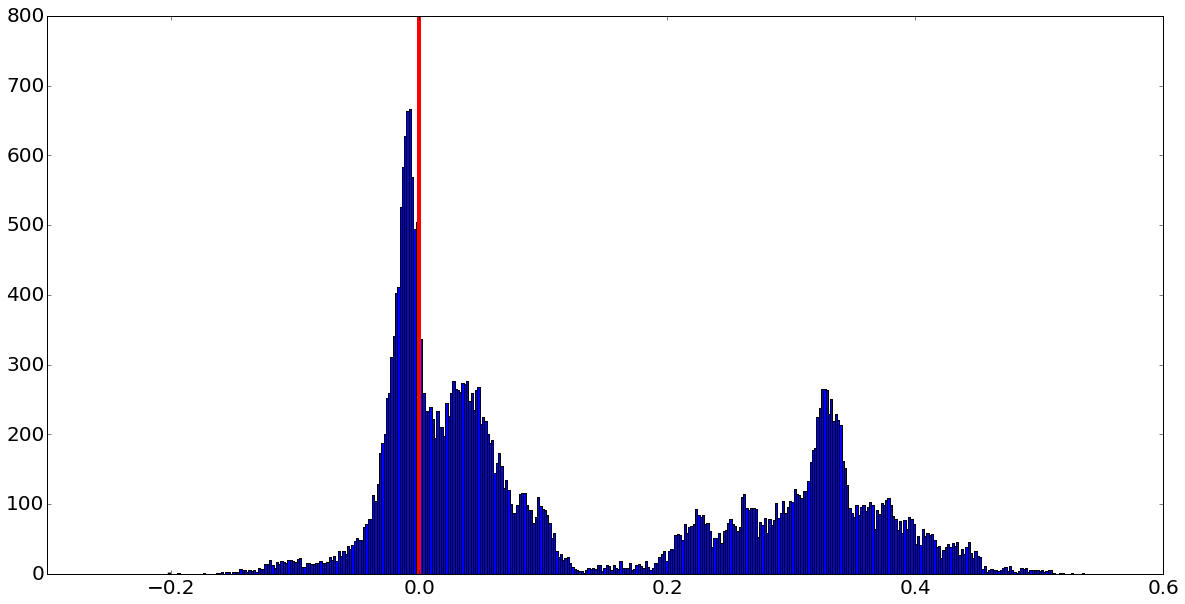

In [230]:
fig = plt.figure(figsize=(20,10))
hist = plt.hist(res_list[11].fittedvalues, bins = 400)
plt.vlines(0,0,800, color = 'r',linewidth = 4 )

In [231]:
info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100),'pseudo-R2':lambda x:"{:4.2f}%".format(x.prsquared*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,float_format='%.3f')


                                     DNO_all I DNO_all II DNO_all III DNO_all IIII   DNO I     DNO II   DNO III   DNO IIII DNO_1_prct I DNO_1_prct II DNO_1_prct III DNO_1_prct IIII DNO_05_prct I DNO_05_prct II DNO_05_prct III DNO_05_prct IIII
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
I(Rni / 100000)                      0.092***  0.039***   0.094***    0.040***     0.201***  0.122***  0.096***  0.061***  0.044***     -0.187***     -0.017         -0.123***       -0.020*       -0.200***      -0.066***       -0.154***       
                                     (0.008)   (0.007)    (0.008)     (0.008)      (0.014)   (0.014)   (0.015)   (0.015)   (0.014)      (0.012)       (0.015)        (0.014)         (0.011)       (0.010)        (0.013)         (0.011)         
Gain_fiscal_au_pacs[T.True]

In [232]:
regressor_order=["Intercept","I(Rni / 100000)" ,"I(Age_moyen_parents / 100)",
                 "Age_x1_child", 
                 "Children_number_is_2[T.True]", "Age_younger_x2_child" , "Age_elder_x2_child", 
                 "Children_number_is_3[T.True]", "Age_younger_x3_child" , "Age_elder_x3_child", 
                 "Children_number_is_4_or_more[T.True]", "Age_younger_x4_or_more_child" , "Age_elder_x4_or_more_child", 
                "Same_diploma_Master[T.True]","Same_diploma_licence[T.True]", "Same_diploma_No_educ[T.True]","Same_diploma_Vocational[T.True]",
                 "Licence_education_femme[T.True]","Licence_education_homme[T.True]",
                 "Vocational_education_femme[T.True]","Vocational_education_homme[T.True]",
                 "Master_PhD_education_femme[T.True]", "Master_PhD_education_homme[T.True]",
                 "TC",
                 "year_2014[T.True]",
                 
                ]

#### With diplomas

In [233]:
#threshold_DNO_dict = OrderedDict([(("DNO_all", df2013_A),10**-25),(("DNO", df2013_B),10**-25),  (("DNO_1prct",df2013_A.query("Can_optimize_to_1_prct") ), 10**-2), (("DNO_05prct", df2013_A.query("Can_optimize_to_0_5_prct")), 0.005)])
threshold_DNO_dict = OrderedDict([("DNO_all", (10**-25, df2013_A)), ("DNO",(10**-25,df2013_A.query("Can_optimize") ))])#("DNO_1prct", 10**-2), ("DNO_05prct", 0.005)])
threshold_DNO_dict = OrderedDict([("DNO_all", (10**-25, df2013_A)), ("DNO",(10**-25,df2013_A.query("Can_optimize") )),  
                                  ("DNO_1_prct",(10**-2,df2013_A.query("Can_optimize_to_1_prct") )),  ("DNO_05_prct",(10**-2,df2013_A.query("Can_optimize_to_0_5_prct") ))])
print "Do not optimize"
res_list = list()
for thrshld_name, thrshld_tuple in threshold_DNO_dict.iteritems():
    thrshld_value = thrshld_tuple[0]
    df_temp = thrshld_tuple[1]
    df_temp["Second_best_DNO"] = df_temp.Two_smallest_allocation_difference < (df_temp.Rni/thrshld_value) * (~df_temp.Children_number_is_1)
    for var_reg in [var_reg_household, var_reg_income_tax, var_reg_income_tax2 , var_reg_income_tax3]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
        df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg+"+"+"+".join(diploma_4_categories_to_regress)+"+Same_diploma",
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Do not optimize


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [234]:
info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100),'pseudo-R2':lambda x:"{:4.2f}%".format(x.prsquared*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,float_format='%.3f')


                                     DNO_all I DNO_all II DNO_all III DNO_all IIII   DNO I     DNO II   DNO III   DNO IIII DNO_1_prct I DNO_1_prct II DNO_1_prct III DNO_1_prct IIII DNO_05_prct I DNO_05_prct II DNO_05_prct III DNO_05_prct IIII
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                            -0.027    -0.011     -0.026      -0.007       -0.008    0.003     0.025     0.023     -0.010       0.019         0.000          -0.005          -0.002        0.021          0.005           0.003           
                                     (0.018)   (0.017)    (0.018)     (0.017)      (0.020)   (0.020)   (0.020)   (0.020)   (0.018)      (0.016)       (0.018)        (0.016)         (0.015)       (0.014)        (0.015)         (0.014)         
I(Rni / 100000)            

In [235]:
#threshold_DNO_dict = OrderedDict([(("DNO_all", df2013_A),10**-25),(("DNO", df2013_B),10**-25),  (("DNO_1prct",df2013_A.query("Can_optimize_to_1_prct") ), 10**-2), (("DNO_05prct", df2013_A.query("Can_optimize_to_0_5_prct")), 0.005)])
threshold_DNO_dict = OrderedDict([("DNO_all", (10**-25, df2013_A)), ("DNO",(10**-25,df2013_A.query("Can_optimize") ))])#("DNO_1prct", 10**-2), ("DNO_05prct", 0.005)])
threshold_DNO_dict = OrderedDict([("DNO_all", (10**-25, df2013_A)), ("DNO",(10**-25,df2013_A.query("Can_optimize") )),  
                                  ("DNO_1_prct",(10**-2,df2013_A.query("Can_optimize_to_1_prct") )),  ("DNO_05_prct",(10**-2,df2013_A.query("Can_optimize_to_0_5_prct") ))])
print "Do not optimize"
res_list = list()
for thrshld_name, thrshld_tuple in threshold_DNO_dict.iteritems():
    thrshld_value = thrshld_tuple[0]
    df_temp = thrshld_tuple[1]
    df_temp["Second_best_DNO"] = df_temp.Two_smallest_allocation_difference < (df_temp.Rni/thrshld_value) * (~df_temp.Children_number_is_1)
    for var_reg in [var_reg_household, var_reg_income_tax, var_reg_income_tax2 , var_reg_income_tax3]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>thrshld_value
        df_temp[thrshld_name] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "{}~".format(thrshld_name)+var_reg+"+Same_diploma_No_educ+Same_diploma_Vocational+Same_diploma_licence+Same_diploma_Master",
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Do not optimize


C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [236]:
info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100),'pseudo-R2':lambda x:"{:4.2f}%".format(x.prsquared*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,float_format='%.3f')


                                     DNO_all I DNO_all II DNO_all III DNO_all IIII   DNO I     DNO II   DNO III   DNO IIII DNO_1_prct I DNO_1_prct II DNO_1_prct III DNO_1_prct IIII DNO_05_prct I DNO_05_prct II DNO_05_prct III DNO_05_prct IIII
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                            0.057***  0.075***   0.058***    0.076***     0.063***  0.082***  0.099***  0.104***  0.013        0.051***      0.024          0.024           0.018         0.051***       0.026*          0.031**         
                                     (0.016)   (0.016)    (0.016)     (0.016)      (0.018)   (0.018)   (0.018)   (0.018)   (0.016)      (0.014)       (0.016)        (0.015)         (0.014)       (0.013)        (0.014)         (0.013)         
I(Rni / 100000)            

In [237]:
df2013_A_diplomas.Same_diploma.value_counts(normalize = True)

True    0.523
False   0.477
dtype: float64

In [238]:
print df2013_A_diplomas.query("No_education_femme").Same_diploma_No_educ.value_counts(normalize = True)
print df2013_A_diplomas.query("Vocational_education_femme").Same_diploma_Vocational.value_counts(normalize = True)
print df2013_A_diplomas.query("Licence_education_femme").Same_diploma_licence.value_counts(normalize = True)
print df2013_A_diplomas.query("Master_PhD_education_femme").Same_diploma_Master.value_counts(normalize = True)

False   0.656
True    0.344
dtype: float64
True    0.718
False   0.282
dtype: float64
False   0.757
True    0.243
dtype: float64
False   0.648
True    0.352
dtype: float64


In [239]:
print df2013_A_diplomas.query("No_education_homme").Same_diploma_No_educ.value_counts(normalize = True)
print df2013_A_diplomas.query("Vocational_education_homme").Same_diploma_Vocational.value_counts(normalize = True)
print df2013_A_diplomas.query("Licence_education_homme").Same_diploma_licence.value_counts(normalize = True)
print df2013_A_diplomas.query("Master_PhD_education_homme").Same_diploma_Master.value_counts(normalize = True)

False   0.781
True    0.219
dtype: float64
True    0.620
False   0.380
dtype: float64
False   0.601
True    0.399
dtype: float64
True    0.546
False   0.454
dtype: float64


In [240]:
educ = ["No_education_femme", "Vocational_education_femme", "Licence_education_femme", "Master_PhD_education_femme", "No_education_homme", "Vocational_education_homme", "Licence_education_homme", "Master_PhD_education_homme"]
educ_femme = ["No_education_femme", "Vocational_education_femme", "Licence_education_femme", "Master_PhD_education_femme",]
educ_homme = [ "No_education_homme", "Vocational_education_homme", "Licence_education_homme", "Master_PhD_education_homme"]

In [241]:
for var in educ_femme:
    df2013_A_diplomas.loc[df2013_A_diplomas[var] ,"Diplome_femme_str"] = var
for var in educ_homme:
    df2013_A_diplomas.loc[df2013_A_diplomas[var] ,"Diplome_homme_str"] = var

In [242]:
cross_tab = pd.crosstab(df2013_A_diplomas["Diplome_femme_str"], df2013_A_diplomas["Diplome_homme_str"], margins=True)
cross_tab_2 = cross_tab/df2013_A_diplomas.shape[0]

In [243]:
cross_tab_2.loc[:, 'All'] = cross_tab.loc[:, "All"]/len(df2013_A)

In [244]:
cross_tab_2.loc[:, 'All']/cross_tab.loc[:, "All"]

Diplome_femme_str
Licence_education_femme      0.000
Master_PhD_education_femme   0.000
No_education_femme           0.000
Vocational_education_femme   0.000
All                          0.000
Name: All, dtype: float64

In [245]:
cross_tab

Diplome_homme_str,Licence_education_homme,Master_PhD_education_homme,No_education_homme,Vocational_education_homme,All
Diplome_femme_str,,,,,
Licence_education_femme,1841,777,676,4275,7569
Master_PhD_education_femme,1044,1625,249,1700,4618
No_education_femme,135,43,1063,1853,3094
Vocational_education_femme,1599,533,2871,12760,17763
All,4619,2978,4859,20588,33044


In [246]:
cross_tab_2

Diplome_homme_str,Licence_education_homme,Master_PhD_education_homme,No_education_homme,Vocational_education_homme,All
Diplome_femme_str,,,,,
Licence_education_femme,0.056,0.024,0.020,0.129,0.145
Master_PhD_education_femme,0.032,0.049,0.008,0.051,0.088
No_education_femme,0.004,0.001,0.032,0.056,0.059
Vocational_education_femme,0.048,0.016,0.087,0.386,0.339
All,0.140,0.090,0.147,0.623,0.631


### Groupe B both year 

In [247]:
df2013_A["Montant_Gain_fiscal_au_pacs_effective"] = df2013_A.Gain_fiscal_au_pacs
df2013_A["Montant_Gain_fiscal_au_pacs_potentiel"] = df2013_A.result_min_allocation - df2013_A.Irpp_decote_pacs
df2013_A["Montant_Gain_fiscal_au_pacs"] = df2013_A.result_min_allocation - df2013_A.Irpp_decote_pacs
df2013_A["Gain_fiscal_au_pacs"] = df2013_A["Montant_Gain_fiscal_au_pacs"]> 0 
df2013_A["Perte_fiscale_au_pacs"] = df2013_A["Montant_Gain_fiscal_au_pacs"]< 0 

In [248]:
df2013_A["Gain_fiscal_au_pacs"] = df2013_A["Montant_Gain_fiscal_au_pacs"]> 0 

(-600, 1000)

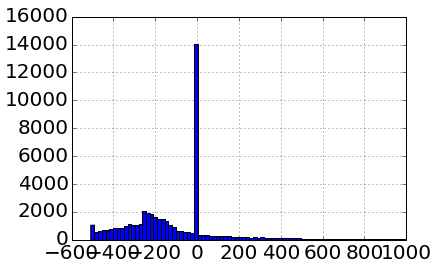

In [249]:
df2013_A.Montant_Gain_fiscal_au_pacs.hist(bins = 1000)
plt.xlim(-600,1000)

In [250]:
seuil_1 = 0.0000000000000000000000000000000000000000000000000000000001
print "Do not optimize"
res_list = list()
for var_reg in [var_reg_0,var_reg_01]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)
for var_reg in [var_reg_1, var_reg_2,var_reg_02]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)

        
        
seuil_1 = 0.01
print "Do not optimize 1 %"

for var_reg in [var_reg_0,var_reg_01]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO_1_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO_1_prct~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)
for var_reg in [var_reg_1, var_reg_2,var_reg_02]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO_1_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO_1_prct~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)
        
seuil_1 = 0.005
print "Do not optimize 0.5 %"

for var_reg in [var_reg_0,var_reg_01]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO_05_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO_05_prct~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)
for var_reg in [var_reg_1, var_reg_2, var_reg_02]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO_05_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO_05_prct~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)

Do not optimize
Do not optimize 1 %
Do not optimize 0.5 %


In [251]:
regressor_order=["Age_moyen","Ecart_Age_en_valeur_absolue","I(Rni / 100000)" ,
                 "Age_elder_child","Age_younger_child",
                 "deux_enfants[T.True]", "trois_enfants[T.True]", "quatre_enfants_et_plus[T.True]",
                "Same_diploma_Master[T.True]","Same_diploma_licence[T.True]", "Same_diploma_No_educ[T.True]","Same_diploma_Vocational[T.True]",
                 "Licence_education_femme[T.True]","Licence_education_homme[T.True]",
                 "Vocational_education_femme[T.True]","Vocational_education_homme[T.True]",
                 "Master_PhD_education_femme[T.True]", "Master_PhD_education_homme[T.True]",
                 "TC",
                 "year_2014[T.True]", "Intercept"
                 
                ]

In [252]:
OLS.rsquared_adj

0.016992448430818152

In [253]:
info_dict={'rsquared_adj':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,)


                                     DNO I      DNO II    DNO III    DNO IIII  DNO IIIII  DNO_1_prct I DNO_1_prct II DNO_1_prct III DNO_1_prct IIII DNO_1_prct IIIII DNO_05_prct I DNO_05_prct II DNO_05_prct III DNO_05_prct IIII DNO_05_prct IIIII
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age_moyen                          0.0060***  0.0035***  0.0046***  0.0038***  0.0044***  0.0016***    0.0017***     0.0018***      0.0017***       0.0017***        0.0025***     0.0018***      0.0023***       0.0021***        0.0021***        
                                   (0.0004)   (0.0004)   (0.0006)   (0.0006)   (0.0006)   (0.0003)     (0.0003)      (0.0004)       (0.0004)        (0.0004)         (0.0003)      (0.0003)       (0.0004)        (0.0004)         (0.0004)         
Ecart_Age_en_valeur

In [254]:
info_dict={'rsquared_adj':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,)


                                     DNO I      DNO II    DNO III    DNO IIII  DNO IIIII  DNO_1_prct I DNO_1_prct II DNO_1_prct III DNO_1_prct IIII DNO_1_prct IIIII DNO_05_prct I DNO_05_prct II DNO_05_prct III DNO_05_prct IIII DNO_05_prct IIIII
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age_moyen                          0.0060***  0.0035***  0.0046***  0.0038***  0.0044***  0.0016***    0.0017***     0.0018***      0.0017***       0.0017***        0.0025***     0.0018***      0.0023***       0.0021***        0.0021***        
                                   (0.0004)   (0.0004)   (0.0006)   (0.0006)   (0.0006)   (0.0003)     (0.0003)      (0.0004)       (0.0004)        (0.0004)         (0.0003)      (0.0003)       (0.0004)        (0.0004)         (0.0004)         
Ecart_Age_en_valeur

In [255]:
info_dict={'adj-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,)


                                     DNO I      DNO II    DNO III    DNO IIII  DNO IIIII  DNO_1_prct I DNO_1_prct II DNO_1_prct III DNO_1_prct IIII DNO_1_prct IIIII DNO_05_prct I DNO_05_prct II DNO_05_prct III DNO_05_prct IIII DNO_05_prct IIIII
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age_moyen                          0.0060***  0.0035***  0.0046***  0.0038***  0.0044***  0.0016***    0.0017***     0.0018***      0.0017***       0.0017***        0.0025***     0.0018***      0.0023***       0.0021***        0.0021***        
                                   (0.0004)   (0.0004)   (0.0006)   (0.0006)   (0.0006)   (0.0003)     (0.0003)      (0.0004)       (0.0004)        (0.0004)         (0.0003)      (0.0003)       (0.0004)        (0.0004)         (0.0004)         
Ecart_Age_en_valeur

### Both year but present both year (pour ajouter la naissance de l'enfant comme variable)

In [256]:
child_gain_id_fisc_log_diff = df_A[df_A.Family_child_gain].ID_FISC_LOG_DIFF
observed_both_years_id_fisc_log_diff = df_A.ID_FISC_LOG_DIFF

In [257]:
for df_temp in [df2013_A, df2014_A, df2013_B, df2014_B]:
    df_temp["Family_child_gain"] = df_temp.ID_FISC_LOG_DIFF.isin(child_gain_id_fisc_log_diff)
    df_temp["Observed_both_years"] = df_temp.ID_FISC_LOG_DIFF.isin(observed_both_years_id_fisc_log_diff)

In [258]:
seuil_1 = 0.0000000000000000000000000000000000000000000000000000000001
print "Do not optimize"
res_list = list()
for var_reg in [var_reg_0 +"+Family_child_gain",var_reg_01+"+Family_child_gain"]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp = df_temp[df_temp["Observed_both_years"]]
        df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)
for var_reg in [var_reg_1+"+Family_child_gain", var_reg_2+"+Family_child_gain",var_reg_02+"+Family_child_gain"]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp = df_temp[df_temp["Observed_both_years"]]
        df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)

        
        
seuil_1 = 0.01
print "Do not optimize 1 %"

for var_reg in [var_reg_0+"+Family_child_gain",var_reg_01+"+Family_child_gain"]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO_1_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp = df_temp[df_temp["Observed_both_years"]]
        df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO_1_prct~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)
for var_reg in [var_reg_1+"+Family_child_gain", var_reg_2+"+Family_child_gain",var_reg_02+"+Family_child_gain"]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO_1_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp = df_temp[df_temp["Observed_both_years"]]
        df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO_1_prct~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)
        
seuil_1 = 0.005
print "Do not optimize 0.5 %"

for var_reg in [var_reg_0+"+Family_child_gain",var_reg_01+"+Family_child_gain"]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO_05_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp = df_temp[df_temp["Observed_both_years"]]
        df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO_05_prct~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)
for var_reg in [var_reg_1+"+Family_child_gain", var_reg_2+"+Family_child_gain", var_reg_02+"+Family_child_gain"]:
    for df_temp in [df2013_A]:# [df_concat_A, df_concat_C]:
        df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
        df_temp["DNO_05_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
        df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
        df_temp = df_temp[df_temp["Observed_both_years"]]
        df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
        OLS = smf.OLS.from_formula(formula =  "DNO_05_prct~"+var_reg,
                         data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
        res_list.append(OLS)

Do not optimize
Do not optimize 1 %
Do not optimize 0.5 %


In [259]:
info_dict={'adj-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100),"Log_likelihood":lambda x:"{:d}".format(int(x.llf)), "N":lambda x:"{:d}".format(int(x.nobs))}
print "2013_B"
print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,)

2013_B

                                     DNO I      DNO II    DNO III    DNO IIII  DNO IIIII  DNO_1_prct I DNO_1_prct II DNO_1_prct III DNO_1_prct IIII DNO_1_prct IIIII DNO_05_prct I DNO_05_prct II DNO_05_prct III DNO_05_prct IIII DNO_05_prct IIIII
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age_moyen                          0.0056***  0.0034***  0.0047***  0.0038***  0.0044***  0.0014***    0.0017***     0.0018***      0.0017***       0.0017***        0.0021***     0.0017***      0.0024***       0.0022***        0.0023***        
                                   (0.0005)   (0.0005)   (0.0007)   (0.0007)   (0.0007)   (0.0003)     (0.0003)      (0.0004)       (0.0004)        (0.0004)         (0.0004)      (0.0004)       (0.0005)        (0.0005)         (0.0005)         
Ecart_Age_en

### groupe B 2013

In [260]:
#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+


var_reg_0 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus"
        )
var_reg_1 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus+"
            "+Same_diploma_No_educ+Same_diploma_Vocational+Same_diploma_licence+Same_diploma_Master"
        )
var_reg_2 = ("Age_younger_child+Age_elder_child+Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+" 
            "deux_enfants+trois_enfants+ quatre_enfants_et_plus"+"+"+"+".join(diploma_4_categories_to_regress))

In [261]:
for df_select in [df2013_A, df2014_A, df2013_B, df2014_B]:
    seuil_1 = 0.0000000000000000000000000000000000000000000000000000000001
    print "Do not optimize"
    res_list = list()
    for var_reg in [var_reg_0]:
        for df_temp in [df_select]:# [df_concat_A, df_concat_C]:
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
            df_temp["DNO"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "DNO~"+var_reg,
                             data = df_temp2).fit() #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
    for var_reg in [var_reg_1, var_reg_2]:
        for df_temp.Ag in [df_select]:# [df_concat_A, df_concat_C]:
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
            df_temp["DNO"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "DNO~"+var_reg,
                             data = df_temp2).fit() #Ordre olivier, virer "No_decote"
            res_list.append(OLS)



    seuil_1 = 0.01
    print "Do not optimize 1 %"

    for var_reg in [var_reg_0]:
        for df_temp in [df_select]:# [df_concat_A, df_concat_C]:
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
            df_temp["DNO_1_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "DNO_1_prct~"+var_reg,
                             data = df_temp2).fit() #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
    for var_reg in [var_reg_1, var_reg_2]:
        for df_temp in [df_select]:# [df_concat_A, df_concat_C]:
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
            df_temp["DNO_1_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "DNO_1_prct~"+var_reg,
                             data = df_temp2).fit() #Ordre olivier, virer "No_decote"
            res_list.append(OLS)

    seuil_1 = 0.005
    print "Do not optimize 0.5 %"

    for var_reg in [var_reg_0]:
        for df_temp in [df_select]:# [df_concat_A, df_concat_C]:
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
            df_temp["DNO_05_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "DNO_05_prct~"+var_reg,
                             data = df_temp2).fit() #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
    for var_reg in [var_reg_1, var_reg_2]:
        for df_temp in [df_select]:# [df_concat_A, df_concat_C]:
            df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
            df_temp["DNO_05_prct"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
            df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
            df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
            OLS = smf.OLS.from_formula(formula =  "DNO_05_prct~"+var_reg,
                             data = df_temp2).fit() #Ordre olivier, virer "No_decote"
            res_list.append(OLS)
    info_dict={'adj-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100),"Log_likelihood":lambda x:"{:d}".format(int(x.llf)), "N":lambda x:"{:d}".format(int(x.nobs))}
    print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,)

Do not optimize
Do not optimize 1 %
Do not optimize 0.5 %

                                     DNO I      DNO II    DNO III   DNO_1_prct I DNO_1_prct II DNO_1_prct III DNO_05_prct I DNO_05_prct II DNO_05_prct III
----------------------------------------------------------------------------------------------------------------------------------------------------------
Age_moyen                          0.0060***  0.0046***  0.0038***  0.0016***    0.0018***     0.0017***      0.0024***     0.0023***      0.0021***      
                                   (0.0005)   (0.0006)   (0.0006)   (0.0003)     (0.0004)      (0.0004)       (0.0004)      (0.0004)       (0.0004)       
Ecart_Age_en_valeur_absolue        -0.0045*** -0.0033*** -0.0026*** -0.0003      -0.0002       -0.0001        -0.0009       -0.0004        -0.0003        
                                   (0.0007)   (0.0008)   (0.0008)   (0.0005)     (0.0005)      (0.0005)       (0.0006)      (0.0006)       (0.0006)       
I(Rni / 100

### Autres marges que le % de revenu

In [262]:
for dependent_var in ["Fiscal_loss","Prct_rev_perte_fiscale" ]:
    print dependent_var
    for df_select in [ df2013_B, df2014_B]:
        res_list = list()
        for var_reg in [var_reg_0]:
            for df_temp in [df_select]:# [df_concat_A, df_concat_C]:
                df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
                df_temp["DNO"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
                df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
                df_temp2 = df_temp#[df_temp[diploma_4_categories].sum(axis = 1) == 2]
                OLS = smf.OLS.from_formula(formula =  "{}~".format(dependent_var)+var_reg,
                                 data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
                res_list.append(OLS)
        for var_reg in [var_reg_1, var_reg_2]:
            for df_temp.Ag in [df_select]:# [df_concat_A, df_concat_C]:
                df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
                df_temp["DNO"] = df_temp["Perte_fiscale_over_{}_prct_rev".format(seuil_1)].astype('int')
                df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
                df_temp2 = df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
                OLS = smf.OLS.from_formula(formula =   "{}~".format(dependent_var)+var_reg,
                                 data = df_temp2).fit(missing = 'drop') #Ordre olivier, virer "No_decote"
                res_list.append(OLS)


Fiscal_loss
Prct_rev_perte_fiscale


In [263]:
info_dict={'adj-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}
print summary_col(res_list, stars=True, regressor_order=regressor_order, info_dict = info_dict,)


                                   Prct_rev_perte_fiscale I Prct_rev_perte_fiscale II Prct_rev_perte_fiscale III
----------------------------------------------------------------------------------------------------------------
Age_moyen                          0.0001***                0.0001**                  0.0001**                  
                                   (0.0000)                 (0.0001)                  (0.0001)                  
Ecart_Age_en_valeur_absolue        -0.0001*                 -0.0001*                  -0.0001*                  
                                   (0.0001)                 (0.0001)                  (0.0001)                  
I(Rni / 100000)                    0.0016                   0.0025*                   0.0027*                   
                                   (0.0012)                 (0.0015)                  (0.0016)                  
Age_elder_child                    -0.0004***               -0.0004***                -0.0004**

In [264]:
seuil_1 = 0.000000000000000000001
print "Do optimize"
for df_temp in [df_concat_B]:# [df_concat_A, df_concat_C]:
    df_temp["Perte_fiscale_less_then_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
    df_temp["Perte_fiscale_less_then"] = df_temp["Perte_fiscale_less_then_{}_prct_rev".format(seuil_1)].astype('int')
    print df_temp.shape
    df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
    df_temp2 = df_temp#df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
    PROBIT = smf.Probit.from_formula(formula =  "Perte_fiscale_less_then~"+ "Age_younger_child+Age_elder_child+"+
                     "Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+"+
                     "deux_enfants+trois_enfants+ quatre_enfants_et_plus+year_2014+"+#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
                    "+"+"+".join(diploma_4_categories_to_regress),
                                    # "+Same_diploma_No_educ+Same_diploma_Vocational+Same_diploma_licence+Same_diploma_Master",
                     data = df_temp2).fit() #Ordre olivier, virer "No_decote"
print PROBIT.summary()



seuil_1 = 0.000000000000000000001

for df_temp in [df_concat_B]:# [df_concat_A, df_concat_C]:
    df_temp["Perte_fiscale_less_then_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)>seuil_1
    df_temp["Perte_fiscale_less_then"] = df_temp["Perte_fiscale_less_then_{}_prct_rev".format(seuil_1)].astype('int')
    print df_temp.shape
    df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
    df_temp2 = df_temp#df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
    PROBIT = smf.Probit.from_formula(formula =  "Perte_fiscale_less_then~"+ "Age_younger_child+Age_elder_child+"+
                     "Age_moyen +Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+"+
                     "deux_enfants+trois_enfants+ quatre_enfants_et_plus+year_2014+"+#Diff_in_incompe_mere_pere+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    #"Gain_fiscal_au_pacs"+
                    #"+"+"+".join(diploma_4_categories_to_regress),
                                     "+Same_diploma_No_educ+Same_diploma_Vocational+Same_diploma_licence+Same_diploma_Master",
                     data = df_temp2).fit() #Ordre olivier, virer "No_decote"

print PROBIT.summary()

Do optimize
(92319, 232)
Optimization terminated successfully.
         Current function value: 0.573236
         Iterations 5
                             Probit Regression Results                             
Dep. Variable:     Perte_fiscale_less_then   No. Observations:                58475
Model:                              Probit   Df Residuals:                    58458
Method:                                MLE   Df Model:                           16
Date:                     Fri, 26 Apr 2019   Pseudo R-squ.:                 0.02294
Time:                             18:27:20   Log-Likelihood:                -33520.
converged:                            True   LL-Null:                       -34307.
                                             LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------

In [265]:
seuil_1 = 0.01


for df_temp in [df2013_B]:# [df_concat_A, df_concat_C]:
    df_temp["Perte_fiscale_less_then_{}_prct_rev".format(seuil_1)] =  (df_temp.Fiscal_loss/df_temp.Rni)<seuil_1
    df_temp["Perte_fiscale_less_then"] = df_temp["Perte_fiscale_less_then_{}_prct_rev".format(seuil_1)].astype('int')
    print df_temp.shape
    df_temp.loc[:,"Intersect"]=  np.zeros(df_temp.shape[0])+1
    df_temp2 = df_temp#df_temp[df_temp[diploma_4_categories].sum(axis = 1) == 2]
    PROBIT = smf.Probit.from_formula(formula =  "Perte_fiscale_less_then~"+ 
                     #"Age_moyen + Age_moyen_squared+Ecart_Age_en_valeur_absolue+I(Rni/100000)+TC+"+
                     #"Diff_in_incompe_mere_pere+deux_enfants+trois_enfants_et_plus+"+
                    #"I(Two_smallest_allocation_difference/1000)+ I(Gain_fiscal_max/1000)"
                    "Gain_fiscal_au_pacs",
                    #"+"+"+".join(diploma_4_categories_to_regress)+ "+Same_diploma_No_educ+Same_diploma_Vocational+Same_diploma_licence+Same_diploma_Master",
                     data = df_temp2).fit() #Ordre olivier, virer "No_decote"
print PROBIT.summary()

(46446, 273)
Optimization terminated successfully.
         Current function value: 0.215762
         Iterations 8
                             Probit Regression Results                             
Dep. Variable:     Perte_fiscale_less_then   No. Observations:                46446
Model:                              Probit   Df Residuals:                    46444
Method:                                MLE   Df Model:                            1
Date:                     Fri, 26 Apr 2019   Pseudo R-squ.:                  0.3035
Time:                             18:27:20   Log-Likelihood:                -10021.
converged:                            True   LL-Null:                       -14389.
                                             LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept            

In [266]:
stop_time = datetime.datetime.now(); print("now: ",stop_time);
execution_time = stop_time - start_time; print("execution_time: ",execution_time)
stop_time = start_time

('now: ', datetime.datetime(2019, 4, 26, 18, 27, 20, 697000))
('execution_time: ', datetime.timedelta(0, 868, 57000))


In [267]:
for col in df_temp2.columns:
    print col

ID_FISC_LOG_DIFF
level_0
ANAIS
AN_FISC_x
AN_FISC_y
Age
Age_mere
Age_pere
Allocation_mere
Allocation_pere
CNE1
COM_NSCAT
COM_SCAT1
COM_SCAT2
DACOED
DACOEP
Decote
Decote_pacs
Fiscal_loss
Gain_fiscal_max
Gain_fiscal_max_in_ratio
ID_DIFF
ID_FISC_FOY_DIFF
I_FISC_LOGEMENT
I_FISC_REVENU
Irpp_ac_plaf_qf
Irpp_ac_plaf_qf_mere
Irpp_ac_plaf_qf_pacs
Irpp_ac_plaf_qf_pere
Irpp_ac_qf
Irpp_ac_qf_pacs
Irpp_decote
Irpp_decote_allocation_1
Irpp_decote_allocation_2
Irpp_decote_allocation_3
Irpp_decote_allocation_4
Irpp_decote_allocation_5
Irpp_decote_allocation_6
Irpp_decote_allocation_7
Irpp_decote_allocation_8
Irpp_decote_allocation_9
Irpp_decote_mere
Irpp_decote_pacs
Irpp_decote_pere
Irpp_decote_seuil_prel_allocation_1
Irpp_decote_seuil_prel_allocation_2
Irpp_decote_seuil_prel_allocation_3
Irpp_decote_seuil_prel_allocation_4
Irpp_decote_seuil_prel_allocation_5
Irpp_decote_seuil_prel_allocation_6
Irpp_decote_seuil_prel_allocation_7
Irpp_decote_seuil_prel_allocation_8
Irpp_decote_seuil_prel_allocation_9
I

In [268]:
stop_time = datetime.datetime.now(); print("now: ",stop_time);
execution_time = stop_time - start_time; print("execution_time: ",execution_time)
stop_time = start_time
#clear  memory
%reset -f

('now: ', datetime.datetime(2019, 4, 26, 18, 27, 20, 715000))
('execution_time: ', datetime.timedelta(0, 868, 75000))
